## CNN+LSTM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline

In [3]:
# These functions allow us to preprocess 
# original images from size of 210x160x3 
# to size of 84x84 (grayscale images).

import theano
from PIL import Image

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    
    img = Image.fromarray(img).resize((def_h, def_w))
    
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1),dtype=theano.config.floatX)
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = Image.fromarray(img).resize((def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1),dtype=theano.config.floatX)
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = Image.fromarray(img).resize((def_h, def_w))
    return tnsr

### Game Parameters

In [8]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 16
replay_seq_len = 64

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [9]:
observation_shape

(None, 84, 84, 1)

In [10]:
del atari

### Observations

In [11]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer

observation_layer = InputLayer(observation_shape, name="images input")
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

### Memory layer

In [13]:
from agentnet.memory import WindowAugmentation
window_size = 4

prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")

window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")

memory_dict = {window:prev_window}

### Policy

In [14]:
from lasagne.layers import DenseLayer, ExpressionLayer
from lasagne.nonlinearities import elu, leaky_rectify
from agentnet.memory import LSTMCell

window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])

nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(4, 4), nonlinearity=leaky_rectify)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2), nonlinearity=leaky_rectify)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

prev_cell = InputLayer((None,256))
prev_out = InputLayer((None,256))

new_cell,new_out = LSTMCell(prev_cell,prev_out,nn,name='lstm')
memory_dict[new_cell] = prev_cell
memory_dict[new_out] = prev_out

### Resolver

In [15]:
from agentnet.resolver import EpsilonGreedyResolver

q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")
resolver = EpsilonGreedyResolver(q_eval,name="resolver")

### Putting it together

In [17]:
from agentnet.agent import Agent

agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)

weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 lstm.b_to_ingate,
 lstm.W_ctrl0_to_ingate,
 lstm.W_ctrl1_to_ingate,
 lstm.b_to_forgetgate,
 lstm.W_ctrl0_to_forgetgate,
 lstm.W_ctrl1_to_forgetgate,
 lstm.b_to_cell,
 lstm.W_ctrl0_to_cell,
 lstm.W_ctrl1_to_cell,
 lstm.b_to_outgate,
 lstm.W_ctrl0_to_outgate,
 lstm.W_ctrl1_to_outgate,
 lstm.W_cell_to_ingate_peephole.scales,
 lstm.W_cell_to_forgetgate_peephole.scales,
 lstm.W_cell_to_outgate_peephole.scales,
 QEvaluator.W,
 QEvaluator.b]

### Step function

In [50]:
applier_fun = agent.get_react_function()

def step(observation, prev_memories_w = 'zeros', prev_memories_c = 'zeros', prev_memories_o = 'zeros', bs=N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    
    zeros_arr = agent.get_zeros_like_memory(batch_size=bs)
    if prev_memories_w == 'zeros':
        prev_memories_w = zeros_arr[0]
    if prev_memories_c == 'zeros':
        prev_memories_c = zeros_arr[1]
    if prev_memories_o == 'zeros':
        prev_memories_o = zeros_arr[2]
    
    obs = preprocess_tensor4(np.array(observation))
    res = applier_fun(obs, prev_memories_w, prev_memories_c, prev_memories_o)
    action = res[0]
    memories = res[1:]
    return action, memories[0], memories[1], memories[2]

### Environment, pool and all other stuff

In [19]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, n_games=N_PARALLEL_GAMES, make_env=GAME_TITLE, agent_step=step)

[2017-05-24 12:38:57,514] Making new env: MsPacman-v0
[2017-05-24 12:38:57,684] Making new env: MsPacman-v0
[2017-05-24 12:38:57,854] Making new env: MsPacman-v0
[2017-05-24 12:38:58,023] Making new env: MsPacman-v0
[2017-05-24 12:38:58,193] Making new env: MsPacman-v0
[2017-05-24 12:38:58,363] Making new env: MsPacman-v0
[2017-05-24 12:38:58,533] Making new env: MsPacman-v0
[2017-05-24 12:38:58,703] Making new env: MsPacman-v0
[2017-05-24 12:38:58,873] Making new env: MsPacman-v0
[2017-05-24 12:38:59,042] Making new env: MsPacman-v0
[2017-05-24 12:38:59,213] Making new env: MsPacman-v0
[2017-05-24 12:38:59,383] Making new env: MsPacman-v0
[2017-05-24 12:38:59,553] Making new env: MsPacman-v0
[2017-05-24 12:38:59,723] Making new env: MsPacman-v0
[2017-05-24 12:38:59,893] Making new env: MsPacman-v0
[2017-05-24 12:39:00,064] Making new env: MsPacman-v0


In [20]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


[['NOOP' 'DOWN' 'DOWN' 'RIGHT' 'NOOP']
 ['NOOP' 'DOWN' 'LEFT' 'RIGHT' 'NOOP']
 ['RIGHT' 'LEFT' 'DOWN' 'RIGHT' 'NOOP']]
CPU times: user 688 ms, sys: 56 ms, total: 744 ms
Wall time: 741 ms


In [23]:
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
    observation_tensor = preprocess_tensor(observation_tensor)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
update_pool(env,pool,replay_seq_len)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


### Loss

In [24]:
import sys
sys.setrecursionlimit(10000)

from agentnet.learning import sarsa
from lasagne.regularization import regularize_network_params, l2

#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

scaled_reward_seq = env.rewards
elwise_mse_loss = sarsa.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()
reg_l2 = regularize_network_params(resolver,l2)*10**-4
loss = mse_loss + reg_l2

updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

mean_session_reward = env.rewards.sum(axis=1).mean()

/home/vishimtsev/.local/lib/python2.7/site-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [ ]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

### Training

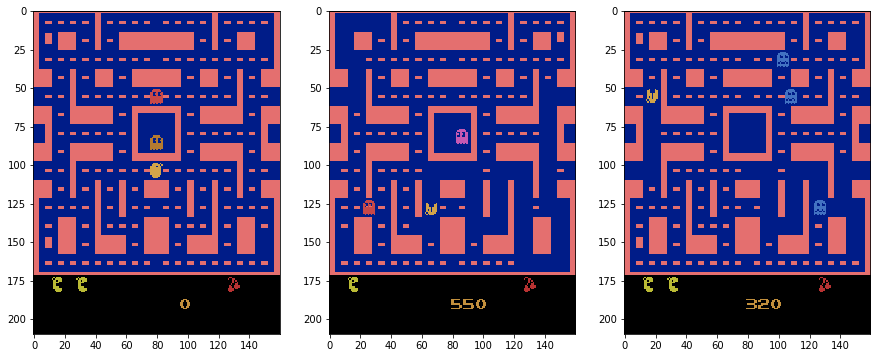

In [40]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()

#visualize untrained network performance (which is mostly random)
display_sessions()

In [46]:
import os
from agentnet.display import Metrics

score_log = Metrics()
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


epoch 1010,loss 390.55916, epsilon 0.21390, rewards: ( e-greedy 81.57162, greedy 76.77075) 
rec 390.456 reg 0.103
epoch 1020,loss 686.55809, epsilon 0.21227, rewards: ( e-greedy 82.60196, greedy 75.28118) 
rec 686.455 reg 0.103
epoch 1030,loss 522.21506, epsilon 0.21065, rewards: ( e-greedy 82.84176, greedy 76.31556) 
rec 522.112 reg 0.103
epoch 1040,loss 311.40463, epsilon 0.20905, rewards: ( e-greedy 82.80759, greedy 80.24651) 
rec 311.301 reg 0.103
epoch 1050,loss 225.61102, epsilon 0.20747, rewards: ( e-greedy 81.33933, greedy 80.84685) 
rec 225.508 reg 0.103
epoch 3820,loss 381.65278, epsilon 0.05987, rewards: ( e-greedy 87.17225, greedy 98.49935) 
rec 381.541 reg 0.112
epoch 3830,loss 710.11758, epsilon 0.05977, rewards: ( e-greedy 84.83003, greedy 94.96191) 
rec 710.006 reg 0.112
epoch 3840,loss 757.67710, epsilon 0.05967, rewards: ( e-greedy 87.09702, greedy 92.46572) 
rec 757.565 reg 0.112
epoch 3850,loss 1396.07286, epsilon 0.05958, rewards: ( e-greedy 89.51232, greedy 95.969

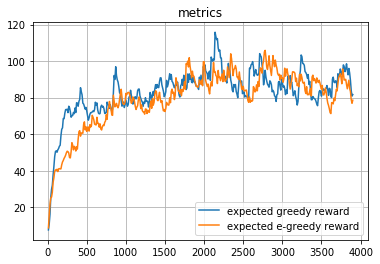

Random session examples


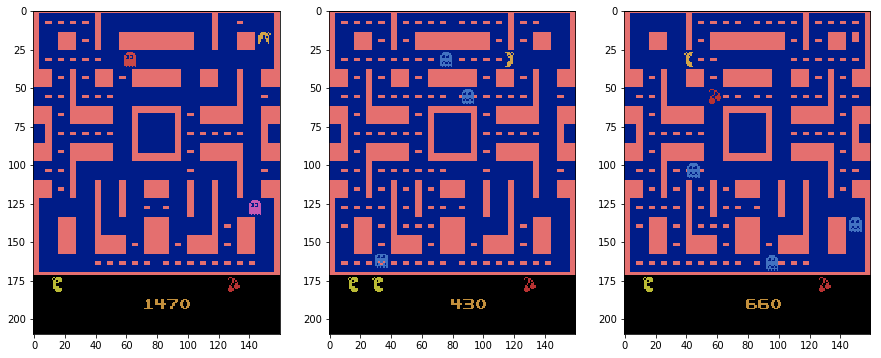

epoch 3910,loss 315.49434, epsilon 0.05902, rewards: ( e-greedy 77.09257, greedy 83.00606) 
rec 315.383 reg 0.112
epoch 3920,loss 718.49342, epsilon 0.05893, rewards: ( e-greedy 79.75831, greedy 91.26796) 
rec 718.382 reg 0.112
epoch 3930,loss 431.91517, epsilon 0.05884, rewards: ( e-greedy 80.21998, greedy 93.45366) 
rec 431.803 reg 0.112
epoch 3940,loss 358.75580, epsilon 0.05875, rewards: ( e-greedy 79.44798, greedy 96.23330) 
rec 358.644 reg 0.112
epoch 3950,loss 624.47029, epsilon 0.05866, rewards: ( e-greedy 78.94068, greedy 97.29747) 
rec 624.358 reg 0.112
epoch 3960,loss 488.58475, epsilon 0.05858, rewards: ( e-greedy 78.04661, greedy 100.38022) 
rec 488.473 reg 0.112
epoch 3970,loss 1785.83070, epsilon 0.05849, rewards: ( e-greedy 86.92945, greedy 94.90470) 
rec 1785.718 reg 0.112
epoch 3980,loss 396.23735, epsilon 0.05841, rewards: ( e-greedy 86.11151, greedy 91.16423) 
rec 396.125 reg 0.112
epoch 3990,loss 1615.12725, epsilon 0.05832, rewards: ( e-greedy 91.25036, greedy 88.

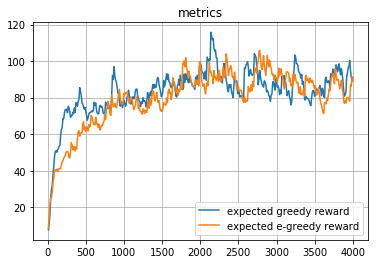

Random session examples


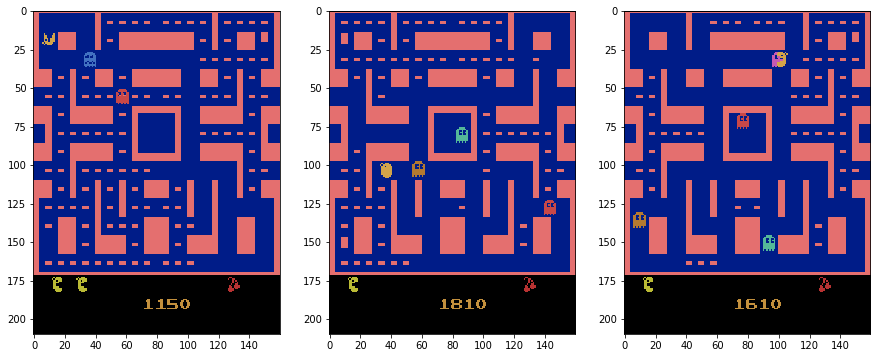

[2017-05-24 17:36:58,418] Making new env: MsPacman-v0
[2017-05-24 17:36:58,582] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 17:36:58,590] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.11.19270.video000000.mp4
[2017-05-24 17:37:00,493] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.11.19270.video000001.mp4


Episode finished after 788 timesteps with reward=350.0
Episode finished after 975 timesteps with reward=300.0
Episode finished after 579 timesteps with reward=260.0
Episode finished after 548 timesteps with reward=210.0
Episode finished after 670 timesteps with reward=210.0
Episode finished after 917 timesteps with reward=560.0
Episode finished after 760 timesteps with reward=320.0


[2017-05-24 17:37:09,817] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.11.19270.video000008.mp4


Episode finished after 411 timesteps with reward=190.0
Episode finished after 627 timesteps with reward=210.0
Episode finished after 423 timesteps with reward=80.0
Episode finished after 582 timesteps with reward=420.0
Episode finished after 670 timesteps with reward=470.0
Episode finished after 1212 timesteps with reward=750.0
Episode finished after 836 timesteps with reward=220.0
Episode finished after 888 timesteps with reward=480.0
Episode finished after 694 timesteps with reward=360.0
Episode finished after 1067 timesteps with reward=670.0
Episode finished after 613 timesteps with reward=320.0
Episode finished after 422 timesteps with reward=180.0


[2017-05-24 17:37:25,760] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 415 timesteps with reward=180.0
Mean 337.0, Var 29191.0
epoch 4010,loss 329.27863, epsilon 0.05816, rewards: ( e-greedy 85.53154, greedy 89.00122) 
rec 329.166 reg 0.113
epoch 4020,loss 876.55532, epsilon 0.05808, rewards: ( e-greedy 84.41589, greedy 87.28860) 
rec 876.443 reg 0.113
epoch 4030,loss 3866.91766, epsilon 0.05800, rewards: ( e-greedy 89.53680, greedy 86.37224) 
rec 3866.805 reg 0.112
epoch 4040,loss 538.02836, epsilon 0.05792, rewards: ( e-greedy 86.89562, greedy 85.29752) 
rec 537.916 reg 0.113
epoch 4050,loss 540.12192, epsilon 0.05784, rewards: ( e-greedy 87.58106, greedy 91.70526) 
rec 540.009 reg 0.113
epoch 4060,loss 276.55393, epsilon 0.05776, rewards: ( e-greedy 84.63545, greedy 88.97224) 
rec 276.441 reg 0.113
epoch 4070,loss 3594.63047, epsilon 0.05768, rewards: ( e-greedy 88.73440, greedy 87.88751) 
rec 3594.518 reg 0.113
epoch 4080,loss 1198.15704, epsilon 0.05761, rewards: ( e-greedy 90.23596, greedy 89.34876) 
rec 1198.044 reg 0.113
epo

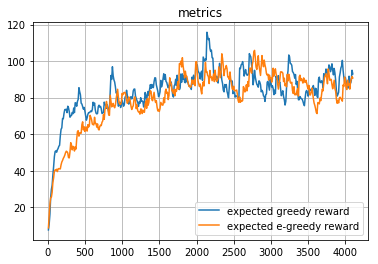

Random session examples


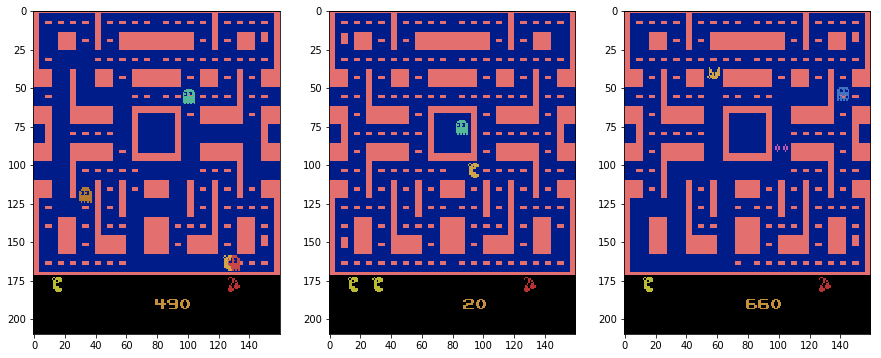

epoch 4110,loss 565.86021, epsilon 0.05738, rewards: ( e-greedy 86.17264, greedy 92.61837) 
rec 565.748 reg 0.113
epoch 4120,loss 3481.51196, epsilon 0.05731, rewards: ( e-greedy 88.30538, greedy 92.85654) 
rec 3481.399 reg 0.113
epoch 4130,loss 4645.71167, epsilon 0.05724, rewards: ( e-greedy 96.47484, greedy 95.00838) 
rec 4645.599 reg 0.113
epoch 4140,loss 470.09739, epsilon 0.05717, rewards: ( e-greedy 94.32736, greedy 101.82004) 
rec 469.985 reg 0.113
epoch 4150,loss 659.30224, epsilon 0.05709, rewards: ( e-greedy 91.89462, greedy 99.32554) 
rec 659.190 reg 0.113
epoch 4160,loss 1436.14556, epsilon 0.05702, rewards: ( e-greedy 91.89266, greedy 104.58049) 
rec 1436.033 reg 0.113
epoch 4170,loss 730.81616, epsilon 0.05695, rewards: ( e-greedy 91.64089, greedy 104.43494) 
rec 730.704 reg 0.113
epoch 4180,loss 827.25831, epsilon 0.05688, rewards: ( e-greedy 91.78930, greedy 101.17894) 
rec 827.146 reg 0.113
epoch 4190,loss 1408.02324, epsilon 0.05682, rewards: ( e-greedy 90.79787, gre

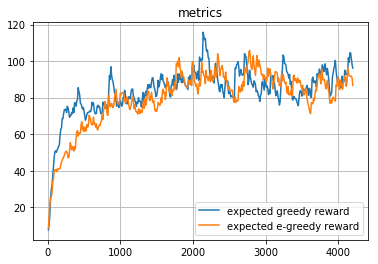

Random session examples


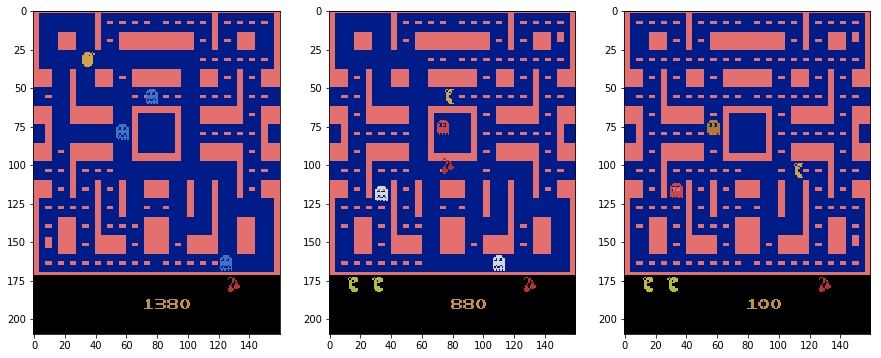

epoch 4210,loss 266.93168, epsilon 0.05668, rewards: ( e-greedy 82.60878, greedy 94.75507) 
rec 266.819 reg 0.113
epoch 4220,loss 916.80407, epsilon 0.05661, rewards: ( e-greedy 84.97290, greedy 95.40457) 
rec 916.691 reg 0.113
epoch 4230,loss 535.90821, epsilon 0.05655, rewards: ( e-greedy 88.10061, greedy 97.11411) 
rec 535.795 reg 0.113
epoch 4240,loss 748.28101, epsilon 0.05648, rewards: ( e-greedy 86.72805, greedy 97.40270) 
rec 748.168 reg 0.113
epoch 4250,loss 491.71477, epsilon 0.05642, rewards: ( e-greedy 87.05524, greedy 94.28743) 
rec 491.602 reg 0.113
epoch 4260,loss 626.30175, epsilon 0.05636, rewards: ( e-greedy 88.16222, greedy 94.85869) 
rec 626.189 reg 0.113
epoch 4270,loss 6425.49116, epsilon 0.05629, rewards: ( e-greedy 97.22100, greedy 92.68532) 
rec 6425.378 reg 0.113
epoch 4280,loss 3851.39995, epsilon 0.05623, rewards: ( e-greedy 103.12390, greedy 88.22929) 
rec 3851.287 reg 0.113
epoch 4290,loss 285.44542, epsilon 0.05617, rewards: ( e-greedy 98.06151, greedy 86

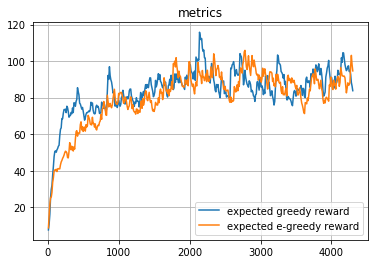

Random session examples


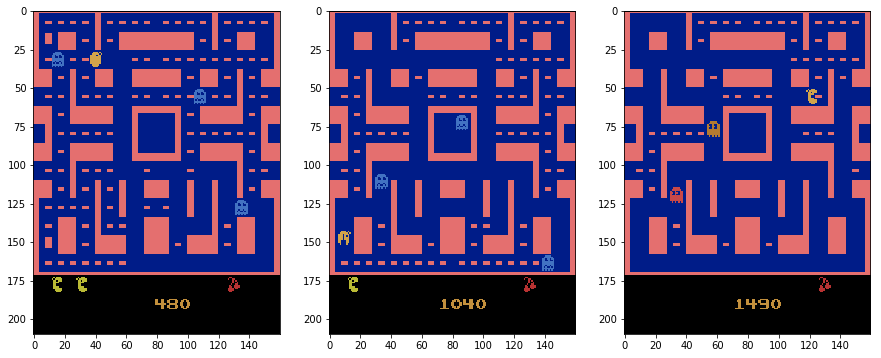

epoch 4310,loss 4404.40115, epsilon 0.05605, rewards: ( e-greedy 99.54232, greedy 83.46290) 
rec 4404.288 reg 0.113
epoch 4320,loss 442.44355, epsilon 0.05598, rewards: ( e-greedy 98.21309, greedy 83.24161) 
rec 442.330 reg 0.113
epoch 4330,loss 652.27120, epsilon 0.05593, rewards: ( e-greedy 97.45428, greedy 89.60495) 
rec 652.158 reg 0.113
epoch 4340,loss 488.98201, epsilon 0.05587, rewards: ( e-greedy 96.39635, greedy 92.01945) 
rec 488.869 reg 0.113
epoch 4350,loss 577.66823, epsilon 0.05581, rewards: ( e-greedy 95.63172, greedy 90.06751) 
rec 577.555 reg 0.113
epoch 4360,loss 278.67255, epsilon 0.05575, rewards: ( e-greedy 91.69355, greedy 94.56076) 
rec 278.559 reg 0.113
epoch 4370,loss 448.36140, epsilon 0.05569, rewards: ( e-greedy 89.02419, greedy 90.66718) 
rec 448.248 reg 0.113
epoch 4380,loss 452.28702, epsilon 0.05564, rewards: ( e-greedy 85.30927, greedy 92.16296) 
rec 452.174 reg 0.113
epoch 4390,loss 1968.05763, epsilon 0.05558, rewards: ( e-greedy 85.96584, greedy 86.9

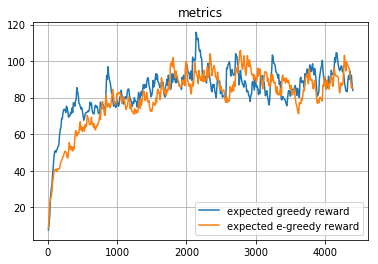

Random session examples


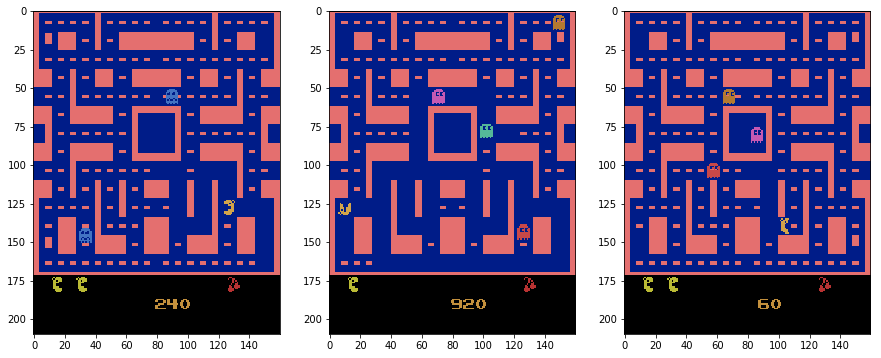

epoch 4410,loss 2138.84132, epsilon 0.05547, rewards: ( e-greedy 87.99483, greedy 84.17055) 
rec 2138.728 reg 0.114
epoch 4420,loss 337.34981, epsilon 0.05542, rewards: ( e-greedy 83.94535, greedy 80.62850) 
rec 337.236 reg 0.114
epoch 4430,loss 544.09449, epsilon 0.05536, rewards: ( e-greedy 83.55082, greedy 86.12815) 
rec 543.981 reg 0.114
epoch 4440,loss 621.21631, epsilon 0.05531, rewards: ( e-greedy 81.57073, greedy 82.20283) 
rec 621.103 reg 0.114
epoch 4450,loss 297.25554, epsilon 0.05526, rewards: ( e-greedy 77.91366, greedy 79.92005) 
rec 297.142 reg 0.114
epoch 4460,loss 809.55114, epsilon 0.05520, rewards: ( e-greedy 77.99729, greedy 80.80304) 
rec 809.438 reg 0.114
epoch 4470,loss 970.35678, epsilon 0.05515, rewards: ( e-greedy 83.32257, greedy 83.41024) 
rec 970.243 reg 0.114
epoch 4480,loss 275.60949, epsilon 0.05510, rewards: ( e-greedy 81.42781, greedy 88.00672) 
rec 275.496 reg 0.114
epoch 4490,loss 710.47626, epsilon 0.05505, rewards: ( e-greedy 81.03503, greedy 88.83

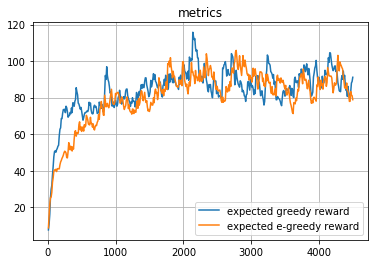

Random session examples


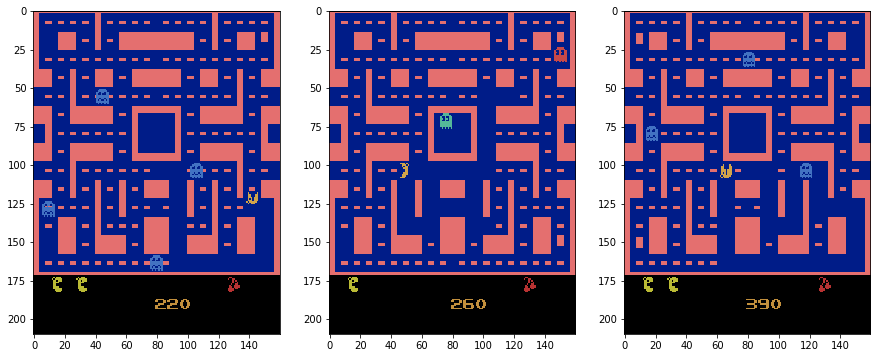

epoch 4510,loss 1538.82007, epsilon 0.05495, rewards: ( e-greedy 81.91962, greedy 91.83440) 
rec 1538.706 reg 0.114
epoch 4520,loss 3239.90698, epsilon 0.05490, rewards: ( e-greedy 89.35266, greedy 95.21346) 
rec 3239.793 reg 0.114
epoch 4530,loss 1467.50777, epsilon 0.05485, rewards: ( e-greedy 90.85489, greedy 98.06711) 
rec 1467.394 reg 0.114
epoch 4540,loss 545.18442, epsilon 0.05480, rewards: ( e-greedy 90.33190, greedy 92.19790) 
rec 545.071 reg 0.114
epoch 4550,loss 3279.92658, epsilon 0.05476, rewards: ( e-greedy 99.73621, greedy 88.91561) 
rec 3279.813 reg 0.114
epoch 4560,loss 2677.13718, epsilon 0.05471, rewards: ( e-greedy 104.63759, greedy 91.39905) 
rec 2677.023 reg 0.114
epoch 4570,loss 960.37954, epsilon 0.05466, rewards: ( e-greedy 105.54883, greedy 90.25914) 
rec 960.265 reg 0.114
epoch 4580,loss 609.19395, epsilon 0.05461, rewards: ( e-greedy 105.30645, greedy 88.98323) 
rec 609.080 reg 0.114
epoch 4590,loss 811.25214, epsilon 0.05457, rewards: ( e-greedy 104.02581, 

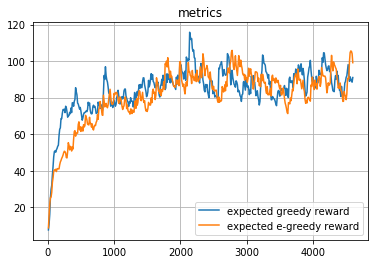

Random session examples


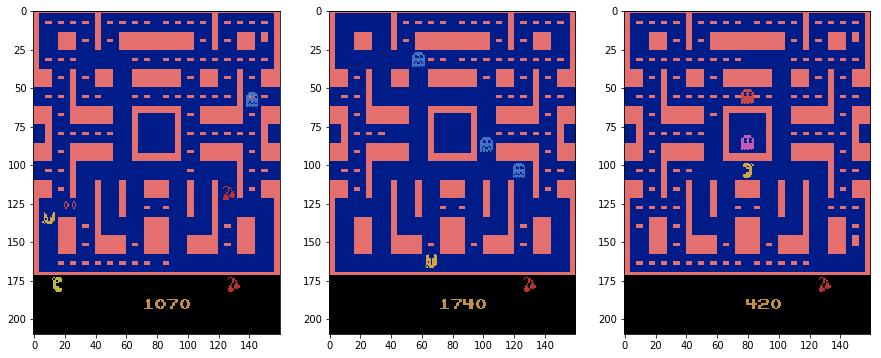

epoch 4610,loss 1516.96319, epsilon 0.05448, rewards: ( e-greedy 99.64840, greedy 89.45252) 
rec 1516.849 reg 0.114
epoch 4620,loss 2336.33404, epsilon 0.05443, rewards: ( e-greedy 102.12106, greedy 86.06977) 
rec 2336.220 reg 0.114
epoch 4630,loss 266.20426, epsilon 0.05439, rewards: ( e-greedy 95.47146, greedy 87.65029) 
rec 266.090 reg 0.114
epoch 4640,loss 425.35846, epsilon 0.05435, rewards: ( e-greedy 94.11181, greedy 87.76027) 
rec 425.244 reg 0.114
epoch 4650,loss 528.72737, epsilon 0.05430, rewards: ( e-greedy 93.51313, greedy 88.17174) 
rec 528.613 reg 0.114
epoch 4660,loss 6942.35023, epsilon 0.05426, rewards: ( e-greedy 103.16182, greedy 86.85456) 
rec 6942.236 reg 0.114
epoch 4670,loss 529.25440, epsilon 0.05422, rewards: ( e-greedy 99.22063, greedy 86.41911) 
rec 529.140 reg 0.115
epoch 4680,loss 547.24295, epsilon 0.05418, rewards: ( e-greedy 97.61107, greedy 85.71470) 
rec 547.128 reg 0.115
epoch 4690,loss 4031.53452, epsilon 0.05413, rewards: ( e-greedy 100.41246, gree

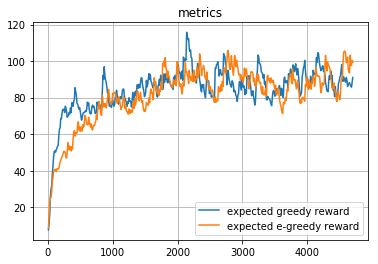

Random session examples


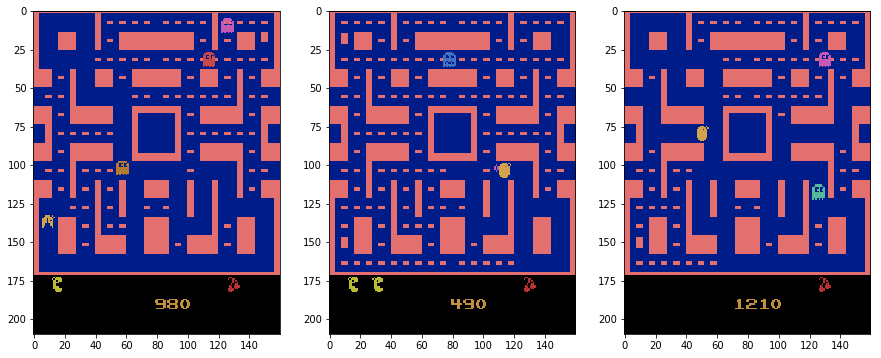

epoch 4710,loss 2246.98354, epsilon 0.05405, rewards: ( e-greedy 104.24660, greedy 86.86914) 
rec 2246.869 reg 0.115
epoch 4720,loss 2499.77280, epsilon 0.05401, rewards: ( e-greedy 107.38444, greedy 83.49473) 
rec 2499.658 reg 0.115
epoch 4730,loss 673.57829, epsilon 0.05397, rewards: ( e-greedy 106.39599, greedy 81.58275) 
rec 673.464 reg 0.115
epoch 4740,loss 325.61184, epsilon 0.05393, rewards: ( e-greedy 100.31889, greedy 85.73698) 
rec 325.497 reg 0.114
epoch 4750,loss 335.37415, epsilon 0.05389, rewards: ( e-greedy 94.03700, greedy 82.91328) 
rec 335.260 reg 0.114
epoch 4760,loss 1292.17903, epsilon 0.05385, rewards: ( e-greedy 94.50830, greedy 79.80945) 
rec 1292.064 reg 0.115
epoch 4770,loss 1405.88932, epsilon 0.05382, rewards: ( e-greedy 91.68247, greedy 76.64101) 
rec 1405.774 reg 0.115
epoch 4780,loss 640.13236, epsilon 0.05378, rewards: ( e-greedy 88.45173, greedy 76.47691) 
rec 640.017 reg 0.115
epoch 4790,loss 701.10083, epsilon 0.05374, rewards: ( e-greedy 89.60655, gr

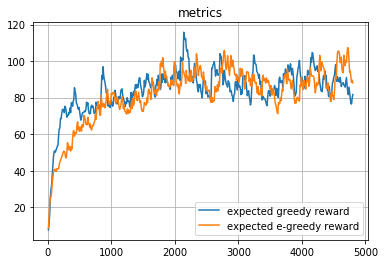

Random session examples


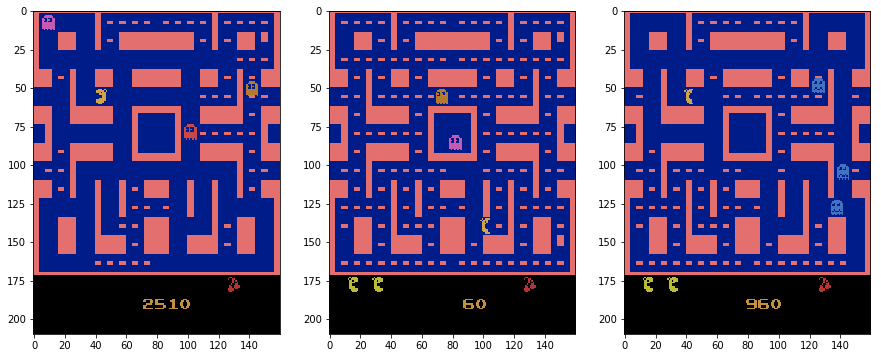

epoch 4810,loss 714.25812, epsilon 0.05367, rewards: ( e-greedy 91.15006, greedy 86.07791) 
rec 714.143 reg 0.115
epoch 4820,loss 1005.31393, epsilon 0.05363, rewards: ( e-greedy 91.78505, greedy 85.65762) 
rec 1005.199 reg 0.115
epoch 4830,loss 493.82582, epsilon 0.05359, rewards: ( e-greedy 90.54405, greedy 83.71686) 
rec 493.711 reg 0.115
epoch 4840,loss 450.44442, epsilon 0.05356, rewards: ( e-greedy 87.30214, greedy 83.84517) 
rec 450.329 reg 0.115
epoch 4850,loss 1488.80155, epsilon 0.05352, rewards: ( e-greedy 90.63443, greedy 84.89816) 
rec 1488.686 reg 0.115
epoch 4860,loss 1723.29042, epsilon 0.05349, rewards: ( e-greedy 92.07099, greedy 89.03334) 
rec 1723.175 reg 0.115
epoch 4870,loss 896.98632, epsilon 0.05345, rewards: ( e-greedy 91.05139, greedy 89.44251) 
rec 896.871 reg 0.115
epoch 4880,loss 5082.98638, epsilon 0.05342, rewards: ( e-greedy 101.32125, greedy 94.99826) 
rec 5082.871 reg 0.115
epoch 4890,loss 1099.64496, epsilon 0.05338, rewards: ( e-greedy 101.31412, gre

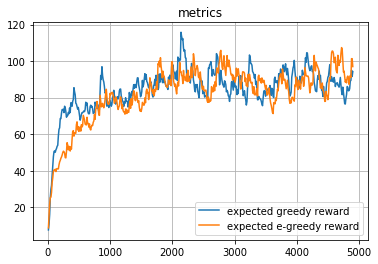

Random session examples


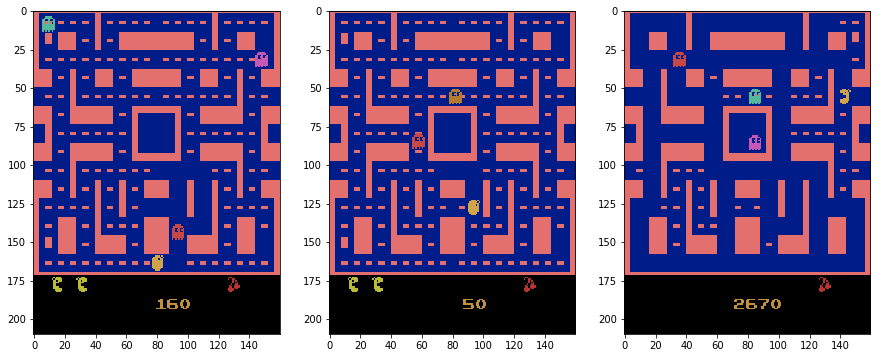

epoch 4910,loss 492.51704, epsilon 0.05332, rewards: ( e-greedy 93.04569, greedy 93.79560) 
rec 492.402 reg 0.115
epoch 4920,loss 718.03480, epsilon 0.05328, rewards: ( e-greedy 91.61612, greedy 95.79104) 
rec 717.920 reg 0.115
epoch 4930,loss 1555.19411, epsilon 0.05325, rewards: ( e-greedy 95.20451, greedy 96.27444) 
rec 1555.079 reg 0.115
epoch 4940,loss 288.51310, epsilon 0.05322, rewards: ( e-greedy 91.05906, greedy 92.83450) 
rec 288.398 reg 0.115
epoch 4950,loss 2585.41315, epsilon 0.05319, rewards: ( e-greedy 96.39065, greedy 95.55105) 
rec 2585.298 reg 0.115
epoch 4960,loss 351.91227, epsilon 0.05316, rewards: ( e-greedy 92.12659, greedy 95.74594) 
rec 351.797 reg 0.115
epoch 4970,loss 295.22130, epsilon 0.05312, rewards: ( e-greedy 87.53893, greedy 94.67135) 
rec 295.106 reg 0.115
epoch 4980,loss 756.62372, epsilon 0.05309, rewards: ( e-greedy 88.34754, greedy 97.45421) 
rec 756.508 reg 0.115
epoch 4990,loss 597.78935, epsilon 0.05306, rewards: ( e-greedy 86.95028, greedy 98.

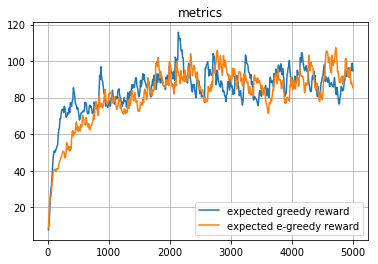

Random session examples


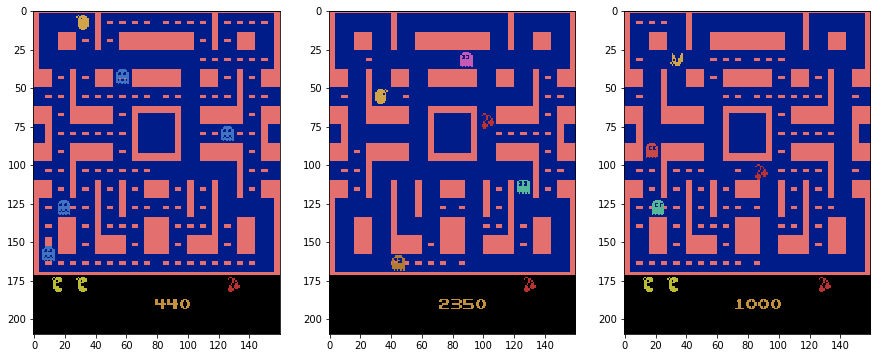

[2017-05-24 18:03:31,895] Making new env: MsPacman-v0
[2017-05-24 18:03:32,059] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 18:03:32,068] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.12.19270.video000000.mp4
[2017-05-24 18:03:34,376] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.12.19270.video000001.mp4


Episode finished after 964 timesteps with reward=240.0
Episode finished after 953 timesteps with reward=440.0
Episode finished after 693 timesteps with reward=110.0
Episode finished after 874 timesteps with reward=330.0
Episode finished after 1311 timesteps with reward=240.0
Episode finished after 886 timesteps with reward=240.0
Episode finished after 924 timesteps with reward=240.0


[2017-05-24 18:03:46,559] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.12.19270.video000008.mp4


Episode finished after 813 timesteps with reward=440.0
Episode finished after 1042 timesteps with reward=450.0
Episode finished after 1132 timesteps with reward=850.0
Episode finished after 776 timesteps with reward=520.0
Episode finished after 1011 timesteps with reward=850.0
Episode finished after 1093 timesteps with reward=440.0
Episode finished after 805 timesteps with reward=330.0
Episode finished after 868 timesteps with reward=240.0
Episode finished after 905 timesteps with reward=840.0
Episode finished after 862 timesteps with reward=440.0
Episode finished after 1210 timesteps with reward=250.0
Episode finished after 1053 timesteps with reward=320.0


[2017-05-24 18:04:08,388] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 948 timesteps with reward=440.0
Mean 412.5, Var 43558.75
epoch 5010,loss 2468.05827, epsilon 0.05300, rewards: ( e-greedy 90.20473, greedy 97.29912) 
rec 2467.943 reg 0.115
epoch 5020,loss 366.47134, epsilon 0.05297, rewards: ( e-greedy 90.18426, greedy 95.81921) 
rec 366.356 reg 0.115
epoch 5030,loss 385.25198, epsilon 0.05294, rewards: ( e-greedy 88.66583, greedy 98.11229) 
rec 385.137 reg 0.115
epoch 5040,loss 556.77272, epsilon 0.05291, rewards: ( e-greedy 87.92425, greedy 96.86356) 
rec 556.657 reg 0.115
epoch 5050,loss 700.99639, epsilon 0.05288, rewards: ( e-greedy 87.63182, greedy 92.92720) 
rec 700.881 reg 0.115
epoch 5060,loss 669.36967, epsilon 0.05286, rewards: ( e-greedy 87.18114, greedy 109.13448) 
rec 669.254 reg 0.115
epoch 5070,loss 546.95102, epsilon 0.05283, rewards: ( e-greedy 90.65053, greedy 105.15853) 
rec 546.836 reg 0.115
epoch 5080,loss 1915.64537, epsilon 0.05280, rewards: ( e-greedy 93.46047, greedy 101.83018) 
rec 1915.530 reg 0.115
e

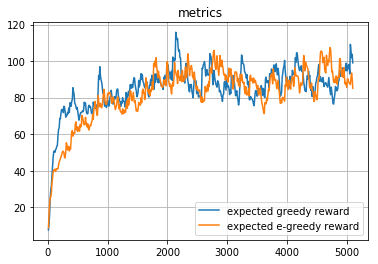

Random session examples


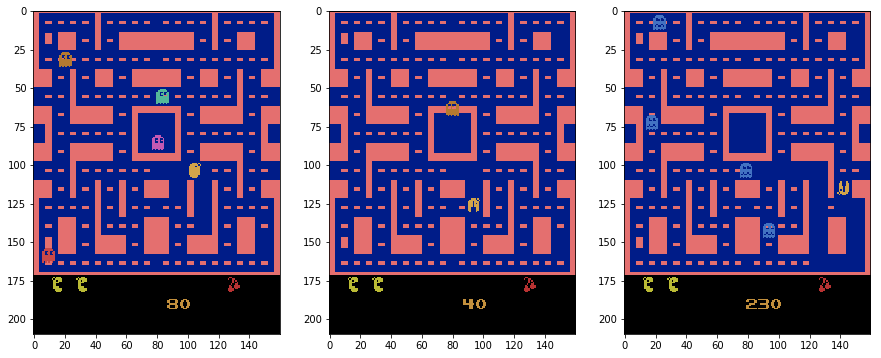

epoch 5110,loss 334.03317, epsilon 0.05272, rewards: ( e-greedy 83.92769, greedy 104.18608) 
rec 333.917 reg 0.116
epoch 5120,loss 1058.42221, epsilon 0.05269, rewards: ( e-greedy 86.22242, greedy 108.01747) 
rec 1058.306 reg 0.116
epoch 5130,loss 345.57217, epsilon 0.05266, rewards: ( e-greedy 83.28767, greedy 106.27822) 
rec 345.456 reg 0.116
epoch 5140,loss 1126.73208, epsilon 0.05264, rewards: ( e-greedy 91.83391, greedy 110.46290) 
rec 1126.616 reg 0.116
epoch 5150,loss 1666.08947, epsilon 0.05261, rewards: ( e-greedy 93.08802, greedy 116.79161) 
rec 1665.974 reg 0.116
epoch 5160,loss 286.79009, epsilon 0.05258, rewards: ( e-greedy 88.59172, greedy 115.48745) 
rec 286.674 reg 0.116
epoch 5170,loss 6160.52458, epsilon 0.05256, rewards: ( e-greedy 98.17004, greedy 111.50120) 
rec 6160.409 reg 0.116
epoch 5180,loss 459.74816, epsilon 0.05253, rewards: ( e-greedy 98.54054, greedy 112.47608) 
rec 459.632 reg 0.116
epoch 5190,loss 612.00671, epsilon 0.05251, rewards: ( e-greedy 97.56149

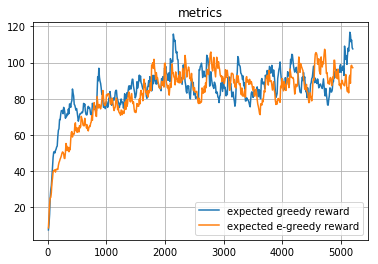

Random session examples


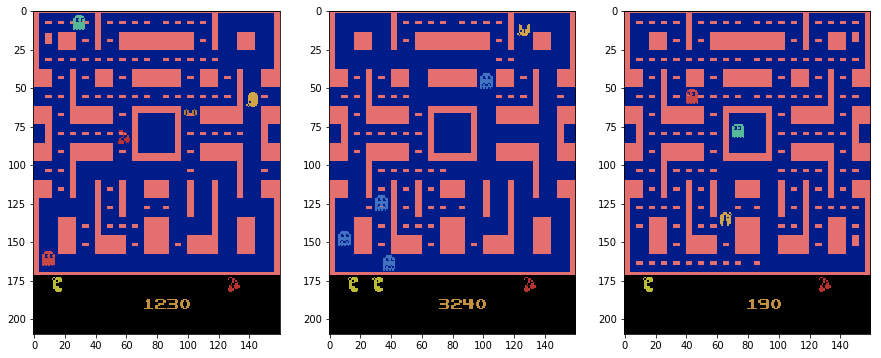

epoch 5210,loss 1081.73659, epsilon 0.05246, rewards: ( e-greedy 98.46230, greedy 116.58944) 
rec 1081.621 reg 0.116
epoch 5220,loss 306.40191, epsilon 0.05243, rewards: ( e-greedy 95.11607, greedy 111.43050) 
rec 306.286 reg 0.116
epoch 5230,loss 505.50201, epsilon 0.05241, rewards: ( e-greedy 95.97947, greedy 111.72495) 
rec 505.386 reg 0.116
epoch 5240,loss 582.75751, epsilon 0.05239, rewards: ( e-greedy 93.69402, greedy 105.48995) 
rec 582.642 reg 0.116
epoch 5250,loss 6703.38236, epsilon 0.05236, rewards: ( e-greedy 100.07462, greedy 106.00346) 
rec 6703.267 reg 0.116
epoch 5260,loss 543.39712, epsilon 0.05234, rewards: ( e-greedy 97.37966, greedy 103.52811) 
rec 543.281 reg 0.116
epoch 5270,loss 783.24528, epsilon 0.05231, rewards: ( e-greedy 98.70419, greedy 102.92530) 
rec 783.129 reg 0.116
epoch 5280,loss 1730.07754, epsilon 0.05229, rewards: ( e-greedy 97.27127, greedy 97.88277) 
rec 1729.961 reg 0.116
epoch 5290,loss 370.67093, epsilon 0.05227, rewards: ( e-greedy 95.29414, 

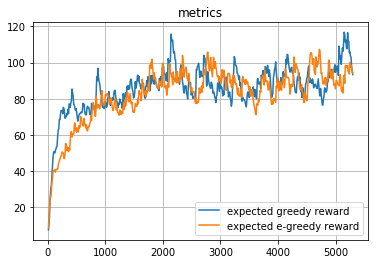

Random session examples


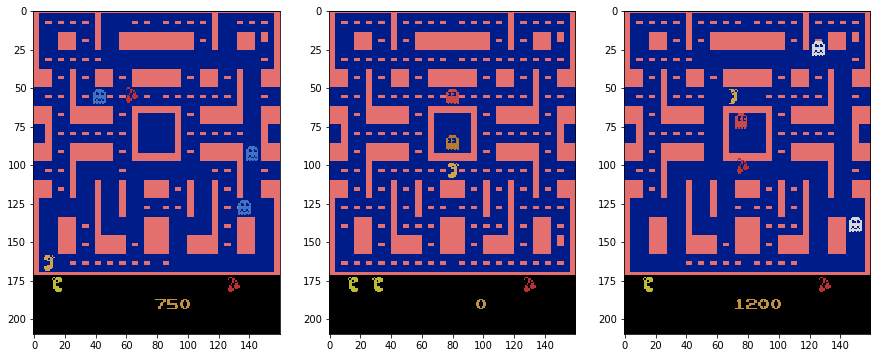

epoch 5310,loss 733.79805, epsilon 0.05222, rewards: ( e-greedy 96.20701, greedy 93.09216) 
rec 733.681 reg 0.117
epoch 5320,loss 1837.45471, epsilon 0.05220, rewards: ( e-greedy 96.33631, greedy 90.03295) 
rec 1837.338 reg 0.117
epoch 5330,loss 464.63115, epsilon 0.05218, rewards: ( e-greedy 92.32768, greedy 85.90465) 
rec 464.514 reg 0.117
epoch 5340,loss 292.77257, epsilon 0.05216, rewards: ( e-greedy 85.09491, greedy 83.93919) 
rec 292.656 reg 0.117
epoch 5350,loss 645.12083, epsilon 0.05214, rewards: ( e-greedy 84.83542, greedy 84.10777) 
rec 645.004 reg 0.117
epoch 5360,loss 776.84720, epsilon 0.05212, rewards: ( e-greedy 85.16438, greedy 84.25949) 
rec 776.730 reg 0.117
epoch 5370,loss 862.75267, epsilon 0.05209, rewards: ( e-greedy 85.71044, greedy 80.45854) 
rec 862.636 reg 0.117
epoch 5380,loss 643.54427, epsilon 0.05207, rewards: ( e-greedy 84.20189, greedy 81.60019) 
rec 643.428 reg 0.117
epoch 5390,loss 389.66765, epsilon 0.05205, rewards: ( e-greedy 81.40670, greedy 85.94

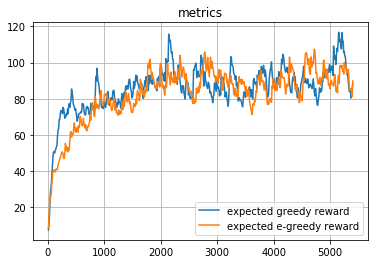

Random session examples


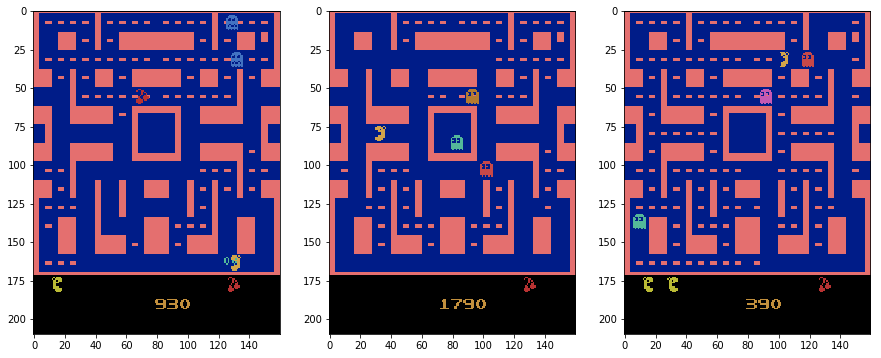

epoch 5410,loss 558.82146, epsilon 0.05201, rewards: ( e-greedy 90.46443, greedy 90.09904) 
rec 558.705 reg 0.117
epoch 5420,loss 2452.99880, epsilon 0.05199, rewards: ( e-greedy 95.98049, greedy 93.71413) 
rec 2452.882 reg 0.117
epoch 5430,loss 319.89344, epsilon 0.05197, rewards: ( e-greedy 90.19494, greedy 88.28022) 
rec 319.776 reg 0.117
epoch 5440,loss 307.94457, epsilon 0.05195, rewards: ( e-greedy 87.48794, greedy 89.51470) 
rec 307.828 reg 0.117
epoch 5450,loss 324.55467, epsilon 0.05193, rewards: ( e-greedy 85.23915, greedy 90.62573) 
rec 324.438 reg 0.117
epoch 5460,loss 1929.17235, epsilon 0.05191, rewards: ( e-greedy 89.52774, greedy 87.25066) 
rec 1929.056 reg 0.117
epoch 5470,loss 912.21002, epsilon 0.05190, rewards: ( e-greedy 90.94996, greedy 89.90059) 
rec 912.093 reg 0.117
epoch 5480,loss 1280.06150, epsilon 0.05188, rewards: ( e-greedy 94.10497, greedy 90.09803) 
rec 1279.945 reg 0.117
epoch 5490,loss 306.52672, epsilon 0.05186, rewards: ( e-greedy 90.94447, greedy 8

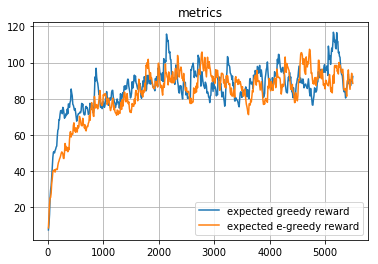

Random session examples


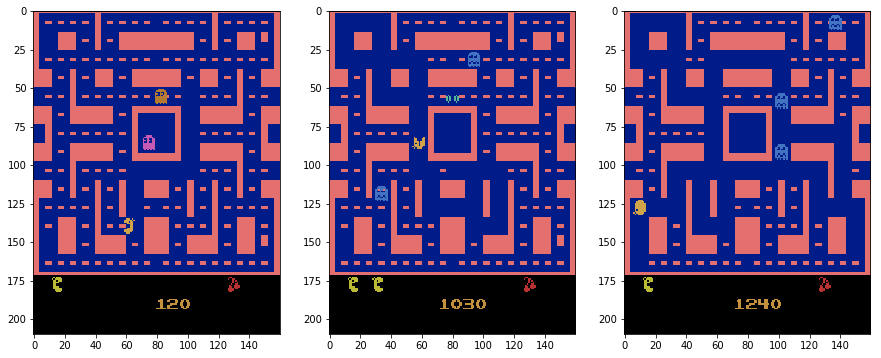

epoch 5510,loss 276.78356, epsilon 0.05182, rewards: ( e-greedy 85.80877, greedy 90.10771) 
rec 276.667 reg 0.117
epoch 5520,loss 255.24887, epsilon 0.05180, rewards: ( e-greedy 81.29039, greedy 88.15944) 
rec 255.132 reg 0.117
epoch 5530,loss 294.52715, epsilon 0.05178, rewards: ( e-greedy 76.78635, greedy 83.21850) 
rec 294.410 reg 0.117
epoch 5540,loss 664.64429, epsilon 0.05177, rewards: ( e-greedy 75.85772, greedy 79.83415) 
rec 664.527 reg 0.117
epoch 5550,loss 707.25437, epsilon 0.05175, rewards: ( e-greedy 77.77195, greedy 78.22573) 
rec 707.137 reg 0.117
epoch 5560,loss 285.00043, epsilon 0.05173, rewards: ( e-greedy 76.99475, greedy 90.34066) 
rec 284.883 reg 0.117
epoch 5570,loss 2089.58707, epsilon 0.05171, rewards: ( e-greedy 87.60778, greedy 95.49409) 
rec 2089.470 reg 0.117
epoch 5580,loss 252.51174, epsilon 0.05170, rewards: ( e-greedy 81.72200, greedy 92.13219) 
rec 252.395 reg 0.117
epoch 5590,loss 1239.96032, epsilon 0.05168, rewards: ( e-greedy 85.11230, greedy 91.4

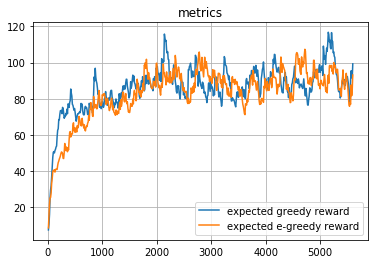

Random session examples


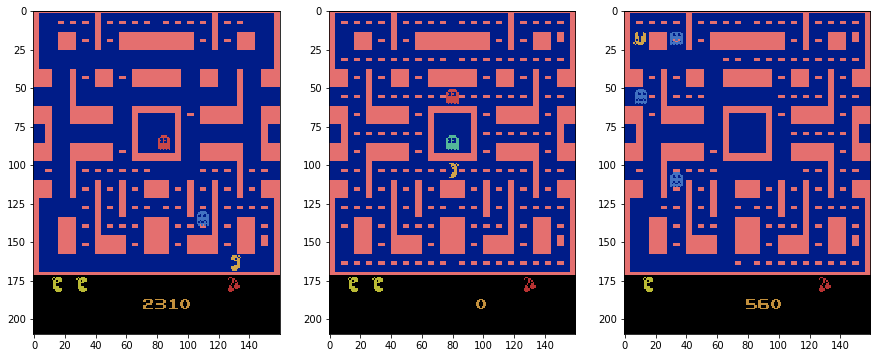

epoch 5610,loss 1854.77829, epsilon 0.05165, rewards: ( e-greedy 91.22221, greedy 96.59311) 
rec 1854.661 reg 0.117
epoch 5620,loss 1150.79530, epsilon 0.05163, rewards: ( e-greedy 94.78749, greedy 96.49630) 
rec 1150.678 reg 0.117
epoch 5630,loss 3581.67600, epsilon 0.05161, rewards: ( e-greedy 104.30874, greedy 100.97167) 
rec 3581.559 reg 0.117
epoch 5640,loss 839.70805, epsilon 0.05160, rewards: ( e-greedy 101.87787, greedy 98.37450) 
rec 839.591 reg 0.117
epoch 5650,loss 2017.83728, epsilon 0.05158, rewards: ( e-greedy 105.37758, greedy 95.28705) 
rec 2017.720 reg 0.118
epoch 5660,loss 314.07419, epsilon 0.05157, rewards: ( e-greedy 99.96482, greedy 93.32085) 
rec 313.957 reg 0.118
epoch 5670,loss 3359.44538, epsilon 0.05155, rewards: ( e-greedy 103.21834, greedy 96.30126) 
rec 3359.328 reg 0.118
epoch 5680,loss 538.15284, epsilon 0.05154, rewards: ( e-greedy 100.27151, greedy 93.60864) 
rec 538.035 reg 0.118
epoch 5690,loss 1055.48261, epsilon 0.05152, rewards: ( e-greedy 100.056

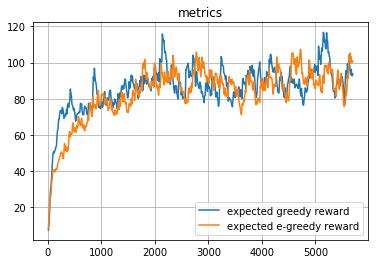

Random session examples


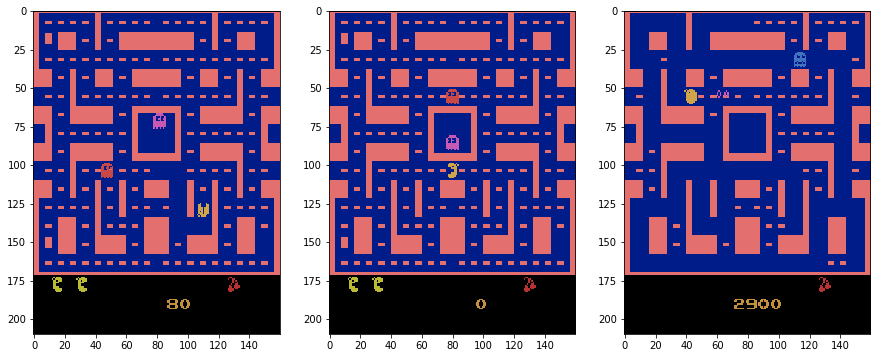

epoch 5710,loss 717.51408, epsilon 0.05149, rewards: ( e-greedy 102.16480, greedy 95.41257) 
rec 717.397 reg 0.117
epoch 5720,loss 1428.69527, epsilon 0.05148, rewards: ( e-greedy 102.88582, greedy 97.12131) 
rec 1428.578 reg 0.117
epoch 5730,loss 862.34476, epsilon 0.05146, rewards: ( e-greedy 101.47224, greedy 103.78418) 
rec 862.227 reg 0.117
epoch 5740,loss 1021.81965, epsilon 0.05145, rewards: ( e-greedy 98.82502, greedy 103.09326) 
rec 1021.702 reg 0.118
epoch 5750,loss 1239.76365, epsilon 0.05143, rewards: ( e-greedy 102.63001, greedy 99.15894) 
rec 1239.646 reg 0.118
epoch 5760,loss 2026.86346, epsilon 0.05142, rewards: ( e-greedy 104.05451, greedy 97.18054) 
rec 2026.746 reg 0.118
epoch 5770,loss 370.53015, epsilon 0.05140, rewards: ( e-greedy 99.39906, greedy 93.64999) 
rec 370.412 reg 0.118
epoch 5780,loss 481.25947, epsilon 0.05139, rewards: ( e-greedy 94.58416, greedy 94.97249) 
rec 481.142 reg 0.118
epoch 5790,loss 377.61306, epsilon 0.05138, rewards: ( e-greedy 91.25074,

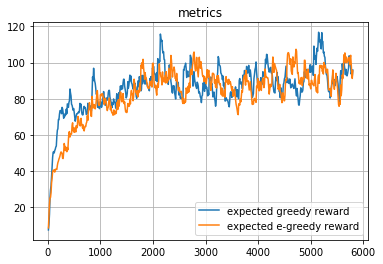

Random session examples


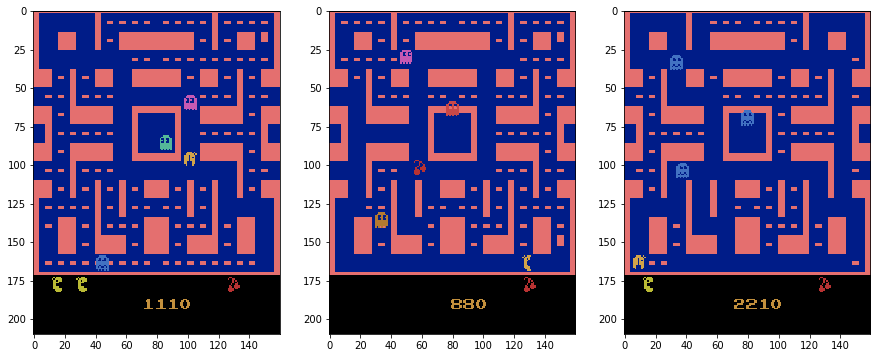

epoch 5810,loss 276.52245, epsilon 0.05135, rewards: ( e-greedy 89.51935, greedy 95.76682) 
rec 276.405 reg 0.118
epoch 5820,loss 301.23358, epsilon 0.05134, rewards: ( e-greedy 87.25491, greedy 93.62764) 
rec 301.116 reg 0.118
epoch 5830,loss 342.29297, epsilon 0.05132, rewards: ( e-greedy 86.52942, greedy 97.07737) 
rec 342.175 reg 0.118
epoch 5840,loss 513.25030, epsilon 0.05131, rewards: ( e-greedy 86.12648, greedy 96.74464) 
rec 513.133 reg 0.118
epoch 5850,loss 330.68300, epsilon 0.05130, rewards: ( e-greedy 84.26383, greedy 91.38267) 
rec 330.565 reg 0.118
epoch 5860,loss 682.38595, epsilon 0.05128, rewards: ( e-greedy 87.14995, greedy 90.93191) 
rec 682.268 reg 0.118
epoch 5870,loss 703.80384, epsilon 0.05127, rewards: ( e-greedy 84.37245, greedy 97.83872) 
rec 703.686 reg 0.118
epoch 5880,loss 5025.12539, epsilon 0.05126, rewards: ( e-greedy 91.81021, greedy 101.24234) 
rec 5025.008 reg 0.118
epoch 5890,loss 1696.52177, epsilon 0.05125, rewards: ( e-greedy 96.12919, greedy 104

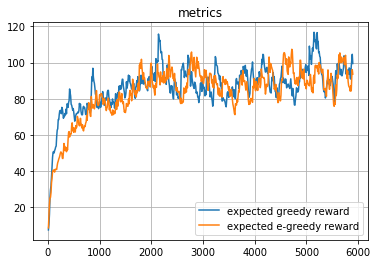

Random session examples


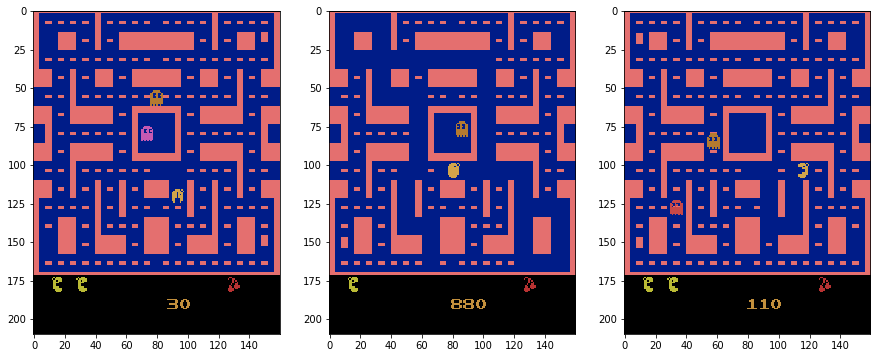

epoch 5910,loss 417.88054, epsilon 0.05122, rewards: ( e-greedy 90.27714, greedy 97.14067) 
rec 417.763 reg 0.118
epoch 5920,loss 651.50619, epsilon 0.05121, rewards: ( e-greedy 88.12443, greedy 95.48910) 
rec 651.388 reg 0.118
epoch 5930,loss 515.48854, epsilon 0.05120, rewards: ( e-greedy 87.56199, greedy 99.75269) 
rec 515.371 reg 0.118
epoch 5940,loss 2185.07061, epsilon 0.05118, rewards: ( e-greedy 94.61829, greedy 92.90242) 
rec 2184.953 reg 0.118
epoch 5950,loss 1274.97502, epsilon 0.05117, rewards: ( e-greedy 97.46896, greedy 94.48718) 
rec 1274.857 reg 0.118
epoch 5960,loss 2674.56393, epsilon 0.05116, rewards: ( e-greedy 103.34706, greedy 109.35096) 
rec 2674.446 reg 0.118
epoch 5970,loss 262.46889, epsilon 0.05115, rewards: ( e-greedy 96.63736, greedy 102.97837) 
rec 262.351 reg 0.118
epoch 5980,loss 340.61877, epsilon 0.05114, rewards: ( e-greedy 90.78612, greedy 107.18053) 
rec 340.501 reg 0.118
epoch 5990,loss 1525.67713, epsilon 0.05113, rewards: ( e-greedy 93.39501, gre

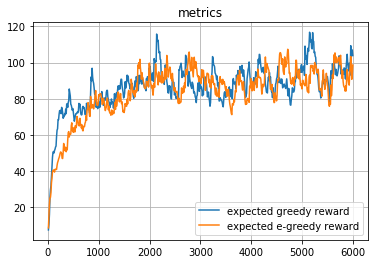

Random session examples


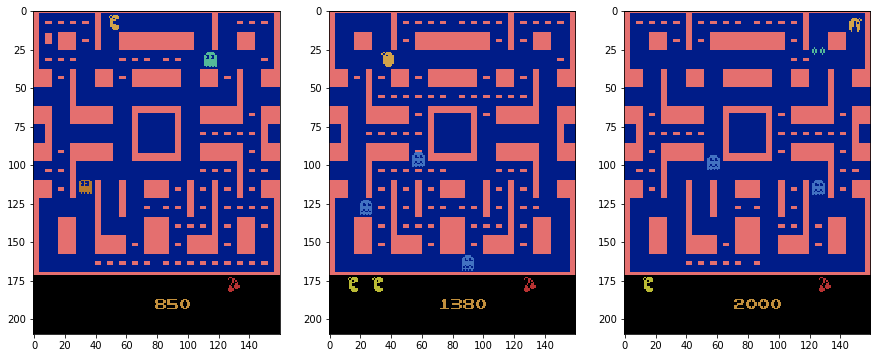

[2017-05-24 18:29:41,372] Making new env: MsPacman-v0
[2017-05-24 18:29:41,535] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 18:29:41,543] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.13.19270.video000000.mp4
[2017-05-24 18:29:43,814] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.13.19270.video000001.mp4


Episode finished after 950 timesteps with reward=240.0
Episode finished after 641 timesteps with reward=190.0
Episode finished after 730 timesteps with reward=240.0
Episode finished after 764 timesteps with reward=300.0
Episode finished after 699 timesteps with reward=280.0
Episode finished after 706 timesteps with reward=220.0
Episode finished after 554 timesteps with reward=280.0


[2017-05-24 18:29:52,592] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.13.19270.video000008.mp4


Episode finished after 548 timesteps with reward=140.0
Episode finished after 756 timesteps with reward=250.0
Episode finished after 610 timesteps with reward=240.0
Episode finished after 636 timesteps with reward=310.0
Episode finished after 605 timesteps with reward=240.0
Episode finished after 675 timesteps with reward=300.0
Episode finished after 839 timesteps with reward=240.0
Episode finished after 719 timesteps with reward=300.0
Episode finished after 750 timesteps with reward=190.0
Episode finished after 650 timesteps with reward=260.0
Episode finished after 644 timesteps with reward=240.0
Episode finished after 573 timesteps with reward=190.0


[2017-05-24 18:30:07,080] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 560 timesteps with reward=180.0
Mean 241.5, Var 2042.75
epoch 6010,loss 1016.64345, epsilon 0.05110, rewards: ( e-greedy 100.18746, greedy 105.34273) 
rec 1016.526 reg 0.118
epoch 6020,loss 235.96792, epsilon 0.05109, rewards: ( e-greedy 95.66871, greedy 106.99596) 
rec 235.850 reg 0.118
epoch 6030,loss 470.56817, epsilon 0.05108, rewards: ( e-greedy 94.53934, greedy 103.04636) 
rec 470.450 reg 0.118
epoch 6040,loss 2825.27366, epsilon 0.05107, rewards: ( e-greedy 96.89791, greedy 112.05423) 
rec 2825.156 reg 0.118
epoch 6050,loss 4197.61068, epsilon 0.05106, rewards: ( e-greedy 103.27062, greedy 107.59880) 
rec 4197.493 reg 0.118
epoch 6060,loss 351.42834, epsilon 0.05105, rewards: ( e-greedy 96.31855, greedy 101.21392) 
rec 351.310 reg 0.118
epoch 6070,loss 455.76428, epsilon 0.05104, rewards: ( e-greedy 95.24920, greedy 100.65503) 
rec 455.646 reg 0.118
epoch 6080,loss 933.36297, epsilon 0.05103, rewards: ( e-greedy 101.34928, greedy 99.77703) 
rec 933.245 reg

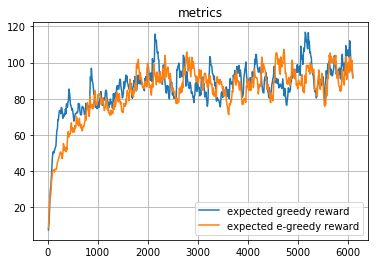

Random session examples


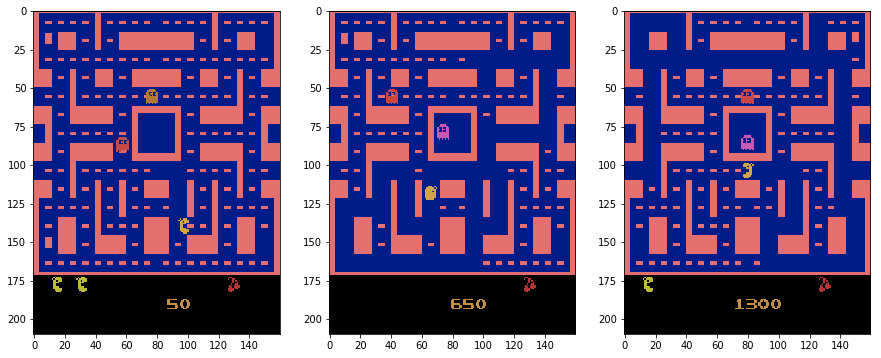

epoch 6110,loss 1369.83126, epsilon 0.05100, rewards: ( e-greedy 96.34237, greedy 91.29745) 
rec 1369.713 reg 0.118
epoch 6120,loss 1107.00464, epsilon 0.05099, rewards: ( e-greedy 95.64564, greedy 91.60521) 
rec 1106.886 reg 0.118
epoch 6130,loss 303.84488, epsilon 0.05098, rewards: ( e-greedy 90.51857, greedy 89.25719) 
rec 303.727 reg 0.118
epoch 6140,loss 336.31104, epsilon 0.05097, rewards: ( e-greedy 86.59172, greedy 92.70647) 
rec 336.193 reg 0.118
epoch 6150,loss 683.32271, epsilon 0.05096, rewards: ( e-greedy 83.37004, greedy 87.37332) 
rec 683.204 reg 0.118
epoch 6160,loss 669.75141, epsilon 0.05095, rewards: ( e-greedy 85.78304, greedy 88.63599) 
rec 669.633 reg 0.118
epoch 6170,loss 1127.73598, epsilon 0.05094, rewards: ( e-greedy 85.76724, greedy 92.20989) 
rec 1127.617 reg 0.119
epoch 6180,loss 743.46320, epsilon 0.05093, rewards: ( e-greedy 85.44051, greedy 89.42640) 
rec 743.345 reg 0.119
epoch 6190,loss 4121.41938, epsilon 0.05092, rewards: ( e-greedy 87.20896, greedy 

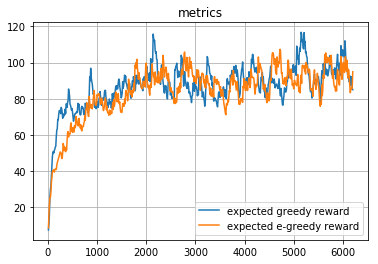

Random session examples


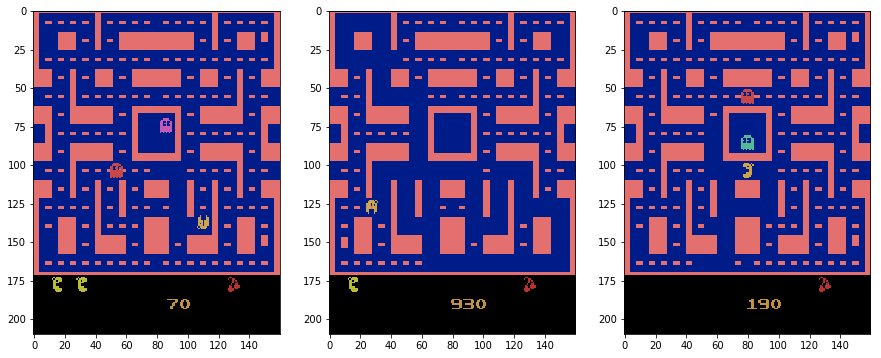

epoch 6210,loss 310.89856, epsilon 0.05090, rewards: ( e-greedy 89.67676, greedy 87.40122) 
rec 310.780 reg 0.119
epoch 6220,loss 1378.33088, epsilon 0.05090, rewards: ( e-greedy 92.77158, greedy 85.66110) 
rec 1378.212 reg 0.119
epoch 6230,loss 434.68957, epsilon 0.05089, rewards: ( e-greedy 89.36942, greedy 82.84499) 
rec 434.571 reg 0.119
epoch 6240,loss 932.14484, epsilon 0.05088, rewards: ( e-greedy 87.43248, greedy 89.18549) 
rec 932.026 reg 0.119
epoch 6250,loss 802.90959, epsilon 0.05087, rewards: ( e-greedy 88.25173, greedy 91.20444) 
rec 802.791 reg 0.119
epoch 6260,loss 993.04307, epsilon 0.05086, rewards: ( e-greedy 91.73906, greedy 93.02150) 
rec 992.924 reg 0.119
epoch 6270,loss 781.36221, epsilon 0.05085, rewards: ( e-greedy 92.62765, greedy 94.03185) 
rec 781.244 reg 0.119
epoch 6280,loss 562.11661, epsilon 0.05084, rewards: ( e-greedy 91.30239, greedy 90.81616) 
rec 561.998 reg 0.119
epoch 6290,loss 685.13408, epsilon 0.05083, rewards: ( e-greedy 90.67215, greedy 94.60

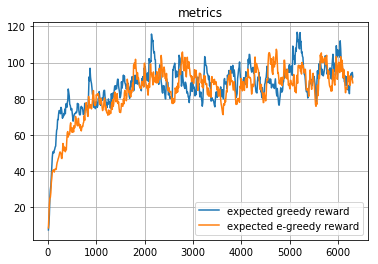

Random session examples


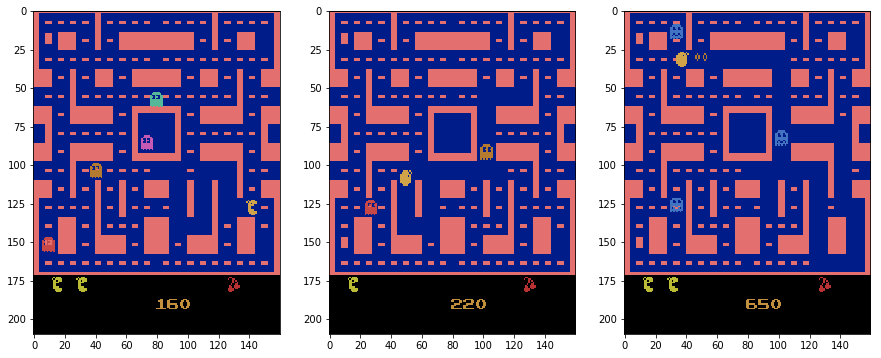

epoch 6310,loss 837.66149, epsilon 0.05082, rewards: ( e-greedy 91.15694, greedy 94.80873) 
rec 837.543 reg 0.119
epoch 6320,loss 695.43540, epsilon 0.05081, rewards: ( e-greedy 92.72875, greedy 101.14036) 
rec 695.317 reg 0.119
epoch 6330,loss 9779.22145, epsilon 0.05080, rewards: ( e-greedy 100.33087, greedy 108.96382) 
rec 9779.103 reg 0.119
epoch 8090,loss 348.77622, epsilon 0.05014, rewards: ( e-greedy 81.82807, greedy 93.24929) 
rec 348.654 reg 0.122
epoch 8100,loss 648.66502, epsilon 0.05014, rewards: ( e-greedy 82.08276, greedy 89.54936) 
rec 648.543 reg 0.122
Learning curves:


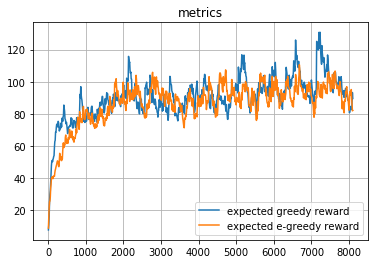

Random session examples


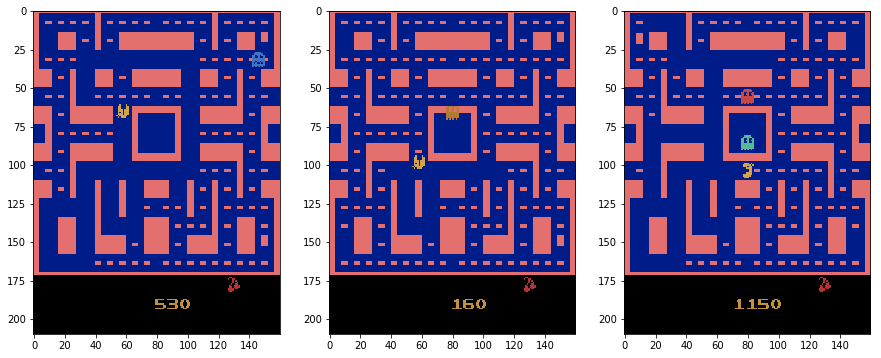

epoch 8110,loss 1052.06576, epsilon 0.05014, rewards: ( e-greedy 82.68699, greedy 88.09443) 
rec 1051.944 reg 0.122
epoch 8120,loss 605.47521, epsilon 0.05013, rewards: ( e-greedy 80.73079, greedy 83.47248) 
rec 605.353 reg 0.122
epoch 8130,loss 3377.35617, epsilon 0.05013, rewards: ( e-greedy 87.90771, greedy 79.93774) 
rec 3377.234 reg 0.122
epoch 8140,loss 480.56658, epsilon 0.05013, rewards: ( e-greedy 85.05444, greedy 78.56896) 
rec 480.444 reg 0.122
epoch 8150,loss 679.88478, epsilon 0.05013, rewards: ( e-greedy 85.36150, greedy 85.58707) 
rec 679.763 reg 0.122
epoch 8160,loss 10892.33133, epsilon 0.05013, rewards: ( e-greedy 102.63785, greedy 86.40336) 
rec 10892.209 reg 0.122
epoch 8170,loss 1437.90617, epsilon 0.05013, rewards: ( e-greedy 101.81156, greedy 86.01302) 
rec 1437.784 reg 0.122
epoch 8180,loss 292.36056, epsilon 0.05013, rewards: ( e-greedy 94.38041, greedy 85.22422) 
rec 292.238 reg 0.122
epoch 8190,loss 21239.51886, epsilon 0.05012, rewards: ( e-greedy 100.87986,

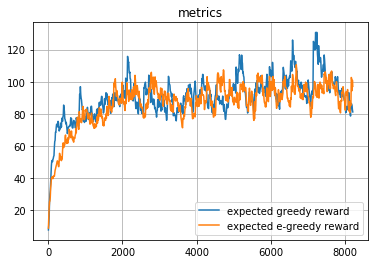

Random session examples


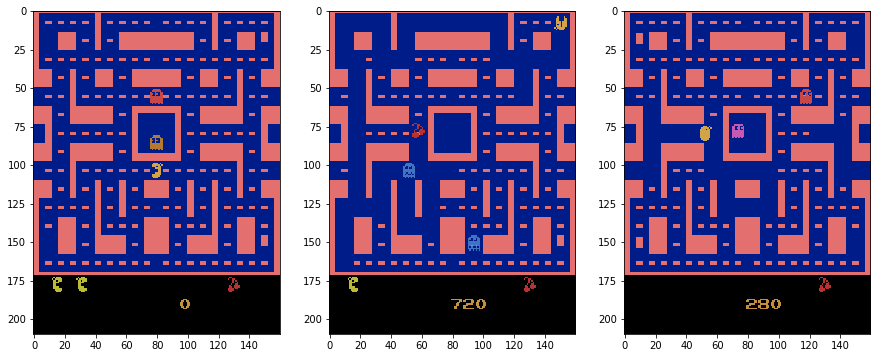

epoch 8210,loss 355.45616, epsilon 0.05012, rewards: ( e-greedy 94.33144, greedy 82.15471) 
rec 355.334 reg 0.122
epoch 8220,loss 2901.27400, epsilon 0.05012, rewards: ( e-greedy 99.58580, greedy 94.31424) 
rec 2901.152 reg 0.122
epoch 8230,loss 547.51572, epsilon 0.05012, rewards: ( e-greedy 98.81472, greedy 95.13281) 
rec 547.393 reg 0.122
epoch 8240,loss 21215.26697, epsilon 0.05012, rewards: ( e-greedy 112.68325, greedy 95.49453) 
rec 21215.145 reg 0.122
epoch 8250,loss 2539.78898, epsilon 0.05012, rewards: ( e-greedy 114.10242, greedy 93.07008) 
rec 2539.667 reg 0.122
epoch 8260,loss 1288.77890, epsilon 0.05012, rewards: ( e-greedy 111.87968, greedy 93.51307) 
rec 1288.656 reg 0.123
epoch 8270,loss 554.57545, epsilon 0.05012, rewards: ( e-greedy 109.25421, greedy 93.22426) 
rec 554.453 reg 0.123
epoch 8280,loss 286.88528, epsilon 0.05011, rewards: ( e-greedy 100.89129, greedy 90.83934) 
rec 286.763 reg 0.123
epoch 8290,loss 340.01449, epsilon 0.05011, rewards: ( e-greedy 96.73966,

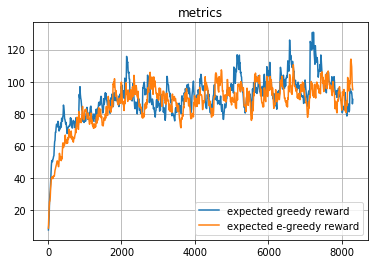

Random session examples


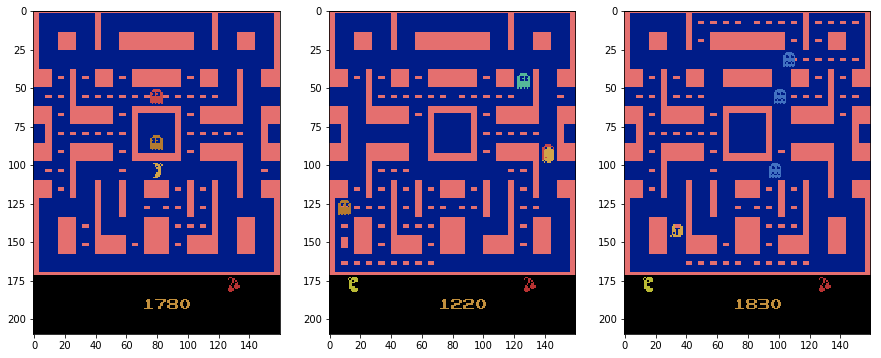

epoch 8310,loss 338.91782, epsilon 0.05011, rewards: ( e-greedy 92.56538, greedy 86.36625) 
rec 338.795 reg 0.123
epoch 8320,loss 1292.10561, epsilon 0.05011, rewards: ( e-greedy 90.74634, greedy 83.47963) 
rec 1291.983 reg 0.123
epoch 8440,loss 386.63854, epsilon 0.05010, rewards: ( e-greedy 74.36134, greedy 80.81693) 
rec 386.515 reg 0.123
epoch 8450,loss 3944.15555, epsilon 0.05010, rewards: ( e-greedy 79.05020, greedy 79.29774) 
rec 3944.032 reg 0.123
epoch 8460,loss 301.58219, epsilon 0.05010, rewards: ( e-greedy 75.14518, greedy 76.61796) 
rec 301.459 reg 0.123
epoch 8470,loss 1434.52827, epsilon 0.05009, rewards: ( e-greedy 77.31817, greedy 83.14367) 
rec 1434.405 reg 0.123
epoch 8480,loss 1541.69406, epsilon 0.05009, rewards: ( e-greedy 80.21135, greedy 91.82930) 
rec 1541.571 reg 0.123
epoch 8490,loss 1685.09725, epsilon 0.05009, rewards: ( e-greedy 83.87771, greedy 91.70887) 
rec 1684.974 reg 0.123
epoch 8500,loss 550.16004, epsilon 0.05009, rewards: ( e-greedy 86.36494, gree

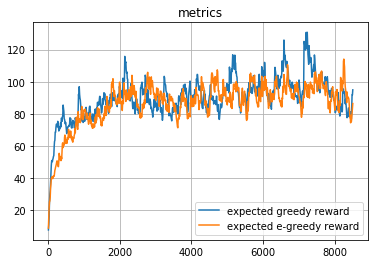

Random session examples


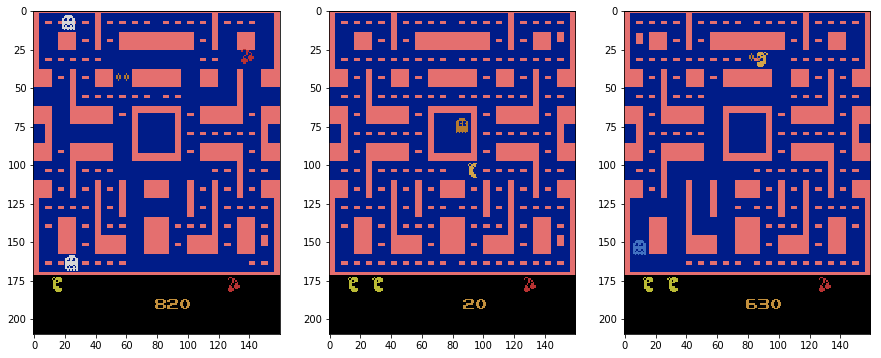

epoch 8510,loss 310.80080, epsilon 0.05009, rewards: ( e-greedy 83.41595, greedy 98.23419) 
rec 310.678 reg 0.123
epoch 8520,loss 876.93219, epsilon 0.05009, rewards: ( e-greedy 84.94935, greedy 99.16077) 
rec 876.809 reg 0.123
epoch 8530,loss 996.93505, epsilon 0.05009, rewards: ( e-greedy 88.07942, greedy 93.55719) 
rec 996.812 reg 0.123
epoch 8540,loss 1475.07642, epsilon 0.05009, rewards: ( e-greedy 93.33398, greedy 91.88897) 
rec 1474.953 reg 0.123
epoch 8550,loss 376.21058, epsilon 0.05009, rewards: ( e-greedy 90.81308, greedy 91.20007) 
rec 376.087 reg 0.123
epoch 8560,loss 666.10888, epsilon 0.05009, rewards: ( e-greedy 89.54427, greedy 94.76757) 
rec 665.986 reg 0.123
epoch 8570,loss 1568.13960, epsilon 0.05009, rewards: ( e-greedy 93.02734, greedy 98.54081) 
rec 1568.016 reg 0.123
epoch 8580,loss 1561.22366, epsilon 0.05008, rewards: ( e-greedy 93.47461, greedy 110.43673) 
rec 1561.100 reg 0.123
epoch 8590,loss 283.43794, epsilon 0.05008, rewards: ( e-greedy 89.18965, greedy 

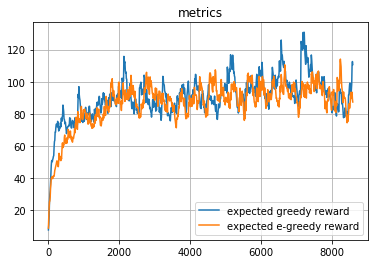

Random session examples


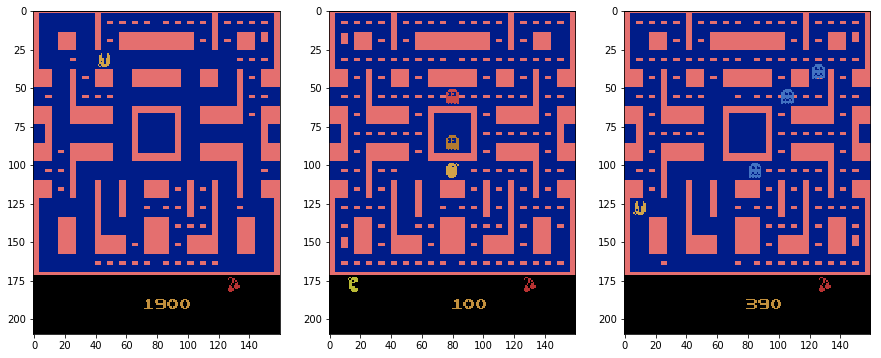

epoch 8610,loss 390.83810, epsilon 0.05008, rewards: ( e-greedy 84.66237, greedy 106.31525) 
rec 390.715 reg 0.123
epoch 8620,loss 1627.72103, epsilon 0.05008, rewards: ( e-greedy 84.13363, greedy 98.55873) 
rec 1627.598 reg 0.123
epoch 8630,loss 1328.14243, epsilon 0.05008, rewards: ( e-greedy 85.72027, greedy 95.20285) 
rec 1328.019 reg 0.123
epoch 8640,loss 404.80098, epsilon 0.05008, rewards: ( e-greedy 82.27324, greedy 91.99507) 
rec 404.678 reg 0.123
epoch 8650,loss 1134.93362, epsilon 0.05008, rewards: ( e-greedy 82.17092, greedy 89.79556) 
rec 1134.810 reg 0.123
epoch 8660,loss 2175.52872, epsilon 0.05008, rewards: ( e-greedy 85.89132, greedy 97.00350) 
rec 2175.405 reg 0.123
epoch 8670,loss 379.07177, epsilon 0.05008, rewards: ( e-greedy 84.98969, greedy 93.74065) 
rec 378.948 reg 0.123
epoch 8680,loss 3389.01540, epsilon 0.05008, rewards: ( e-greedy 87.30322, greedy 88.24159) 
rec 3388.892 reg 0.124
epoch 8690,loss 1855.03171, epsilon 0.05008, rewards: ( e-greedy 91.13540, gr

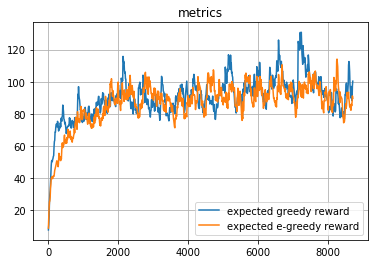

Random session examples


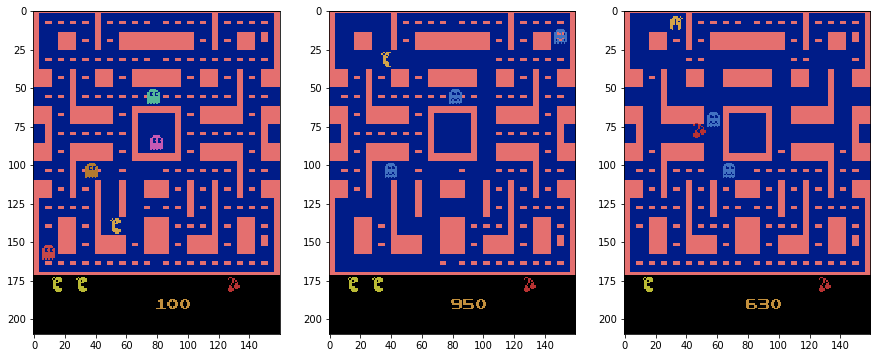

epoch 8710,loss 1044.59366, epsilon 0.05007, rewards: ( e-greedy 90.06342, greedy 104.49187) 
rec 1044.470 reg 0.124
epoch 8720,loss 2569.07092, epsilon 0.05007, rewards: ( e-greedy 94.24458, greedy 107.48018) 
rec 2568.947 reg 0.124
epoch 8730,loss 371.95150, epsilon 0.05007, rewards: ( e-greedy 91.07012, greedy 109.16966) 
rec 371.828 reg 0.124
epoch 8740,loss 1989.57773, epsilon 0.05007, rewards: ( e-greedy 92.77561, greedy 106.87770) 
rec 1989.454 reg 0.124
epoch 8750,loss 4556.01297, epsilon 0.05007, rewards: ( e-greedy 99.87305, greedy 109.50243) 
rec 4555.889 reg 0.124
epoch 8760,loss 399.05782, epsilon 0.05007, rewards: ( e-greedy 95.26075, greedy 112.11468) 
rec 398.934 reg 0.124
epoch 8770,loss 340.65240, epsilon 0.05007, rewards: ( e-greedy 90.85967, greedy 106.84072) 
rec 340.529 reg 0.124
epoch 8780,loss 2496.95629, epsilon 0.05007, rewards: ( e-greedy 94.83620, greedy 115.71914) 
rec 2496.833 reg 0.124
epoch 8790,loss 380.19099, epsilon 0.05007, rewards: ( e-greedy 91.977

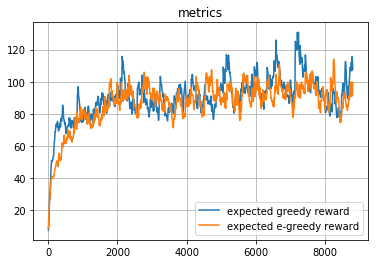

Random session examples


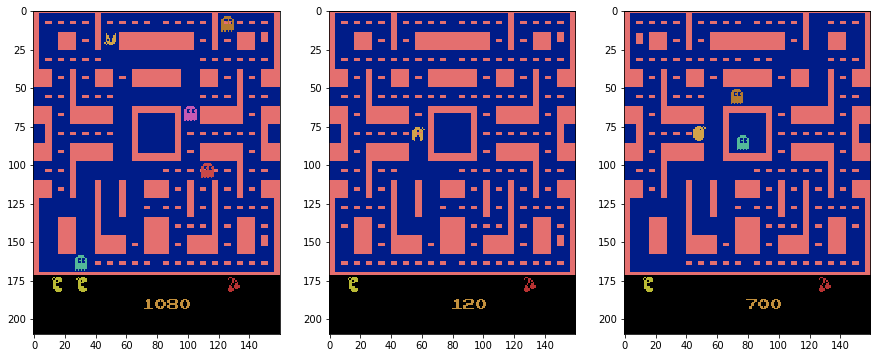

epoch 8810,loss 487.81276, epsilon 0.05007, rewards: ( e-greedy 98.20184, greedy 105.83738) 
rec 487.689 reg 0.124
epoch 8820,loss 1046.18703, epsilon 0.05007, rewards: ( e-greedy 98.69416, greedy 99.56614) 
rec 1046.063 reg 0.124
epoch 8830,loss 1072.95408, epsilon 0.05007, rewards: ( e-greedy 100.51224, greedy 95.48453) 
rec 1072.830 reg 0.124
epoch 8840,loss 1238.47844, epsilon 0.05007, rewards: ( e-greedy 95.83602, greedy 89.93608) 
rec 1238.354 reg 0.124
epoch 8850,loss 3209.12297, epsilon 0.05006, rewards: ( e-greedy 98.56492, greedy 91.94247) 
rec 3208.999 reg 0.124
epoch 8860,loss 680.05028, epsilon 0.05006, rewards: ( e-greedy 98.95842, greedy 92.49822) 
rec 679.926 reg 0.124
epoch 8870,loss 1040.32380, epsilon 0.05006, rewards: ( e-greedy 99.06258, greedy 91.12340) 
rec 1040.199 reg 0.124
epoch 8880,loss 2707.39102, epsilon 0.05006, rewards: ( e-greedy 101.46882, greedy 94.26106) 
rec 2707.267 reg 0.124
epoch 8890,loss 332.74950, epsilon 0.05006, rewards: ( e-greedy 94.25944,

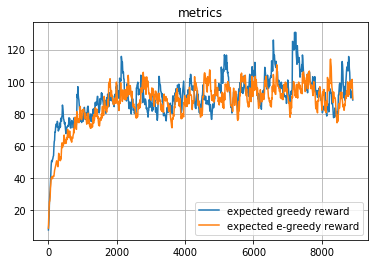

Random session examples


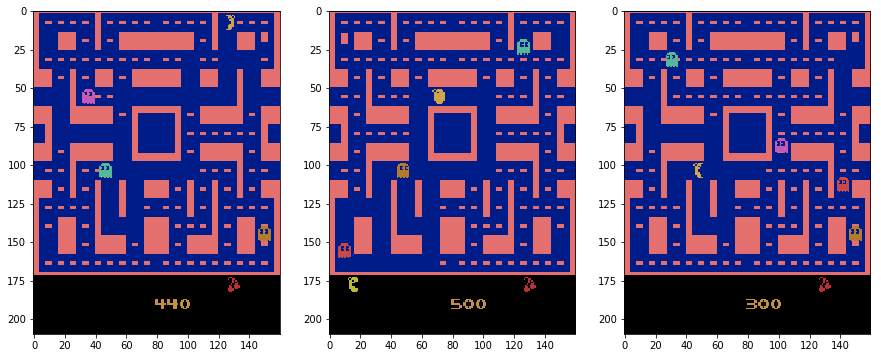

epoch 8910,loss 457.70298, epsilon 0.05006, rewards: ( e-greedy 86.59390, greedy 99.66756) 
rec 457.579 reg 0.124
epoch 8920,loss 1200.09186, epsilon 0.05006, rewards: ( e-greedy 87.49701, greedy 98.70081) 
rec 1199.967 reg 0.124
epoch 8930,loss 490.59025, epsilon 0.05006, rewards: ( e-greedy 85.37231, greedy 101.83073) 
rec 490.466 reg 0.125
epoch 8940,loss 1063.59639, epsilon 0.05006, rewards: ( e-greedy 88.21008, greedy 97.14765) 
rec 1063.472 reg 0.125
epoch 8950,loss 412.53558, epsilon 0.05006, rewards: ( e-greedy 87.70157, greedy 95.93289) 
rec 412.411 reg 0.125
epoch 8960,loss 735.30791, epsilon 0.05006, rewards: ( e-greedy 86.18141, greedy 91.90210) 
rec 735.183 reg 0.125
epoch 8970,loss 426.08093, epsilon 0.05006, rewards: ( e-greedy 83.25077, greedy 89.58689) 
rec 425.956 reg 0.125
epoch 8980,loss 642.20920, epsilon 0.05006, rewards: ( e-greedy 81.05069, greedy 88.62820) 
rec 642.084 reg 0.125
epoch 11540,loss 558.17575, epsilon 0.05000, rewards: ( e-greedy 90.80563, greedy 1

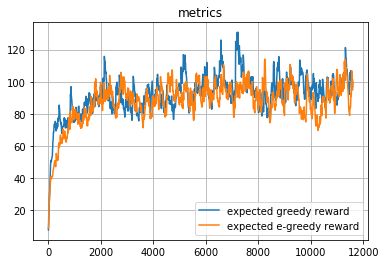

Random session examples


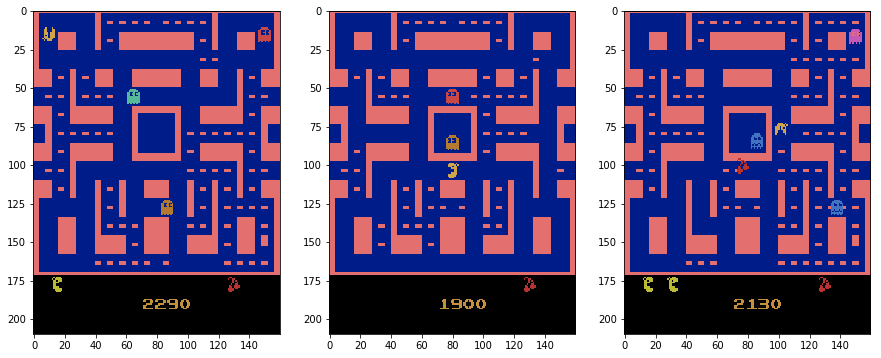

epoch 11610,loss 1477.95796, epsilon 0.05000, rewards: ( e-greedy 106.86128, greedy 95.18962) 
rec 1477.828 reg 0.130
epoch 11620,loss 668.78220, epsilon 0.05000, rewards: ( e-greedy 103.92515, greedy 95.60816) 
rec 668.652 reg 0.130
epoch 11630,loss 437.68542, epsilon 0.05000, rewards: ( e-greedy 99.03263, greedy 91.85984) 
rec 437.555 reg 0.130
epoch 11640,loss 456.81548, epsilon 0.05000, rewards: ( e-greedy 96.00437, greedy 89.73636) 
rec 456.685 reg 0.130
epoch 11650,loss 503.67418, epsilon 0.05000, rewards: ( e-greedy 93.15393, greedy 88.76272) 
rec 503.544 reg 0.130
epoch 11660,loss 1533.92977, epsilon 0.05000, rewards: ( e-greedy 90.58854, greedy 91.76145) 
rec 1533.800 reg 0.130
epoch 11670,loss 2925.06117, epsilon 0.05000, rewards: ( e-greedy 93.15469, greedy 87.77281) 
rec 2924.931 reg 0.130
epoch 11680,loss 485.03931, epsilon 0.05000, rewards: ( e-greedy 91.46422, greedy 87.05803) 
rec 484.909 reg 0.130
epoch 11690,loss 868.92531, epsilon 0.05000, rewards: ( e-greedy 92.8178

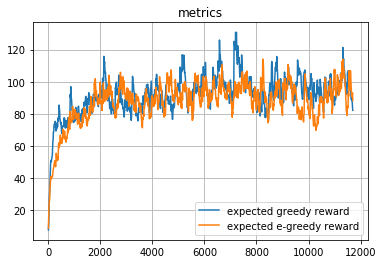

Random session examples


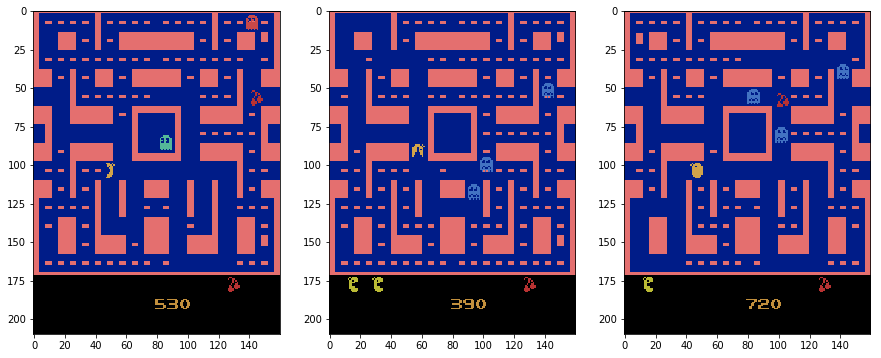

epoch 11710,loss 990.85567, epsilon 0.05000, rewards: ( e-greedy 92.76991, greedy 80.18343) 
rec 990.726 reg 0.130
epoch 11720,loss 1276.40015, epsilon 0.05000, rewards: ( e-greedy 94.18042, greedy 81.66508) 
rec 1276.270 reg 0.130
epoch 11730,loss 685.09379, epsilon 0.05000, rewards: ( e-greedy 95.94988, greedy 84.06108) 
rec 684.964 reg 0.130
epoch 11740,loss 1361.90693, epsilon 0.05000, rewards: ( e-greedy 99.91739, greedy 84.46747) 
rec 1361.777 reg 0.130
epoch 11750,loss 1087.54215, epsilon 0.05000, rewards: ( e-greedy 97.30065, greedy 83.39572) 
rec 1087.412 reg 0.130
epoch 11760,loss 4864.98026, epsilon 0.05000, rewards: ( e-greedy 99.94559, greedy 85.11865) 
rec 4864.850 reg 0.130
epoch 11770,loss 6444.44273, epsilon 0.05000, rewards: ( e-greedy 105.01353, greedy 85.23178) 
rec 6444.312 reg 0.130
epoch 11780,loss 1829.96840, epsilon 0.05000, rewards: ( e-greedy 107.38718, greedy 85.27111) 
rec 1829.838 reg 0.130
epoch 11790,loss 403.35054, epsilon 0.05000, rewards: ( e-greedy 1

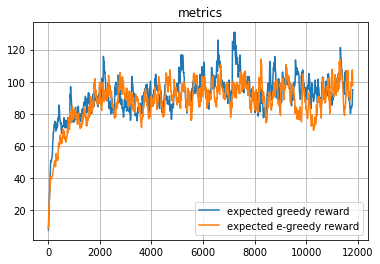

Random session examples


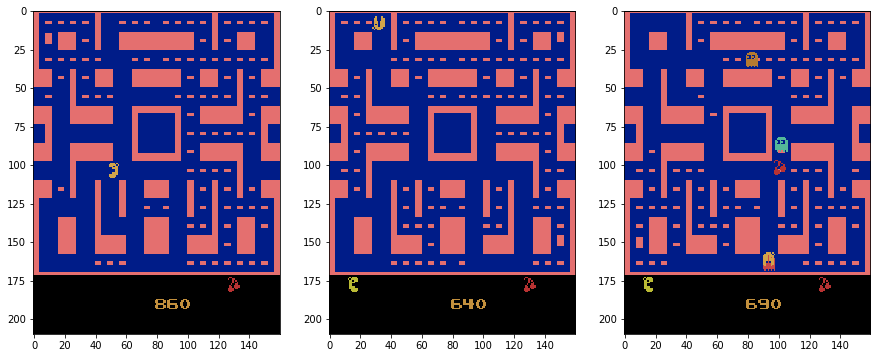

epoch 11810,loss 543.60041, epsilon 0.05000, rewards: ( e-greedy 96.01838, greedy 101.47264) 
rec 543.470 reg 0.130
epoch 11820,loss 253.50038, epsilon 0.05000, rewards: ( e-greedy 92.22904, greedy 98.82537) 
rec 253.370 reg 0.130
epoch 11830,loss 557.34060, epsilon 0.05000, rewards: ( e-greedy 88.44364, greedy 93.13034) 
rec 557.210 reg 0.130
epoch 11840,loss 433.42214, epsilon 0.05000, rewards: ( e-greedy 84.78677, greedy 90.56730) 
rec 433.292 reg 0.131
epoch 11850,loss 1555.76540, epsilon 0.05000, rewards: ( e-greedy 85.30809, greedy 89.51057) 
rec 1555.635 reg 0.131
epoch 11860,loss 396.24886, epsilon 0.05000, rewards: ( e-greedy 83.90228, greedy 91.49701) 
rec 396.118 reg 0.131
epoch 11870,loss 341.59691, epsilon 0.05000, rewards: ( e-greedy 82.26206, greedy 106.72231) 
rec 341.466 reg 0.131
epoch 11880,loss 818.77417, epsilon 0.05000, rewards: ( e-greedy 81.28585, greedy 100.11258) 
rec 818.644 reg 0.131
epoch 11890,loss 459.93233, epsilon 0.05000, rewards: ( e-greedy 81.03227, 

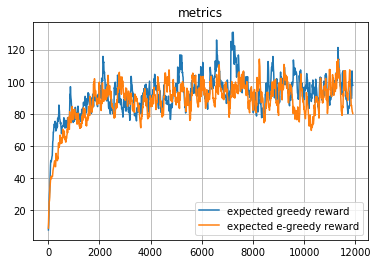

Random session examples


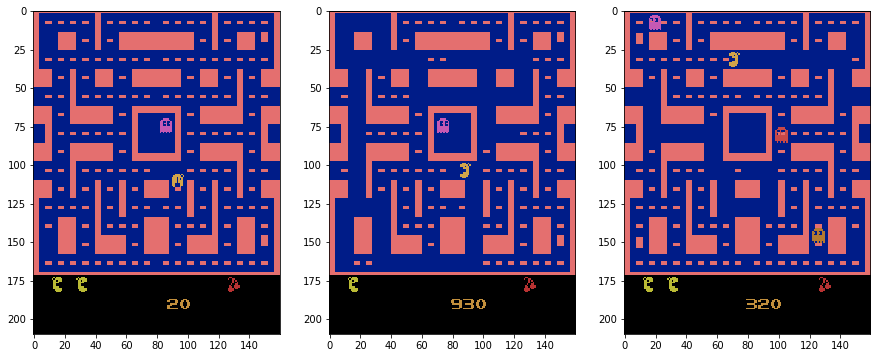

epoch 11910,loss 526.30756, epsilon 0.05000, rewards: ( e-greedy 82.41739, greedy 103.00645) 
rec 526.177 reg 0.131
epoch 11920,loss 387.06382, epsilon 0.05000, rewards: ( e-greedy 79.86315, greedy 104.70580) 
rec 386.933 reg 0.131
epoch 11930,loss 932.53691, epsilon 0.05000, rewards: ( e-greedy 85.18933, greedy 102.36022) 
rec 932.406 reg 0.131
epoch 11940,loss 529.57770, epsilon 0.05000, rewards: ( e-greedy 85.67040, greedy 98.74920) 
rec 529.447 reg 0.131
epoch 11950,loss 312.39848, epsilon 0.05000, rewards: ( e-greedy 81.66586, greedy 92.93678) 
rec 312.268 reg 0.131
epoch 11960,loss 530.82516, epsilon 0.05000, rewards: ( e-greedy 81.56177, greedy 98.33060) 
rec 530.694 reg 0.131
epoch 11970,loss 368.82089, epsilon 0.05000, rewards: ( e-greedy 79.34310, greedy 95.24754) 
rec 368.690 reg 0.131
epoch 11980,loss 2130.86844, epsilon 0.05000, rewards: ( e-greedy 81.90879, greedy 98.72279) 
rec 2130.738 reg 0.131
epoch 11990,loss 2150.76738, epsilon 0.05000, rewards: ( e-greedy 87.21791,

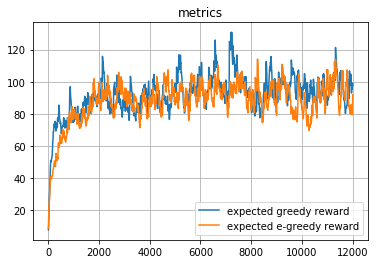

Random session examples


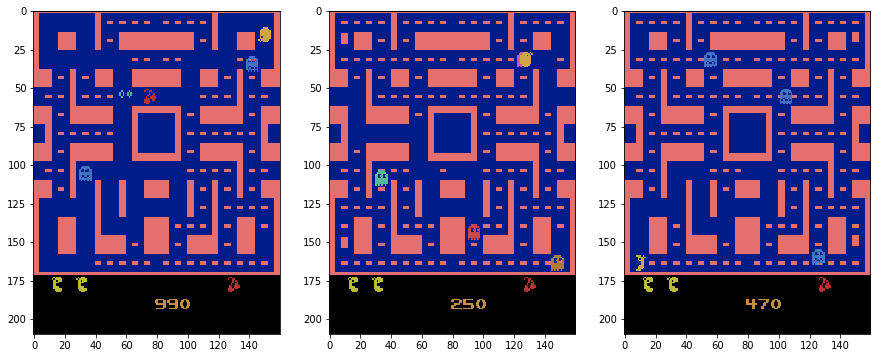

[2017-05-24 21:06:53,549] Making new env: MsPacman-v0
[2017-05-24 21:06:53,713] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 21:06:53,721] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.19.19270.video000000.mp4
[2017-05-24 21:06:55,408] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.19.19270.video000001.mp4


Episode finished after 657 timesteps with reward=240.0
Episode finished after 657 timesteps with reward=220.0
Episode finished after 647 timesteps with reward=240.0
Episode finished after 613 timesteps with reward=300.0
Episode finished after 704 timesteps with reward=240.0
Episode finished after 662 timesteps with reward=250.0
Episode finished after 751 timesteps with reward=240.0


[2017-05-24 21:07:04,314] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.19.19270.video000008.mp4


Episode finished after 699 timesteps with reward=310.0
Episode finished after 617 timesteps with reward=240.0
Episode finished after 832 timesteps with reward=170.0
Episode finished after 548 timesteps with reward=230.0
Episode finished after 570 timesteps with reward=220.0
Episode finished after 588 timesteps with reward=170.0
Episode finished after 913 timesteps with reward=240.0
Episode finished after 658 timesteps with reward=240.0
Episode finished after 583 timesteps with reward=230.0
Episode finished after 629 timesteps with reward=240.0
Episode finished after 568 timesteps with reward=260.0
Episode finished after 780 timesteps with reward=240.0


[2017-05-24 21:07:19,060] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 653 timesteps with reward=200.0
Mean 236.0, Var 1054.0
epoch 12010,loss 954.39625, epsilon 0.05000, rewards: ( e-greedy 89.68401, greedy 92.54704) 
rec 954.265 reg 0.131
epoch 12020,loss 1165.57798, epsilon 0.05000, rewards: ( e-greedy 91.71560, greedy 93.66733) 
rec 1165.447 reg 0.131
epoch 12030,loss 2231.81046, epsilon 0.05000, rewards: ( e-greedy 95.16904, greedy 94.92560) 
rec 2231.679 reg 0.131
epoch 12040,loss 429.75220, epsilon 0.05000, rewards: ( e-greedy 92.15214, greedy 94.55804) 
rec 429.621 reg 0.131
epoch 12050,loss 636.38080, epsilon 0.05000, rewards: ( e-greedy 92.74943, greedy 95.78974) 
rec 636.250 reg 0.131
epoch 12060,loss 602.90048, epsilon 0.05000, rewards: ( e-greedy 91.09948, greedy 94.89826) 
rec 602.769 reg 0.131
epoch 12070,loss 7224.34407, epsilon 0.05000, rewards: ( e-greedy 101.48953, greedy 99.47094) 
rec 7224.213 reg 0.131
epoch 12080,loss 1534.09874, epsilon 0.05000, rewards: ( e-greedy 99.65308, greedy 97.02384) 
rec 1533.968 reg

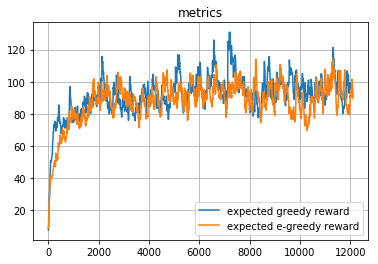

Random session examples


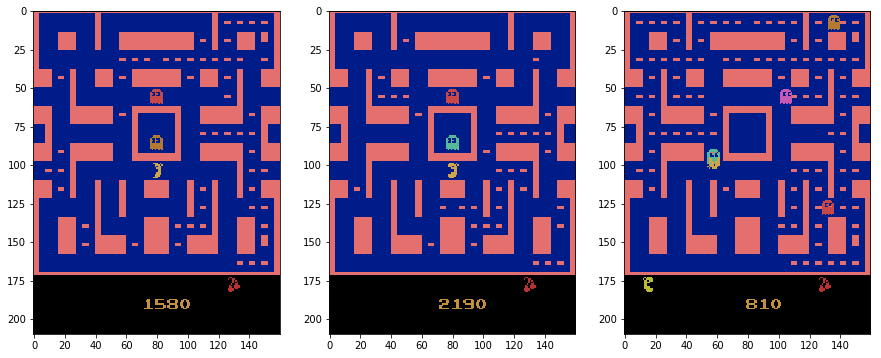

epoch 12110,loss 2292.16228, epsilon 0.05000, rewards: ( e-greedy 93.27210, greedy 89.50976) 
rec 2292.031 reg 0.131
epoch 12120,loss 438.71105, epsilon 0.05000, rewards: ( e-greedy 90.38239, greedy 101.80878) 
rec 438.580 reg 0.131
epoch 12130,loss 934.65915, epsilon 0.05000, rewards: ( e-greedy 91.21915, greedy 103.75290) 
rec 934.528 reg 0.131
epoch 12140,loss 2551.56957, epsilon 0.05000, rewards: ( e-greedy 97.59723, greedy 109.56511) 
rec 2551.438 reg 0.131
epoch 12150,loss 2206.41627, epsilon 0.05000, rewards: ( e-greedy 98.46251, greedy 102.29610) 
rec 2206.285 reg 0.131
epoch 12160,loss 1776.71497, epsilon 0.05000, rewards: ( e-greedy 101.80376, greedy 109.00399) 
rec 1776.583 reg 0.131
epoch 12170,loss 368.84716, epsilon 0.05000, rewards: ( e-greedy 97.93588, greedy 109.85359) 
rec 368.716 reg 0.131
epoch 12180,loss 1361.57619, epsilon 0.05000, rewards: ( e-greedy 101.82979, greedy 105.30573) 
rec 1361.445 reg 0.131
epoch 12190,loss 850.89424, epsilon 0.05000, rewards: ( e-gre

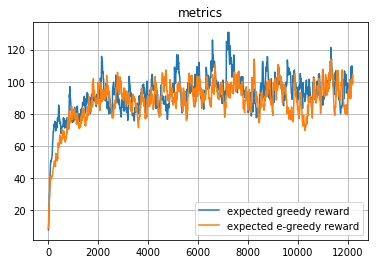

Random session examples


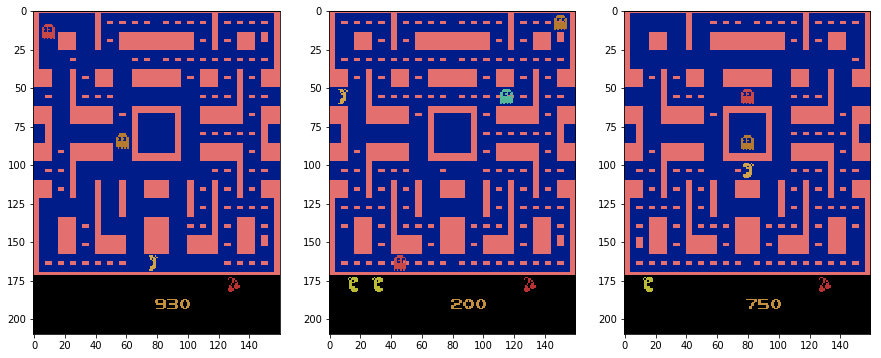

epoch 12210,loss 275.98469, epsilon 0.05000, rewards: ( e-greedy 98.98580, greedy 99.70225) 
rec 275.853 reg 0.131
epoch 12220,loss 528.96505, epsilon 0.05000, rewards: ( e-greedy 94.89972, greedy 99.29453) 
rec 528.834 reg 0.131
epoch 12230,loss 319.80786, epsilon 0.05000, rewards: ( e-greedy 92.53474, greedy 101.49008) 
rec 319.676 reg 0.131
epoch 12240,loss 394.16724, epsilon 0.05000, rewards: ( e-greedy 88.78127, greedy 98.52857) 
rec 394.036 reg 0.132
epoch 12250,loss 875.48983, epsilon 0.05000, rewards: ( e-greedy 88.52814, greedy 99.36321) 
rec 875.358 reg 0.132
epoch 12260,loss 6965.90119, epsilon 0.05000, rewards: ( e-greedy 95.61283, greedy 101.36439) 
rec 6965.770 reg 0.132
epoch 12270,loss 2360.63810, epsilon 0.05000, rewards: ( e-greedy 95.36405, greedy 103.04045) 
rec 2360.506 reg 0.132
epoch 12280,loss 682.37696, epsilon 0.05000, rewards: ( e-greedy 91.07764, greedy 101.54891) 
rec 682.245 reg 0.132
epoch 12290,loss 817.13558, epsilon 0.05000, rewards: ( e-greedy 89.7823

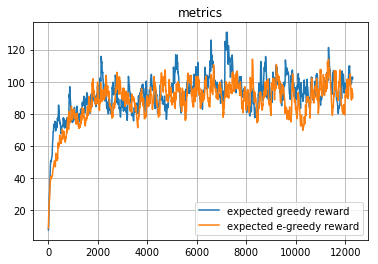

Random session examples


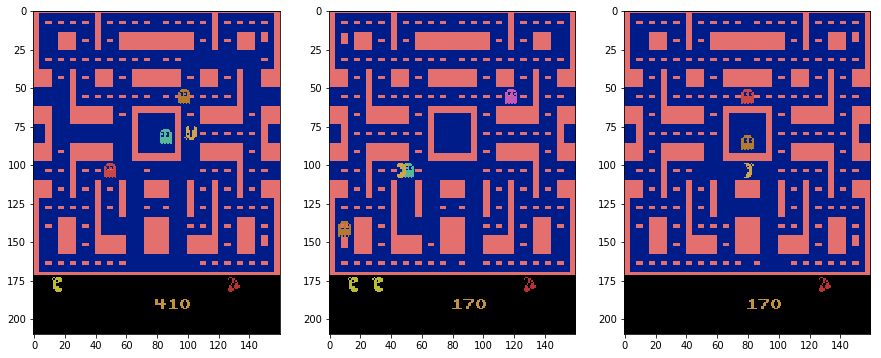

epoch 12310,loss 321.05235, epsilon 0.05000, rewards: ( e-greedy 88.09873, greedy 101.71603) 
rec 320.921 reg 0.132
epoch 12320,loss 926.75467, epsilon 0.05000, rewards: ( e-greedy 86.85135, greedy 104.60692) 
rec 926.623 reg 0.132
epoch 12330,loss 1324.63416, epsilon 0.05000, rewards: ( e-greedy 85.66622, greedy 99.89623) 
rec 1324.502 reg 0.132
epoch 12340,loss 2835.32119, epsilon 0.05000, rewards: ( e-greedy 94.78710, greedy 108.90661) 
rec 2835.189 reg 0.132
epoch 12350,loss 883.55723, epsilon 0.05000, rewards: ( e-greedy 94.87089, greedy 107.45345) 
rec 883.425 reg 0.132
epoch 12360,loss 583.06148, epsilon 0.05000, rewards: ( e-greedy 93.50880, greedy 103.58310) 
rec 582.930 reg 0.132
epoch 12370,loss 1696.92863, epsilon 0.05000, rewards: ( e-greedy 92.84542, greedy 99.78729) 
rec 1696.797 reg 0.132
epoch 12380,loss 1570.74771, epsilon 0.05000, rewards: ( e-greedy 97.56088, greedy 104.24606) 
rec 1570.616 reg 0.132
epoch 12390,loss 724.23833, epsilon 0.05000, rewards: ( e-greedy 9

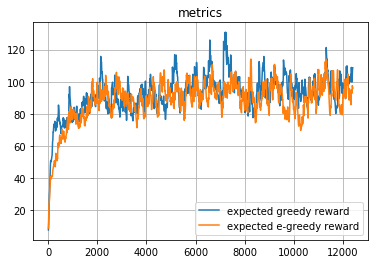

Random session examples


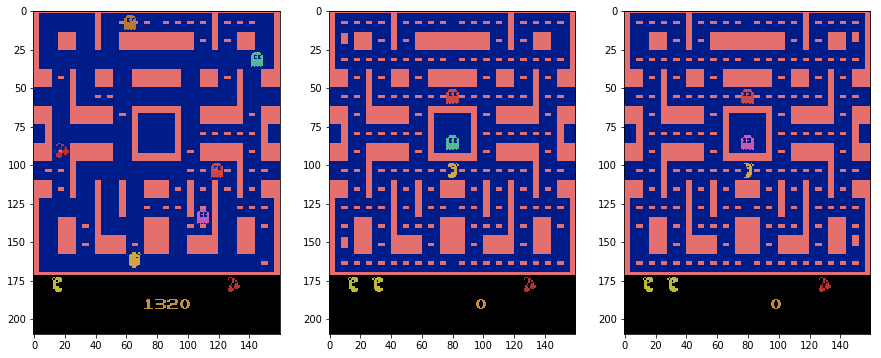

epoch 12410,loss 557.81599, epsilon 0.05000, rewards: ( e-greedy 94.13313, greedy 106.41163) 
rec 557.684 reg 0.132
epoch 12420,loss 2057.82427, epsilon 0.05000, rewards: ( e-greedy 95.78232, greedy 104.64547) 
rec 2057.692 reg 0.132
epoch 12430,loss 224.79781, epsilon 0.05000, rewards: ( e-greedy 89.76658, greedy 102.11842) 
rec 224.666 reg 0.132
epoch 12440,loss 469.64869, epsilon 0.05000, rewards: ( e-greedy 87.91493, greedy 103.59408) 
rec 469.517 reg 0.132
epoch 12450,loss 365.02066, epsilon 0.05000, rewards: ( e-greedy 85.06093, greedy 100.48467) 
rec 364.889 reg 0.132
epoch 12460,loss 1538.03094, epsilon 0.05000, rewards: ( e-greedy 83.80484, greedy 100.62370) 
rec 1537.899 reg 0.132
epoch 12470,loss 2618.17047, epsilon 0.05000, rewards: ( e-greedy 85.73686, greedy 95.74883) 
rec 2618.038 reg 0.132
epoch 12480,loss 1346.80637, epsilon 0.05000, rewards: ( e-greedy 86.72567, greedy 94.86145) 
rec 1346.674 reg 0.132
epoch 12490,loss 890.45385, epsilon 0.05000, rewards: ( e-greedy 8

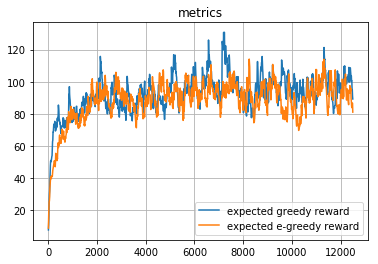

Random session examples


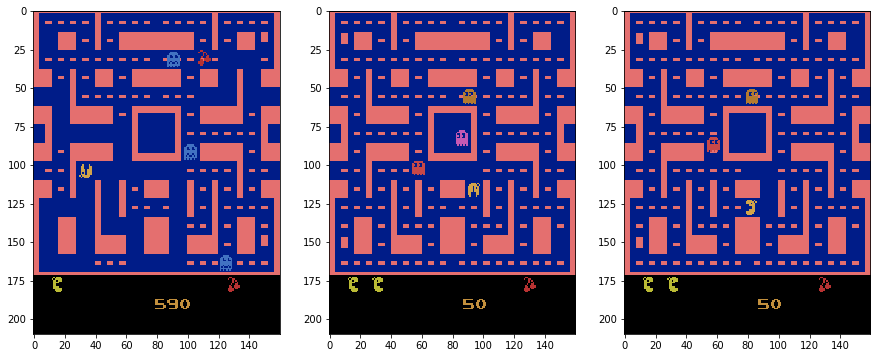

epoch 12510,loss 983.54521, epsilon 0.05000, rewards: ( e-greedy 82.16489, greedy 87.85962) 
rec 983.413 reg 0.132
epoch 12520,loss 1393.04506, epsilon 0.05000, rewards: ( e-greedy 82.19840, greedy 87.13616) 
rec 1392.913 reg 0.132
epoch 12530,loss 319.91707, epsilon 0.05000, rewards: ( e-greedy 78.22856, greedy 86.61004) 
rec 319.785 reg 0.132
epoch 12540,loss 554.37247, epsilon 0.05000, rewards: ( e-greedy 77.59320, greedy 89.13654) 
rec 554.240 reg 0.132
epoch 12550,loss 964.15968, epsilon 0.05000, rewards: ( e-greedy 77.14638, greedy 93.91039) 
rec 964.027 reg 0.132
epoch 12560,loss 392.71477, epsilon 0.05000, rewards: ( e-greedy 78.11925, greedy 93.08185) 
rec 392.583 reg 0.132
epoch 12570,loss 585.58398, epsilon 0.05000, rewards: ( e-greedy 78.99482, greedy 91.39866) 
rec 585.452 reg 0.132
epoch 12580,loss 387.20282, epsilon 0.05000, rewards: ( e-greedy 78.65784, greedy 89.00880) 
rec 387.071 reg 0.132
epoch 12590,loss 1233.57773, epsilon 0.05000, rewards: ( e-greedy 84.97955, gr

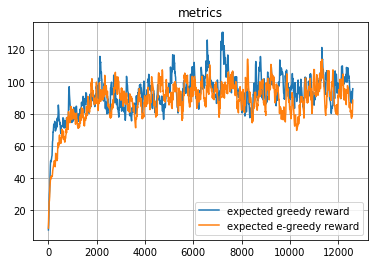

Random session examples


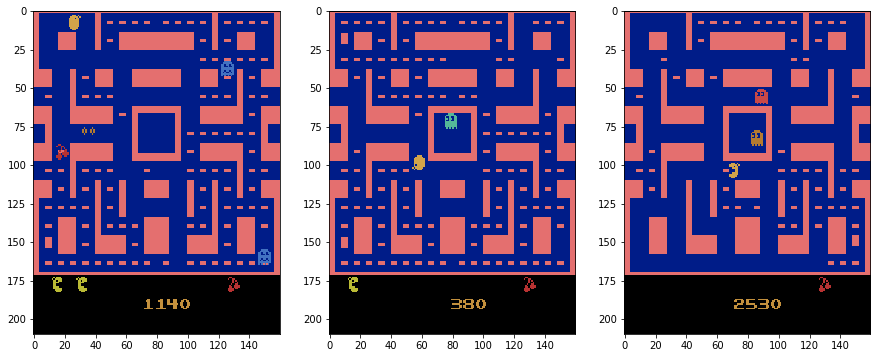

epoch 12610,loss 548.63673, epsilon 0.05000, rewards: ( e-greedy 87.32094, greedy 98.81554) 
rec 548.504 reg 0.132
epoch 12620,loss 1047.82189, epsilon 0.05000, rewards: ( e-greedy 88.15135, greedy 98.37148) 
rec 1047.689 reg 0.132
epoch 12630,loss 374.65779, epsilon 0.05000, rewards: ( e-greedy 82.02371, greedy 93.15934) 
rec 374.525 reg 0.132
epoch 12640,loss 1327.89402, epsilon 0.05000, rewards: ( e-greedy 86.63384, greedy 96.34340) 
rec 1327.762 reg 0.132
epoch 12650,loss 1099.16647, epsilon 0.05000, rewards: ( e-greedy 90.65796, greedy 99.70906) 
rec 1099.034 reg 0.132
epoch 12660,loss 1485.70507, epsilon 0.05000, rewards: ( e-greedy 94.15466, greedy 100.92566) 
rec 1485.573 reg 0.132
epoch 12670,loss 952.76995, epsilon 0.05000, rewards: ( e-greedy 91.67669, greedy 100.39559) 
rec 952.637 reg 0.133
epoch 12680,loss 555.90371, epsilon 0.05000, rewards: ( e-greedy 92.13402, greedy 104.04353) 
rec 555.771 reg 0.133
epoch 12690,loss 291.02800, epsilon 0.05000, rewards: ( e-greedy 88.4

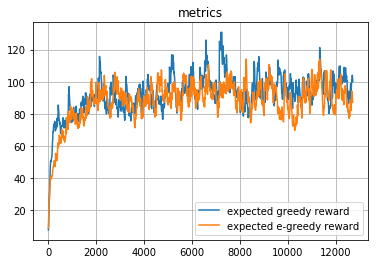

Random session examples


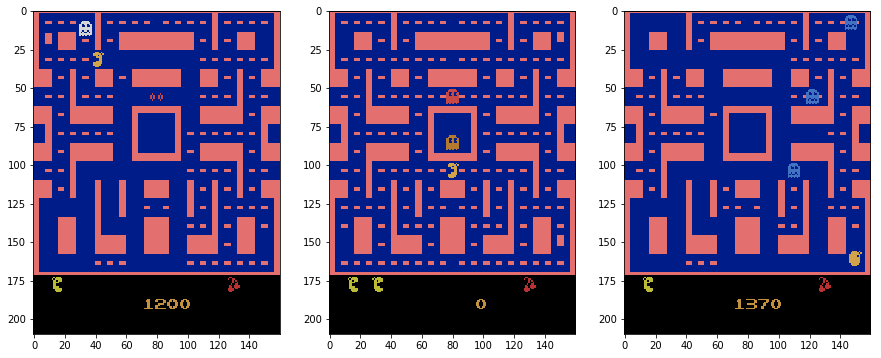

epoch 12710,loss 1362.14127, epsilon 0.05000, rewards: ( e-greedy 92.66445, greedy 103.70961) 
rec 1362.008 reg 0.133
epoch 12720,loss 1725.92633, epsilon 0.05000, rewards: ( e-greedy 96.21051, greedy 106.90115) 
rec 1725.793 reg 0.133
epoch 12730,loss 1444.54878, epsilon 0.05000, rewards: ( e-greedy 96.90196, greedy 103.77353) 
rec 1444.416 reg 0.133
epoch 12740,loss 403.39358, epsilon 0.05000, rewards: ( e-greedy 93.96176, greedy 98.39618) 
rec 403.261 reg 0.133
epoch 12750,loss 1242.02678, epsilon 0.05000, rewards: ( e-greedy 97.50309, greedy 94.99406) 
rec 1241.894 reg 0.133
epoch 12760,loss 1549.05757, epsilon 0.05000, rewards: ( e-greedy 100.50278, greedy 93.36966) 
rec 1548.925 reg 0.133
epoch 12770,loss 408.18478, epsilon 0.05000, rewards: ( e-greedy 97.32750, greedy 93.22019) 
rec 408.052 reg 0.133
epoch 12780,loss 1166.78837, epsilon 0.05000, rewards: ( e-greedy 97.21975, greedy 99.08567) 
rec 1166.656 reg 0.133
epoch 12790,loss 638.35717, epsilon 0.05000, rewards: ( e-greedy

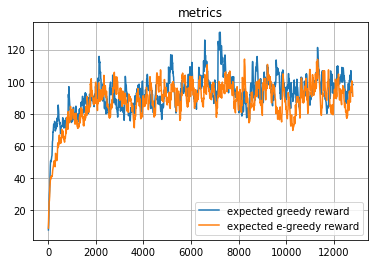

Random session examples


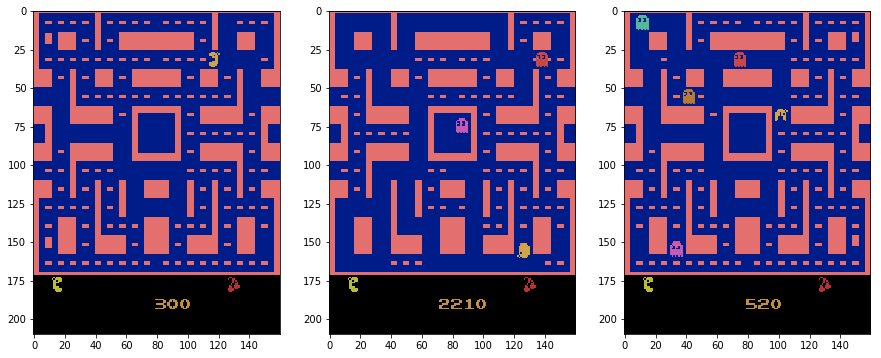

epoch 12810,loss 405.36554, epsilon 0.05000, rewards: ( e-greedy 89.72820, greedy 98.65033) 
rec 405.233 reg 0.133
epoch 12820,loss 843.94640, epsilon 0.05000, rewards: ( e-greedy 88.19288, greedy 96.47280) 
rec 843.814 reg 0.133
epoch 12830,loss 361.73320, epsilon 0.05000, rewards: ( e-greedy 85.43609, greedy 90.95052) 
rec 361.600 reg 0.133
epoch 12840,loss 365.96625, epsilon 0.05000, rewards: ( e-greedy 82.64248, greedy 88.23047) 
rec 365.833 reg 0.133
epoch 12850,loss 347.26668, epsilon 0.05000, rewards: ( e-greedy 79.31573, greedy 84.59492) 
rec 347.134 reg 0.133
epoch 12860,loss 1002.25259, epsilon 0.05000, rewards: ( e-greedy 83.13416, greedy 86.82293) 
rec 1002.120 reg 0.133
epoch 12870,loss 211.48630, epsilon 0.05000, rewards: ( e-greedy 76.50824, greedy 80.57813) 
rec 211.353 reg 0.133
epoch 12880,loss 795.88755, epsilon 0.05000, rewards: ( e-greedy 76.54492, greedy 85.95782) 
rec 795.754 reg 0.133
epoch 12890,loss 1690.05130, epsilon 0.05000, rewards: ( e-greedy 78.01543, gr

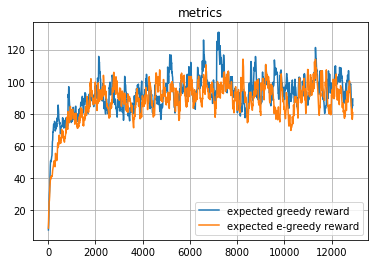

Random session examples


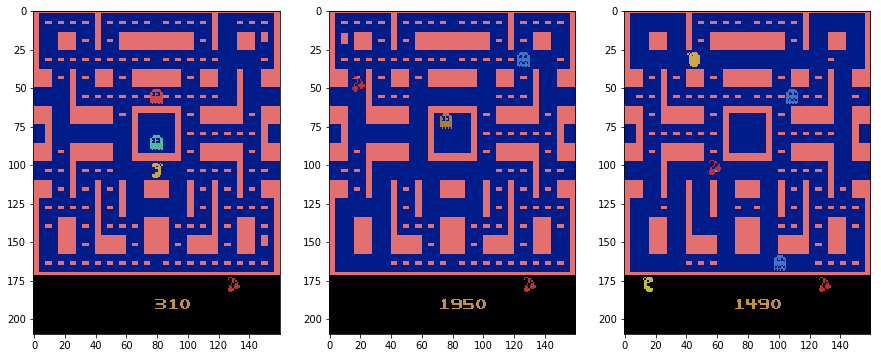

epoch 12910,loss 5056.15778, epsilon 0.05000, rewards: ( e-greedy 87.64250, greedy 96.20638) 
rec 5056.024 reg 0.133
epoch 12920,loss 7529.09530, epsilon 0.05000, rewards: ( e-greedy 93.94075, greedy 99.58574) 
rec 7528.962 reg 0.133
epoch 12930,loss 2916.62900, epsilon 0.05000, rewards: ( e-greedy 96.04667, greedy 96.62716) 
rec 2916.496 reg 0.133
epoch 12940,loss 1393.35028, epsilon 0.05000, rewards: ( e-greedy 98.37950, greedy 104.21445) 
rec 1393.217 reg 0.133
epoch 12950,loss 370.44744, epsilon 0.05000, rewards: ( e-greedy 92.54155, greedy 99.41800) 
rec 370.314 reg 0.133
epoch 12960,loss 399.05237, epsilon 0.05000, rewards: ( e-greedy 88.66240, greedy 95.16370) 
rec 398.919 reg 0.133
epoch 12970,loss 1920.49736, epsilon 0.05000, rewards: ( e-greedy 94.04616, greedy 97.95983) 
rec 1920.364 reg 0.133
epoch 12980,loss 628.81597, epsilon 0.05000, rewards: ( e-greedy 92.20404, greedy 102.97635) 
rec 628.682 reg 0.134
epoch 12990,loss 1231.06363, epsilon 0.05000, rewards: ( e-greedy 91

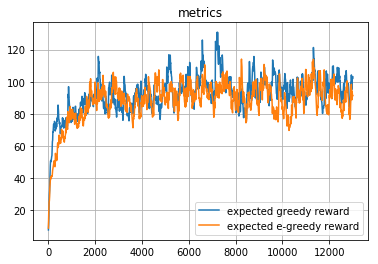

Random session examples


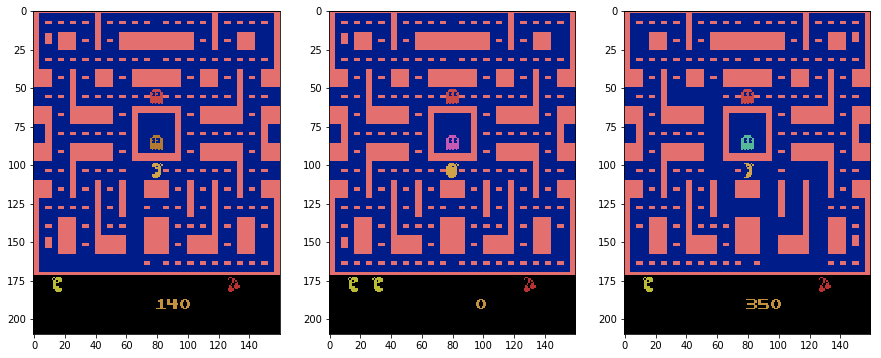

[2017-05-24 21:33:03,866] Making new env: MsPacman-v0
[2017-05-24 21:33:04,030] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 21:33:04,038] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.20.19270.video000000.mp4
[2017-05-24 21:33:05,446] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.20.19270.video000001.mp4


Episode finished after 514 timesteps with reward=210.0
Episode finished after 614 timesteps with reward=340.0
Episode finished after 436 timesteps with reward=120.0
Episode finished after 573 timesteps with reward=130.0
Episode finished after 587 timesteps with reward=230.0
Episode finished after 401 timesteps with reward=140.0
Episode finished after 834 timesteps with reward=320.0


[2017-05-24 21:33:13,158] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.20.19270.video000008.mp4


Episode finished after 576 timesteps with reward=160.0
Episode finished after 615 timesteps with reward=110.0
Episode finished after 421 timesteps with reward=60.0
Episode finished after 547 timesteps with reward=120.0
Episode finished after 458 timesteps with reward=120.0
Episode finished after 419 timesteps with reward=60.0
Episode finished after 571 timesteps with reward=300.0
Episode finished after 450 timesteps with reward=130.0
Episode finished after 999 timesteps with reward=490.0
Episode finished after 872 timesteps with reward=360.0
Episode finished after 680 timesteps with reward=230.0
Episode finished after 598 timesteps with reward=120.0


[2017-05-24 21:33:26,252] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 358 timesteps with reward=60.0
Mean 190.5, Var 13064.75
epoch 13010,loss 308.70064, epsilon 0.05000, rewards: ( e-greedy 88.80487, greedy 102.62913) 
rec 308.567 reg 0.134
epoch 13020,loss 3601.31687, epsilon 0.05000, rewards: ( e-greedy 95.86189, greedy 104.86622) 
rec 3601.183 reg 0.134
epoch 13030,loss 1656.71847, epsilon 0.05000, rewards: ( e-greedy 93.90070, greedy 101.75460) 
rec 1656.585 reg 0.134
epoch 13040,loss 642.84280, epsilon 0.05000, rewards: ( e-greedy 92.69813, greedy 95.51664) 
rec 642.709 reg 0.134
epoch 13050,loss 750.14489, epsilon 0.05000, rewards: ( e-greedy 92.80331, greedy 101.08997) 
rec 750.011 reg 0.134
epoch 13060,loss 336.63613, epsilon 0.05000, rewards: ( e-greedy 88.21048, greedy 95.66848) 
rec 336.502 reg 0.134
epoch 13070,loss 977.75900, epsilon 0.05000, rewards: ( e-greedy 91.57693, greedy 104.41413) 
rec 977.625 reg 0.134
epoch 13080,loss 851.87468, epsilon 0.05000, rewards: ( e-greedy 91.54424, greedy 102.16022) 
rec 851.741 r

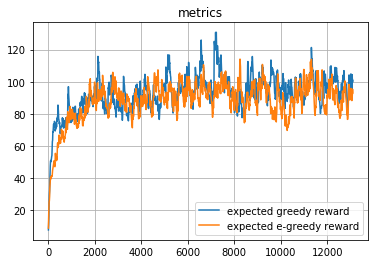

Random session examples


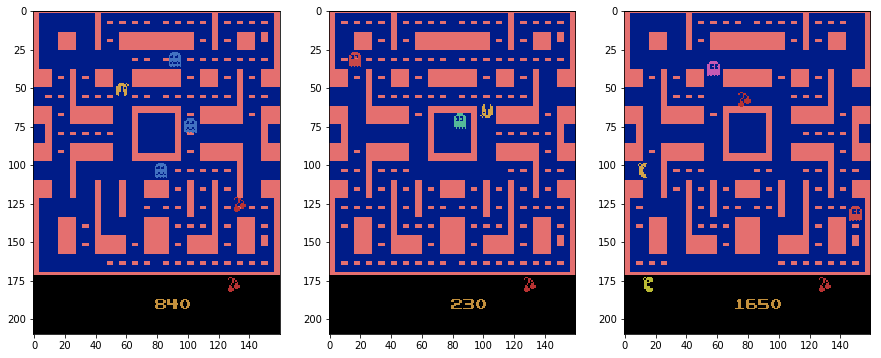

epoch 13110,loss 1580.29416, epsilon 0.05000, rewards: ( e-greedy 97.19013, greedy 103.64542) 
rec 1580.160 reg 0.134
epoch 13120,loss 794.50780, epsilon 0.05000, rewards: ( e-greedy 97.40861, greedy 98.34338) 
rec 794.374 reg 0.134
epoch 13130,loss 773.80895, epsilon 0.05000, rewards: ( e-greedy 95.98025, greedy 100.07154) 
rec 773.675 reg 0.134
epoch 13140,loss 666.33388, epsilon 0.05000, rewards: ( e-greedy 94.94473, greedy 97.75189) 
rec 666.200 reg 0.134
epoch 13150,loss 624.68825, epsilon 0.05000, rewards: ( e-greedy 95.38775, greedy 93.22670) 
rec 624.554 reg 0.134
epoch 13160,loss 666.52405, epsilon 0.05000, rewards: ( e-greedy 93.41148, greedy 95.71653) 
rec 666.390 reg 0.134
epoch 13170,loss 3359.29696, epsilon 0.05000, rewards: ( e-greedy 99.25783, greedy 101.20738) 
rec 3359.163 reg 0.134
epoch 13180,loss 1072.19556, epsilon 0.05000, rewards: ( e-greedy 101.14455, greedy 103.21164) 
rec 1072.061 reg 0.134
epoch 13190,loss 1388.80274, epsilon 0.05000, rewards: ( e-greedy 99.

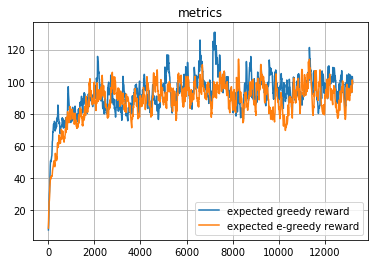

Random session examples


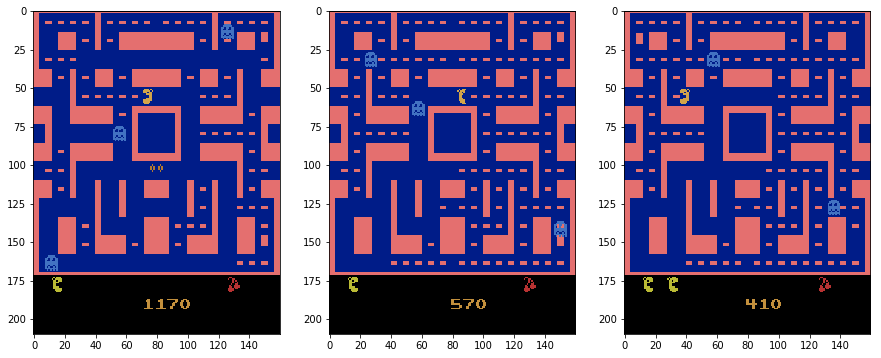

epoch 13210,loss 1348.73771, epsilon 0.05000, rewards: ( e-greedy 100.31438, greedy 95.49503) 
rec 1348.604 reg 0.134
epoch 13220,loss 1806.84906, epsilon 0.05000, rewards: ( e-greedy 100.53294, greedy 98.19553) 
rec 1806.715 reg 0.134
epoch 13230,loss 621.14109, epsilon 0.05000, rewards: ( e-greedy 100.22964, greedy 100.31348) 
rec 621.007 reg 0.134
epoch 13240,loss 484.31693, epsilon 0.05000, rewards: ( e-greedy 98.14418, greedy 99.34463) 
rec 484.183 reg 0.134
epoch 13250,loss 428.16568, epsilon 0.05000, rewards: ( e-greedy 94.76726, greedy 104.59767) 
rec 428.031 reg 0.134
epoch 13260,loss 794.99604, epsilon 0.05000, rewards: ( e-greedy 91.47804, greedy 102.51290) 
rec 794.862 reg 0.134
epoch 13270,loss 522.73117, epsilon 0.05000, rewards: ( e-greedy 88.51773, greedy 99.07411) 
rec 522.597 reg 0.134
epoch 13280,loss 721.93731, epsilon 0.05000, rewards: ( e-greedy 89.97846, greedy 95.60420) 
rec 721.803 reg 0.134
epoch 13290,loss 283.95723, epsilon 0.05000, rewards: ( e-greedy 85.04

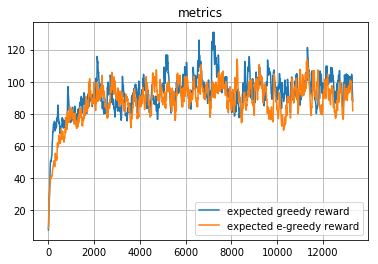

Random session examples


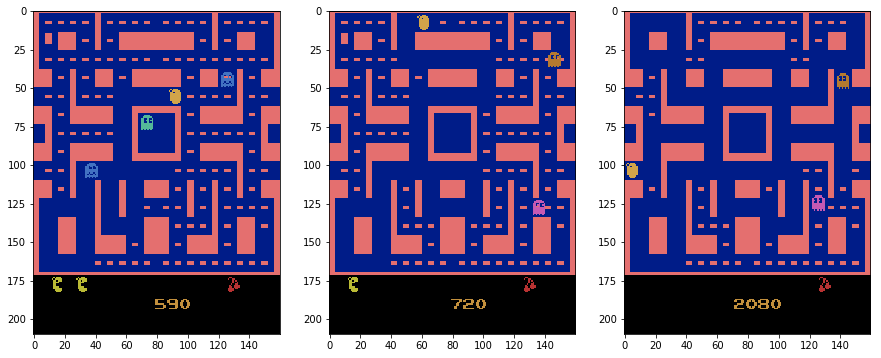

epoch 13310,loss 2110.85330, epsilon 0.05000, rewards: ( e-greedy 85.54117, greedy 89.44859) 
rec 2110.719 reg 0.134
epoch 13320,loss 34808.94694, epsilon 0.05000, rewards: ( e-greedy 100.23705, greedy 97.56623) 
rec 34808.812 reg 0.134
epoch 13330,loss 718.59833, epsilon 0.05000, rewards: ( e-greedy 96.52585, greedy 98.18460) 
rec 718.464 reg 0.135
epoch 13340,loss 1323.34800, epsilon 0.05000, rewards: ( e-greedy 98.06076, greedy 97.05364) 
rec 1323.214 reg 0.135
epoch 13350,loss 538.01324, epsilon 0.05000, rewards: ( e-greedy 94.50469, greedy 95.41078) 
rec 537.879 reg 0.135
epoch 13360,loss 1438.07034, epsilon 0.05000, rewards: ( e-greedy 95.80422, greedy 96.61970) 
rec 1437.936 reg 0.135
epoch 13370,loss 1155.32658, epsilon 0.05000, rewards: ( e-greedy 97.53630, greedy 97.70773) 
rec 1155.192 reg 0.135
epoch 13380,loss 667.24641, epsilon 0.05000, rewards: ( e-greedy 92.53267, greedy 97.81196) 
rec 667.112 reg 0.135
epoch 13390,loss 608.59677, epsilon 0.05000, rewards: ( e-greedy 94

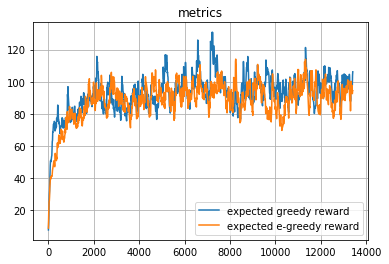

Random session examples


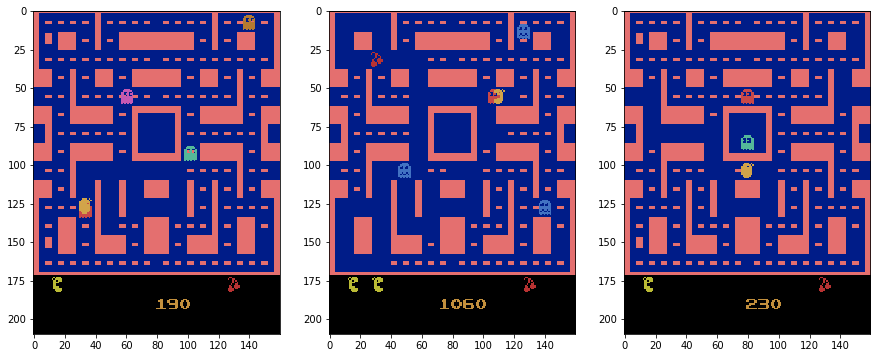

epoch 13410,loss 24014.99598, epsilon 0.05000, rewards: ( e-greedy 105.24506, greedy 103.43492) 
rec 24014.861 reg 0.135
epoch 13420,loss 763.08381, epsilon 0.05000, rewards: ( e-greedy 102.59556, greedy 102.65393) 
rec 762.949 reg 0.135
epoch 13430,loss 636.80190, epsilon 0.05000, rewards: ( e-greedy 101.08600, greedy 104.63853) 
rec 636.667 reg 0.135
epoch 13440,loss 1703.69577, epsilon 0.05000, rewards: ( e-greedy 101.66490, greedy 101.42468) 
rec 1703.561 reg 0.135
epoch 13450,loss 875.04365, epsilon 0.05000, rewards: ( e-greedy 100.49841, greedy 98.40721) 
rec 874.909 reg 0.135
epoch 13460,loss 1597.36539, epsilon 0.05000, rewards: ( e-greedy 99.13607, greedy 99.62899) 
rec 1597.231 reg 0.135
epoch 13470,loss 5010.66893, epsilon 0.05000, rewards: ( e-greedy 107.09746, greedy 99.04109) 
rec 5010.534 reg 0.135
epoch 13480,loss 712.29826, epsilon 0.05000, rewards: ( e-greedy 110.07522, greedy 96.19948) 
rec 712.163 reg 0.135
epoch 13490,loss 335.07693, epsilon 0.05000, rewards: ( e-g

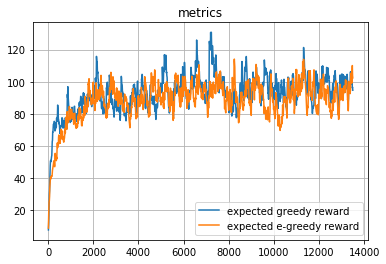

Random session examples


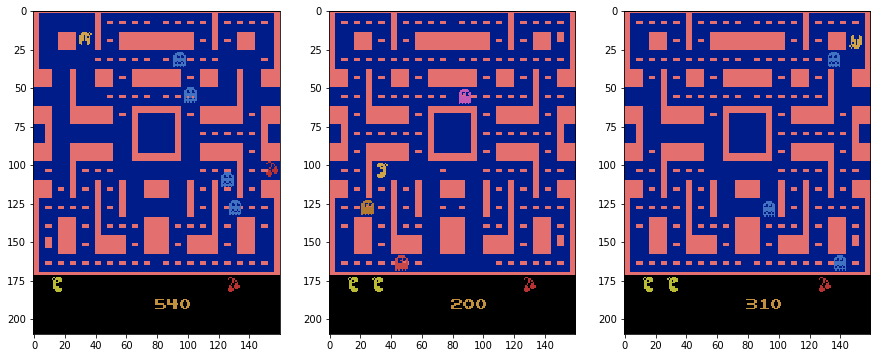

epoch 13510,loss 937.71650, epsilon 0.05000, rewards: ( e-greedy 106.01671, greedy 101.70442) 
rec 937.581 reg 0.135
epoch 13520,loss 446.57162, epsilon 0.05000, rewards: ( e-greedy 100.54004, greedy 102.72148) 
rec 446.437 reg 0.135
epoch 13530,loss 605.49867, epsilon 0.05000, rewards: ( e-greedy 98.04853, greedy 101.94933) 
rec 605.364 reg 0.135
epoch 13540,loss 1547.10441, epsilon 0.05000, rewards: ( e-greedy 95.80618, greedy 98.25440) 
rec 1546.969 reg 0.135
epoch 13550,loss 2186.71032, epsilon 0.05000, rewards: ( e-greedy 96.53806, greedy 94.11646) 
rec 2186.575 reg 0.135
epoch 13560,loss 434.84181, epsilon 0.05000, rewards: ( e-greedy 93.13426, greedy 95.14231) 
rec 434.706 reg 0.135
epoch 13570,loss 366.87738, epsilon 0.05000, rewards: ( e-greedy 90.50833, greedy 102.44058) 
rec 366.742 reg 0.135
epoch 13580,loss 587.36925, epsilon 0.05000, rewards: ( e-greedy 91.70750, greedy 107.57152) 
rec 587.234 reg 0.135
epoch 13590,loss 423.12189, epsilon 0.05000, rewards: ( e-greedy 88.2

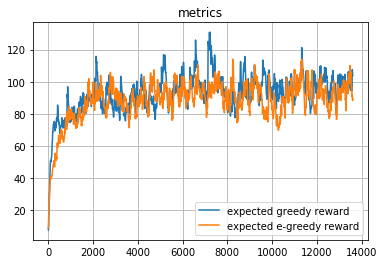

Random session examples


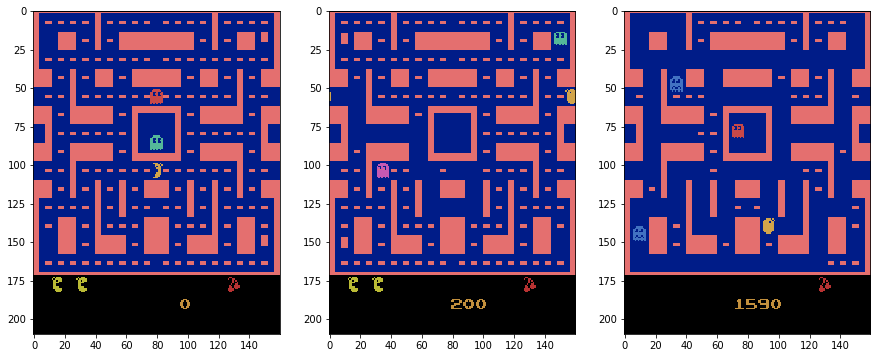

epoch 13610,loss 3099.84323, epsilon 0.05000, rewards: ( e-greedy 92.35539, greedy 99.89214) 
rec 3099.708 reg 0.135
epoch 13620,loss 2593.23562, epsilon 0.05000, rewards: ( e-greedy 97.86985, greedy 98.40293) 
rec 2593.100 reg 0.136
epoch 13630,loss 913.87968, epsilon 0.05000, rewards: ( e-greedy 93.77037, greedy 98.68763) 
rec 913.744 reg 0.136
epoch 13640,loss 2178.88418, epsilon 0.05000, rewards: ( e-greedy 97.58083, greedy 100.81887) 
rec 2178.749 reg 0.136
epoch 13650,loss 1359.06731, epsilon 0.05000, rewards: ( e-greedy 99.44775, greedy 106.17448) 
rec 1358.932 reg 0.136
epoch 13660,loss 492.54645, epsilon 0.05000, rewards: ( e-greedy 96.81547, greedy 110.49454) 
rec 492.411 reg 0.136
epoch 13670,loss 995.52755, epsilon 0.05000, rewards: ( e-greedy 94.82142, greedy 109.94508) 
rec 995.392 reg 0.136
epoch 13680,loss 387.87142, epsilon 0.05000, rewards: ( e-greedy 90.52678, greedy 114.70057) 
rec 387.736 reg 0.136
epoch 13690,loss 2592.00868, epsilon 0.05000, rewards: ( e-greedy 9

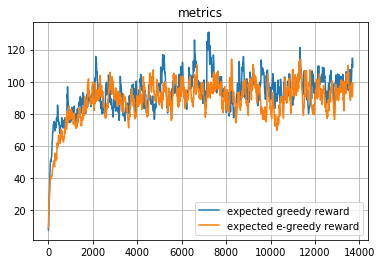

Random session examples


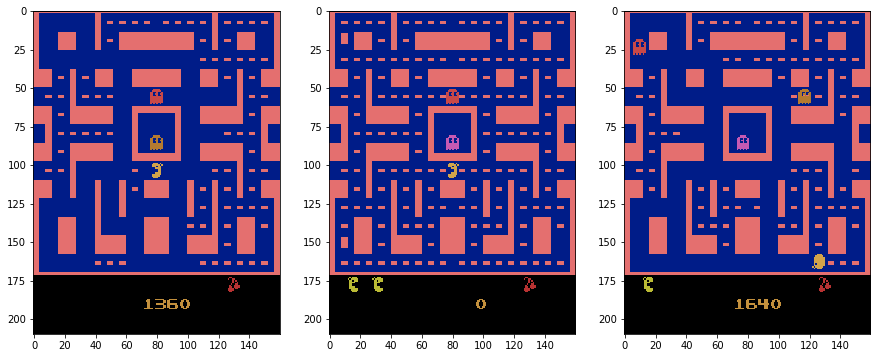

epoch 13710,loss 428.05416, epsilon 0.05000, rewards: ( e-greedy 93.68715, greedy 108.18922) 
rec 427.918 reg 0.136
epoch 13720,loss 713.35586, epsilon 0.05000, rewards: ( e-greedy 95.50593, greedy 110.05780) 
rec 713.220 reg 0.136
epoch 13730,loss 2266.37279, epsilon 0.05000, rewards: ( e-greedy 96.51784, greedy 115.48952) 
rec 2266.237 reg 0.136
epoch 13740,loss 540.65393, epsilon 0.05000, rewards: ( e-greedy 93.05356, greedy 114.75307) 
rec 540.518 reg 0.136
epoch 13750,loss 552.84332, epsilon 0.05000, rewards: ( e-greedy 89.93570, greedy 110.27776) 
rec 552.708 reg 0.136
epoch 13760,loss 250.44386, epsilon 0.05000, rewards: ( e-greedy 84.81713, greedy 104.18748) 
rec 250.308 reg 0.136
epoch 13770,loss 1473.83196, epsilon 0.05000, rewards: ( e-greedy 88.39792, greedy 103.89373) 
rec 1473.696 reg 0.136
epoch 13780,loss 715.95872, epsilon 0.05000, rewards: ( e-greedy 90.62063, greedy 105.25436) 
rec 715.823 reg 0.136
epoch 13790,loss 463.52120, epsilon 0.05000, rewards: ( e-greedy 87.

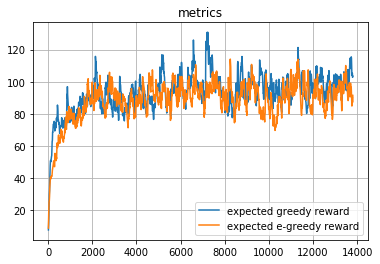

Random session examples


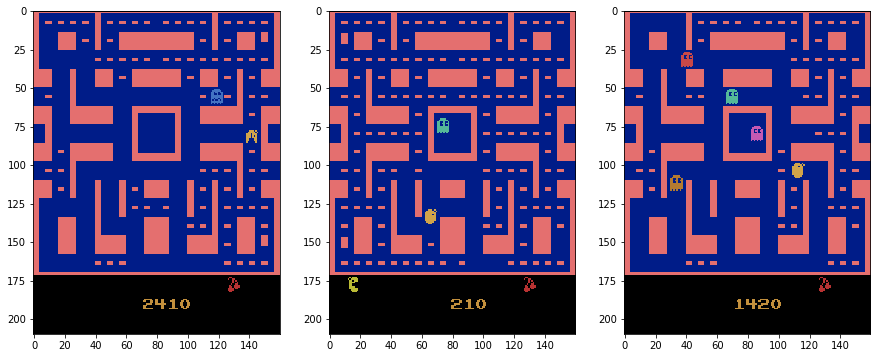

epoch 13810,loss 1416.32691, epsilon 0.05000, rewards: ( e-greedy 92.57431, greedy 109.54793) 
rec 1416.191 reg 0.136
epoch 13820,loss 402.58496, epsilon 0.05000, rewards: ( e-greedy 89.25438, greedy 108.53064) 
rec 402.449 reg 0.136
epoch 13830,loss 988.66664, epsilon 0.05000, rewards: ( e-greedy 90.57894, greedy 107.11507) 
rec 988.531 reg 0.136
epoch 13840,loss 1278.02835, epsilon 0.05000, rewards: ( e-greedy 93.95855, greedy 104.77857) 
rec 1277.892 reg 0.136
epoch 13850,loss 773.98060, epsilon 0.05000, rewards: ( e-greedy 93.50019, greedy 99.17571) 
rec 773.845 reg 0.136
epoch 13860,loss 600.08826, epsilon 0.05000, rewards: ( e-greedy 91.21267, greedy 99.00814) 
rec 599.952 reg 0.136
epoch 13870,loss 1310.26070, epsilon 0.05000, rewards: ( e-greedy 93.52891, greedy 99.54482) 
rec 1310.125 reg 0.136
epoch 13880,loss 557.74723, epsilon 0.05000, rewards: ( e-greedy 94.48852, greedy 106.09034) 
rec 557.611 reg 0.136
epoch 13890,loss 1158.16823, epsilon 0.05000, rewards: ( e-greedy 92.

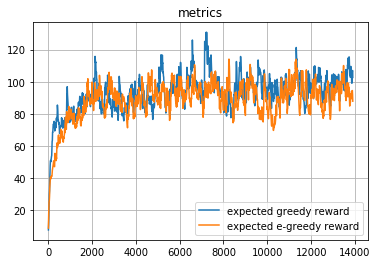

Random session examples


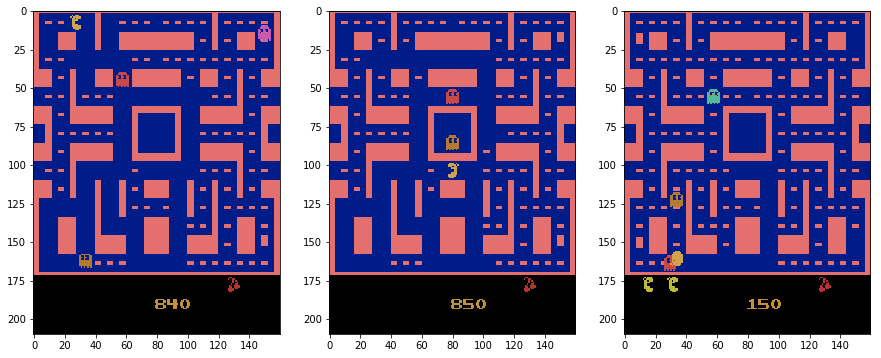

epoch 13910,loss 499.20309, epsilon 0.05000, rewards: ( e-greedy 85.98963, greedy 100.64236) 
rec 499.067 reg 0.136
epoch 13920,loss 563.48696, epsilon 0.05000, rewards: ( e-greedy 82.89067, greedy 102.95312) 
rec 563.351 reg 0.136
epoch 13930,loss 383.49133, epsilon 0.05000, rewards: ( e-greedy 81.47660, greedy 99.65781) 
rec 383.355 reg 0.136
epoch 13940,loss 599.84230, epsilon 0.05000, rewards: ( e-greedy 81.51644, greedy 100.12953) 
rec 599.706 reg 0.136
epoch 13950,loss 349.89335, epsilon 0.05000, rewards: ( e-greedy 77.73979, greedy 95.74158) 
rec 349.757 reg 0.136
epoch 13960,loss 7290.91770, epsilon 0.05000, rewards: ( e-greedy 84.65332, greedy 95.79242) 
rec 7290.781 reg 0.136
epoch 13970,loss 355.27279, epsilon 0.05000, rewards: ( e-greedy 81.81298, greedy 94.08818) 
rec 355.136 reg 0.137
epoch 13980,loss 1386.74127, epsilon 0.05000, rewards: ( e-greedy 84.19419, greedy 95.36686) 
rec 1386.605 reg 0.137
epoch 13990,loss 2119.54958, epsilon 0.05000, rewards: ( e-greedy 89.6497

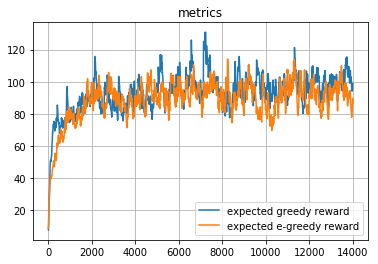

Random session examples


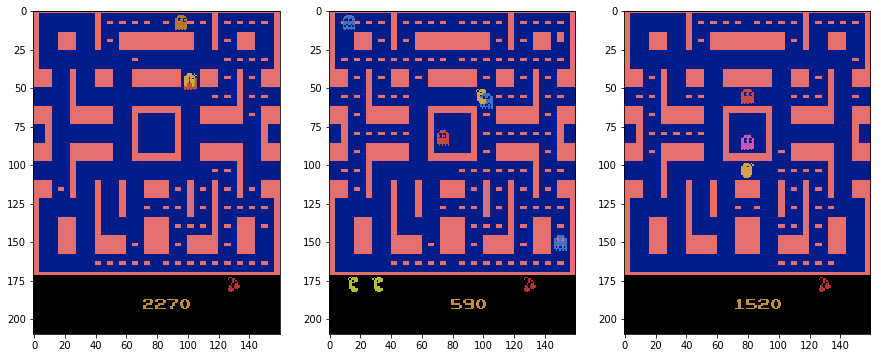

[2017-05-24 21:58:57,550] Making new env: MsPacman-v0
[2017-05-24 21:58:57,716] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 21:58:57,725] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.21.19270.video000000.mp4
[2017-05-24 21:58:59,460] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.21.19270.video000001.mp4


Episode finished after 696 timesteps with reward=180.0
Episode finished after 616 timesteps with reward=200.0
Episode finished after 695 timesteps with reward=170.0
Episode finished after 578 timesteps with reward=220.0
Episode finished after 722 timesteps with reward=300.0
Episode finished after 649 timesteps with reward=180.0
Episode finished after 721 timesteps with reward=240.0


[2017-05-24 21:59:07,832] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.21.19270.video000008.mp4


Episode finished after 537 timesteps with reward=240.0
Episode finished after 738 timesteps with reward=250.0
Episode finished after 608 timesteps with reward=170.0
Episode finished after 668 timesteps with reward=210.0
Episode finished after 700 timesteps with reward=210.0
Episode finished after 627 timesteps with reward=220.0
Episode finished after 538 timesteps with reward=230.0
Episode finished after 645 timesteps with reward=180.0
Episode finished after 709 timesteps with reward=300.0
Episode finished after 743 timesteps with reward=220.0
Episode finished after 720 timesteps with reward=250.0
Episode finished after 667 timesteps with reward=300.0


[2017-05-24 21:59:22,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 710 timesteps with reward=280.0
Mean 227.5, Var 1738.75
epoch 14010,loss 336.15841, epsilon 0.05000, rewards: ( e-greedy 80.67256, greedy 98.58182) 
rec 336.022 reg 0.137
epoch 14020,loss 755.47802, epsilon 0.05000, rewards: ( e-greedy 81.60531, greedy 97.72363) 
rec 755.341 reg 0.137
epoch 14030,loss 506.61526, epsilon 0.05000, rewards: ( e-greedy 83.00727, greedy 99.38877) 
rec 506.479 reg 0.137
epoch 14040,loss 408.85902, epsilon 0.05000, rewards: ( e-greedy 81.01905, greedy 100.19989) 
rec 408.722 reg 0.137
epoch 14050,loss 775.82240, epsilon 0.05000, rewards: ( e-greedy 80.66714, greedy 100.42990) 
rec 775.686 reg 0.137
epoch 14060,loss 3866.69133, epsilon 0.05000, rewards: ( e-greedy 89.35043, greedy 98.57441) 
rec 3866.555 reg 0.137
epoch 14070,loss 430.16388, epsilon 0.05000, rewards: ( e-greedy 87.35289, greedy 106.84197) 
rec 430.027 reg 0.137
epoch 14080,loss 301.06208, epsilon 0.05000, rewards: ( e-greedy 85.18010, greedy 105.53278) 
rec 300.925 reg 0

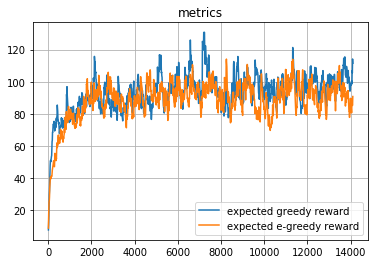

Random session examples


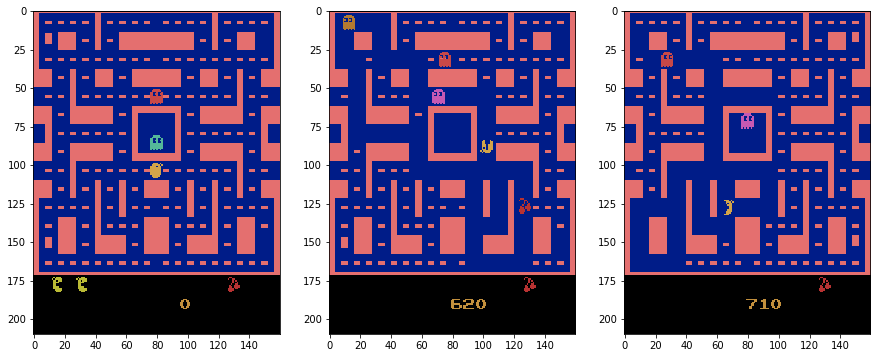

epoch 14110,loss 1856.75355, epsilon 0.05000, rewards: ( e-greedy 90.48942, greedy 114.28777) 
rec 1856.617 reg 0.137
epoch 14120,loss 377.62756, epsilon 0.05000, rewards: ( e-greedy 87.81547, greedy 109.73399) 
rec 377.491 reg 0.137
epoch 14130,loss 509.87166, epsilon 0.05000, rewards: ( e-greedy 85.28393, greedy 107.44809) 
rec 509.735 reg 0.137
epoch 14140,loss 403.17236, epsilon 0.05000, rewards: ( e-greedy 83.94303, greedy 104.89078) 
rec 403.035 reg 0.137
epoch 14150,loss 6527.20882, epsilon 0.05000, rewards: ( e-greedy 91.86123, greedy 100.65170) 
rec 6527.072 reg 0.137
epoch 14160,loss 769.27990, epsilon 0.05000, rewards: ( e-greedy 90.73761, greedy 102.83653) 
rec 769.143 reg 0.137
epoch 14170,loss 1665.15906, epsilon 0.05000, rewards: ( e-greedy 93.85135, greedy 101.74038) 
rec 1665.022 reg 0.137
epoch 14180,loss 3722.25245, epsilon 0.05000, rewards: ( e-greedy 100.90371, greedy 97.25384) 
rec 3722.115 reg 0.137
epoch 14190,loss 280.79196, epsilon 0.05000, rewards: ( e-greedy

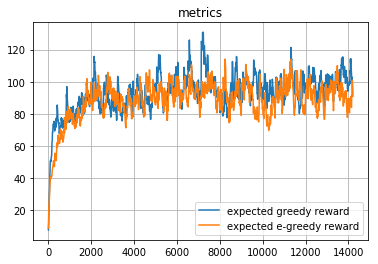

Random session examples


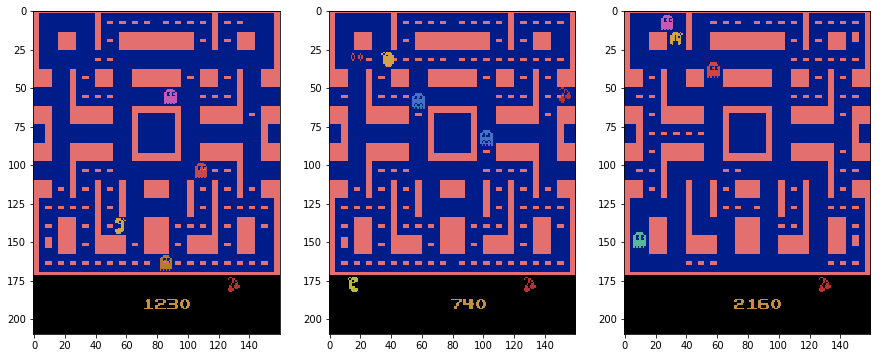

epoch 14210,loss 744.80623, epsilon 0.05000, rewards: ( e-greedy 92.20256, greedy 88.98055) 
rec 744.669 reg 0.137
epoch 14220,loss 1083.04841, epsilon 0.05000, rewards: ( e-greedy 95.73230, greedy 86.95750) 
rec 1082.911 reg 0.137
epoch 14230,loss 1286.26534, epsilon 0.05000, rewards: ( e-greedy 96.59657, greedy 87.88675) 
rec 1286.128 reg 0.137
epoch 14240,loss 1978.78273, epsilon 0.05000, rewards: ( e-greedy 102.12441, greedy 86.78557) 
rec 1978.646 reg 0.137
epoch 14250,loss 739.76925, epsilon 0.05000, rewards: ( e-greedy 102.03697, greedy 89.10701) 
rec 739.632 reg 0.137
epoch 14260,loss 626.32785, epsilon 0.05000, rewards: ( e-greedy 100.58327, greedy 89.25881) 
rec 626.191 reg 0.137
epoch 14270,loss 1169.32207, epsilon 0.05000, rewards: ( e-greedy 102.08745, greedy 88.14543) 
rec 1169.185 reg 0.137
epoch 14280,loss 1703.82271, epsilon 0.05000, rewards: ( e-greedy 101.69120, greedy 91.39339) 
rec 1703.685 reg 0.137
epoch 14290,loss 2047.00964, epsilon 0.05000, rewards: ( e-greedy

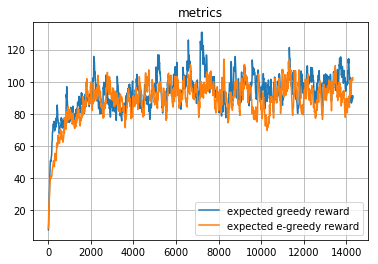

Random session examples


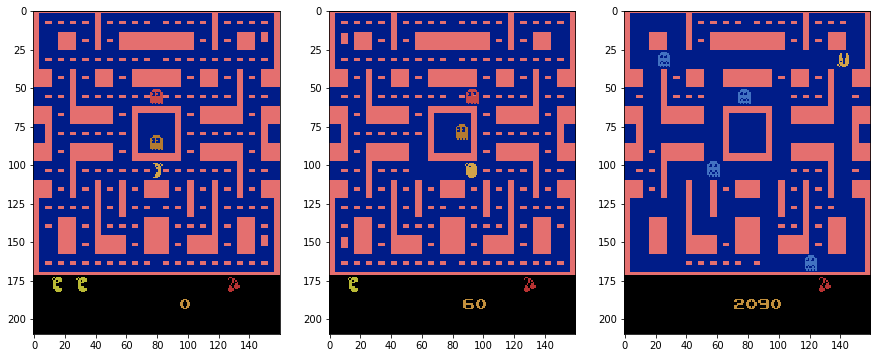

epoch 14310,loss 993.18870, epsilon 0.05000, rewards: ( e-greedy 100.31914, greedy 94.04516) 
rec 993.051 reg 0.137
epoch 14320,loss 611.67354, epsilon 0.05000, rewards: ( e-greedy 96.22472, greedy 94.57814) 
rec 611.536 reg 0.138
epoch 14330,loss 770.11939, epsilon 0.05000, rewards: ( e-greedy 94.03975, greedy 94.37033) 
rec 769.982 reg 0.138
epoch 14340,loss 2483.96379, epsilon 0.05000, rewards: ( e-greedy 98.32328, greedy 88.87079) 
rec 2483.826 reg 0.138
epoch 14350,loss 1662.08885, epsilon 0.05000, rewards: ( e-greedy 99.55345, greedy 92.23371) 
rec 1661.951 reg 0.138
epoch 14360,loss 607.30833, epsilon 0.05000, rewards: ( e-greedy 97.78560, greedy 91.63534) 
rec 607.171 reg 0.138
epoch 14370,loss 6198.04696, epsilon 0.05000, rewards: ( e-greedy 109.00704, greedy 91.22181) 
rec 6197.909 reg 0.138
epoch 14380,loss 550.66204, epsilon 0.05000, rewards: ( e-greedy 104.48134, greedy 88.41213) 
rec 550.524 reg 0.138
epoch 14390,loss 446.73078, epsilon 0.05000, rewards: ( e-greedy 101.72

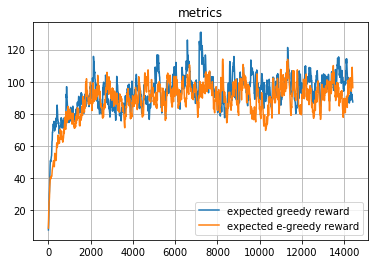

Random session examples


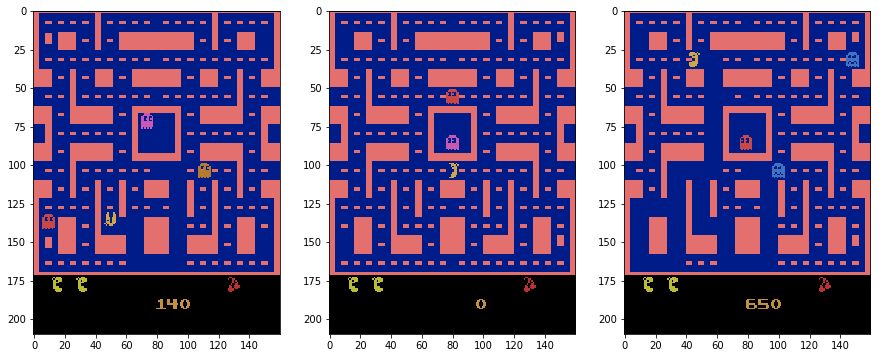

epoch 14410,loss 1439.58300, epsilon 0.05000, rewards: ( e-greedy 95.85627, greedy 90.62182) 
rec 1439.445 reg 0.138
epoch 14420,loss 519.40159, epsilon 0.05000, rewards: ( e-greedy 94.52064, greedy 85.93463) 
rec 519.264 reg 0.138
epoch 14430,loss 3043.62963, epsilon 0.05000, rewards: ( e-greedy 97.13108, greedy 86.96617) 
rec 3043.492 reg 0.138
epoch 14440,loss 308.07743, epsilon 0.05000, rewards: ( e-greedy 91.16797, greedy 83.51955) 
rec 307.939 reg 0.138
epoch 14450,loss 543.07275, epsilon 0.05000, rewards: ( e-greedy 89.42617, greedy 85.16760) 
rec 542.935 reg 0.138
epoch 14460,loss 332.93261, epsilon 0.05000, rewards: ( e-greedy 85.60856, greedy 91.90084) 
rec 332.795 reg 0.138
epoch 14470,loss 446.96321, epsilon 0.05000, rewards: ( e-greedy 84.36020, greedy 92.64825) 
rec 446.825 reg 0.138
epoch 14480,loss 2583.48201, epsilon 0.05000, rewards: ( e-greedy 90.86168, greedy 101.25843) 
rec 2583.344 reg 0.138
epoch 14490,loss 1088.23133, epsilon 0.05000, rewards: ( e-greedy 93.2130

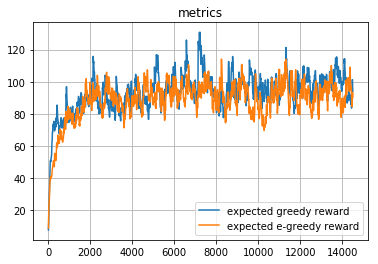

Random session examples


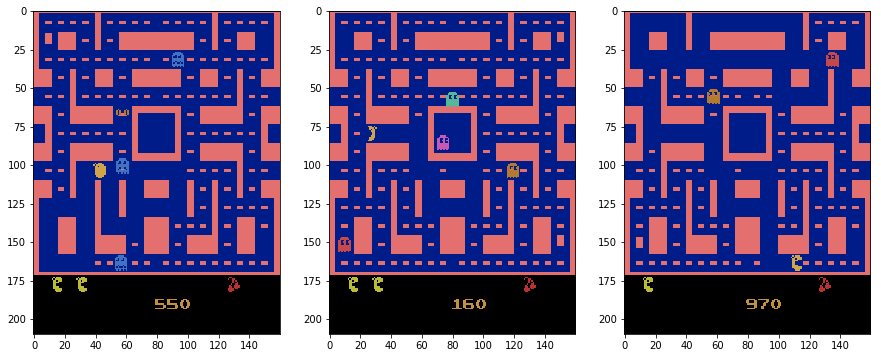

epoch 14510,loss 786.73731, epsilon 0.05000, rewards: ( e-greedy 89.62754, greedy 94.25052) 
rec 786.599 reg 0.138
epoch 14520,loss 1882.26901, epsilon 0.05000, rewards: ( e-greedy 93.85229, greedy 100.51297) 
rec 1882.131 reg 0.138
epoch 14530,loss 2198.73239, epsilon 0.05000, rewards: ( e-greedy 96.27956, greedy 101.02417) 
rec 2198.594 reg 0.138
epoch 14540,loss 1426.11028, epsilon 0.05000, rewards: ( e-greedy 95.40160, greedy 104.85925) 
rec 1425.972 reg 0.138
epoch 14550,loss 441.87750, epsilon 0.05000, rewards: ( e-greedy 92.17394, greedy 101.49833) 
rec 441.739 reg 0.138
epoch 14560,loss 4592.99086, epsilon 0.05000, rewards: ( e-greedy 95.89405, greedy 98.97350) 
rec 4592.853 reg 0.138
epoch 14570,loss 803.43139, epsilon 0.05000, rewards: ( e-greedy 95.36714, greedy 102.07615) 
rec 803.293 reg 0.138
epoch 14580,loss 513.60539, epsilon 0.05000, rewards: ( e-greedy 90.70543, greedy 101.68103) 
rec 513.467 reg 0.138
epoch 14590,loss 1527.85962, epsilon 0.05000, rewards: ( e-greedy 

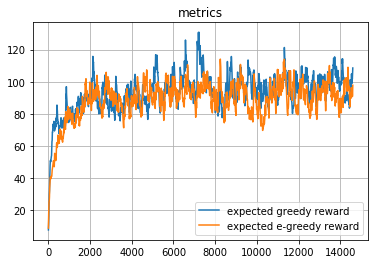

Random session examples


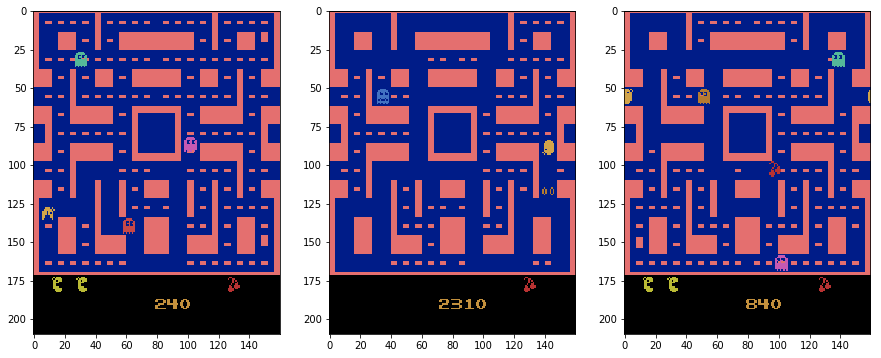

epoch 14610,loss 1684.83421, epsilon 0.05000, rewards: ( e-greedy 101.25551, greedy 108.51235) 
rec 1684.696 reg 0.139
epoch 14620,loss 836.17912, epsilon 0.05000, rewards: ( e-greedy 101.56746, greedy 104.28611) 
rec 836.041 reg 0.139
epoch 14630,loss 1183.00219, epsilon 0.05000, rewards: ( e-greedy 100.66071, greedy 107.23250) 
rec 1182.864 reg 0.139
epoch 14640,loss 915.85656, epsilon 0.05000, rewards: ( e-greedy 99.15714, greedy 103.50925) 
rec 915.718 reg 0.139
epoch 14650,loss 1061.87335, epsilon 0.05000, rewards: ( e-greedy 101.74143, greedy 103.22083) 
rec 1061.735 reg 0.139
epoch 14660,loss 3227.87313, epsilon 0.05000, rewards: ( e-greedy 106.44228, greedy 106.33624) 
rec 3227.734 reg 0.139
epoch 14670,loss 1282.81609, epsilon 0.05000, rewards: ( e-greedy 107.73556, greedy 113.07762) 
rec 1282.677 reg 0.139
epoch 14680,loss 1609.85868, epsilon 0.05000, rewards: ( e-greedy 104.83700, greedy 111.20736) 
rec 1609.720 reg 0.139
epoch 14690,loss 912.26745, epsilon 0.05000, rewards:

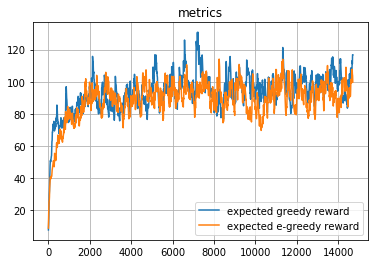

Random session examples


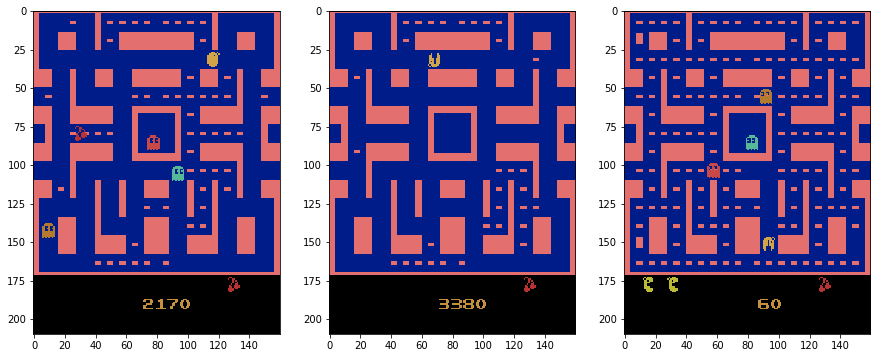

epoch 14710,loss 584.16411, epsilon 0.05000, rewards: ( e-greedy 98.36492, greedy 112.10016) 
rec 584.025 reg 0.139
epoch 14720,loss 478.05404, epsilon 0.05000, rewards: ( e-greedy 94.02843, greedy 111.32765) 
rec 477.915 reg 0.139
epoch 14730,loss 809.49488, epsilon 0.05000, rewards: ( e-greedy 92.12559, greedy 111.00738) 
rec 809.356 reg 0.139
epoch 14740,loss 562.74109, epsilon 0.05000, rewards: ( e-greedy 90.47553, greedy 106.09414) 
rec 562.602 reg 0.139
epoch 14750,loss 1503.11282, epsilon 0.05000, rewards: ( e-greedy 93.55298, greedy 105.10973) 
rec 1502.974 reg 0.139
epoch 14760,loss 868.23698, epsilon 0.05000, rewards: ( e-greedy 94.44768, greedy 104.59876) 
rec 868.098 reg 0.139
epoch 14770,loss 1342.17391, epsilon 0.05000, rewards: ( e-greedy 94.00291, greedy 105.32638) 
rec 1342.035 reg 0.139
epoch 14780,loss 582.12909, epsilon 0.05000, rewards: ( e-greedy 93.66512, greedy 107.10624) 
rec 581.990 reg 0.139
epoch 14790,loss 876.24595, epsilon 0.05000, rewards: ( e-greedy 91.

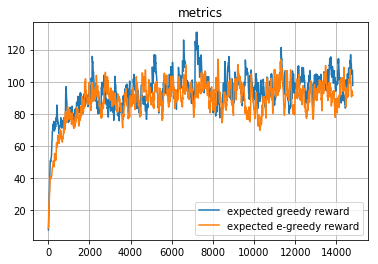

Random session examples


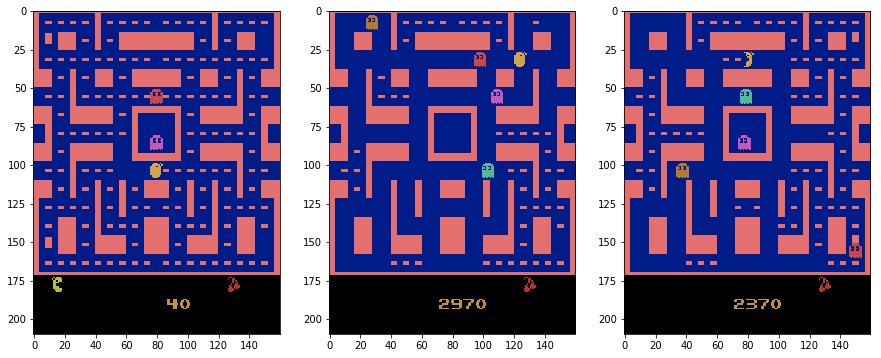

epoch 14810,loss 615.16088, epsilon 0.05000, rewards: ( e-greedy 90.25937, greedy 99.88483) 
rec 615.021 reg 0.139
epoch 14820,loss 862.14771, epsilon 0.05000, rewards: ( e-greedy 91.92093, greedy 109.33384) 
rec 862.008 reg 0.139
epoch 14830,loss 606.35533, epsilon 0.05000, rewards: ( e-greedy 92.97884, greedy 120.21296) 
rec 606.216 reg 0.139
epoch 14840,loss 1875.99752, epsilon 0.05000, rewards: ( e-greedy 100.36846, greedy 117.00416) 
rec 1875.858 reg 0.139
epoch 14850,loss 2998.50388, epsilon 0.05000, rewards: ( e-greedy 106.70661, greedy 122.30375) 
rec 2998.365 reg 0.139
epoch 14860,loss 702.90108, epsilon 0.05000, rewards: ( e-greedy 103.41095, greedy 129.82337) 
rec 702.762 reg 0.139
epoch 14870,loss 1609.05324, epsilon 0.05000, rewards: ( e-greedy 103.81986, greedy 131.34103) 
rec 1608.914 reg 0.140
epoch 14880,loss 1621.72725, epsilon 0.05000, rewards: ( e-greedy 103.06287, greedy 133.39443) 
rec 1621.588 reg 0.140
epoch 14890,loss 941.12548, epsilon 0.05000, rewards: ( e-gr

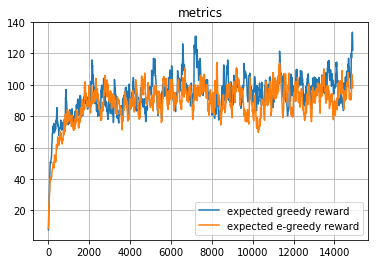

Random session examples


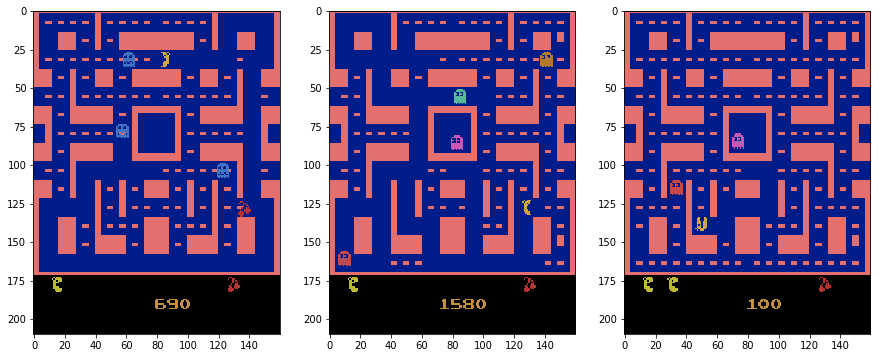

epoch 14910,loss 370.92890, epsilon 0.05000, rewards: ( e-greedy 93.04596, greedy 119.87829) 
rec 370.789 reg 0.140
epoch 14920,loss 414.78785, epsilon 0.05000, rewards: ( e-greedy 89.67886, greedy 115.14046) 
rec 414.648 reg 0.140
epoch 14930,loss 1328.09444, epsilon 0.05000, rewards: ( e-greedy 87.21098, greedy 108.93892) 
rec 1327.955 reg 0.140
epoch 14940,loss 3157.55396, epsilon 0.05000, rewards: ( e-greedy 93.48988, greedy 106.60752) 
rec 3157.414 reg 0.140
epoch 14950,loss 1125.01827, epsilon 0.05000, rewards: ( e-greedy 93.76589, greedy 106.82177) 
rec 1124.878 reg 0.140
epoch 14960,loss 7782.28408, epsilon 0.05000, rewards: ( e-greedy 103.57680, greedy 106.01459) 
rec 7782.144 reg 0.140
epoch 14970,loss 697.68748, epsilon 0.05000, rewards: ( e-greedy 100.46912, greedy 105.66313) 
rec 697.547 reg 0.140
epoch 14980,loss 357.58350, epsilon 0.05000, rewards: ( e-greedy 94.79721, greedy 101.78432) 
rec 357.443 reg 0.140
epoch 14990,loss 960.57941, epsilon 0.05000, rewards: ( e-gree

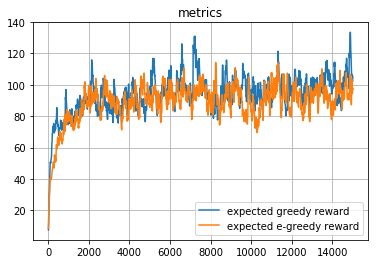

Random session examples


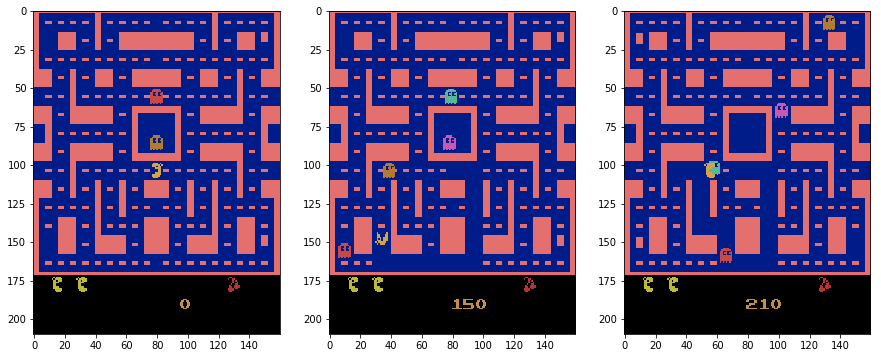

[2017-05-24 22:25:15,873] Making new env: MsPacman-v0
[2017-05-24 22:25:16,037] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 22:25:16,046] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.22.19270.video000000.mp4
[2017-05-24 22:25:17,735] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.22.19270.video000001.mp4


Episode finished after 656 timesteps with reward=240.0
Episode finished after 633 timesteps with reward=240.0
Episode finished after 745 timesteps with reward=250.0
Episode finished after 658 timesteps with reward=240.0
Episode finished after 622 timesteps with reward=240.0
Episode finished after 699 timesteps with reward=280.0
Episode finished after 973 timesteps with reward=240.0


[2017-05-24 22:25:27,723] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.22.19270.video000008.mp4


Episode finished after 1048 timesteps with reward=240.0
Episode finished after 898 timesteps with reward=880.0
Episode finished after 625 timesteps with reward=200.0
Episode finished after 706 timesteps with reward=220.0
Episode finished after 769 timesteps with reward=240.0
Episode finished after 518 timesteps with reward=280.0
Episode finished after 659 timesteps with reward=240.0
Episode finished after 543 timesteps with reward=250.0
Episode finished after 704 timesteps with reward=240.0
Episode finished after 589 timesteps with reward=240.0
Episode finished after 940 timesteps with reward=240.0
Episode finished after 714 timesteps with reward=280.0


[2017-05-24 22:25:42,898] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 638 timesteps with reward=200.0
Mean 274.0, Var 19754.0
epoch 15010,loss 1170.09410, epsilon 0.05000, rewards: ( e-greedy 101.06467, greedy 104.23765) 
rec 1169.954 reg 0.140
epoch 15020,loss 7211.71019, epsilon 0.05000, rewards: ( e-greedy 105.89570, greedy 103.25138) 
rec 7211.570 reg 0.140
epoch 15030,loss 1199.08182, epsilon 0.05000, rewards: ( e-greedy 105.11863, greedy 99.48874) 
rec 1198.941 reg 0.140
epoch 15040,loss 469.61631, epsilon 0.05000, rewards: ( e-greedy 100.66927, greedy 97.72737) 
rec 469.476 reg 0.140
epoch 15050,loss 437.64611, epsilon 0.05000, rewards: ( e-greedy 96.78984, greedy 96.01713) 
rec 437.506 reg 0.140
epoch 15060,loss 723.47359, epsilon 0.05000, rewards: ( e-greedy 95.54836, greedy 96.85292) 
rec 723.333 reg 0.140
epoch 15070,loss 1052.26789, epsilon 0.05000, rewards: ( e-greedy 95.11852, greedy 93.85513) 
rec 1052.127 reg 0.141
epoch 15080,loss 1054.19022, epsilon 0.05000, rewards: ( e-greedy 94.29417, greedy 96.28211) 
rec 1054

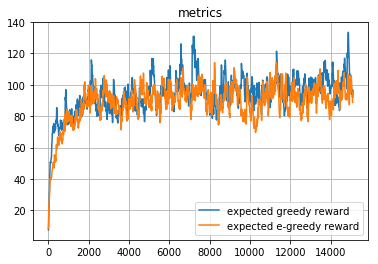

Random session examples


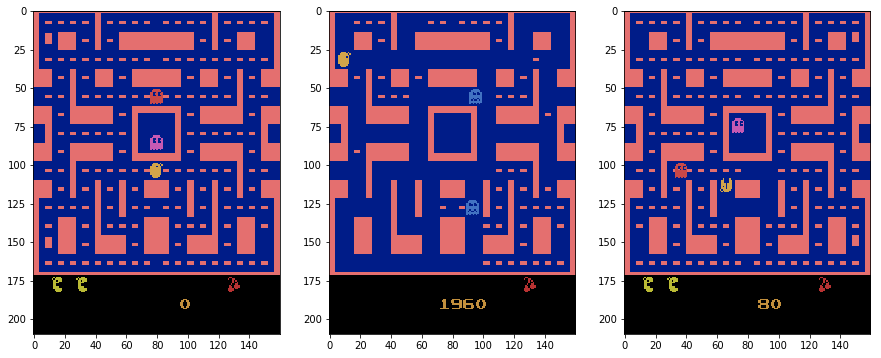

epoch 15110,loss 811.03253, epsilon 0.05000, rewards: ( e-greedy 89.32170, greedy 97.26029) 
rec 810.892 reg 0.141
epoch 15120,loss 434.44681, epsilon 0.05000, rewards: ( e-greedy 87.63953, greedy 95.15926) 
rec 434.306 reg 0.141
epoch 15130,loss 419.15502, epsilon 0.05000, rewards: ( e-greedy 85.12558, greedy 92.39333) 
rec 419.014 reg 0.141
epoch 15140,loss 480.30004, epsilon 0.05000, rewards: ( e-greedy 81.80052, greedy 91.52900) 
rec 480.159 reg 0.141
epoch 15150,loss 2158.08661, epsilon 0.05000, rewards: ( e-greedy 83.24547, greedy 85.56360) 
rec 2157.946 reg 0.141
epoch 15160,loss 605.04685, epsilon 0.05000, rewards: ( e-greedy 81.85842, greedy 84.06974) 
rec 604.906 reg 0.141
epoch 15170,loss 1188.88237, epsilon 0.05000, rewards: ( e-greedy 83.48508, greedy 89.10026) 
rec 1188.741 reg 0.141
epoch 15180,loss 1970.60494, epsilon 0.05000, rewards: ( e-greedy 86.51157, greedy 84.56524) 
rec 1970.464 reg 0.141
epoch 15190,loss 834.17726, epsilon 0.05000, rewards: ( e-greedy 85.67291,

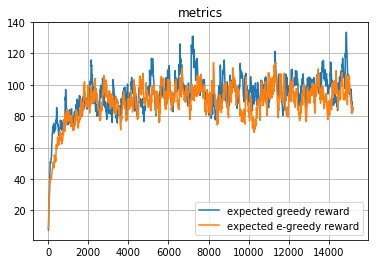

Random session examples


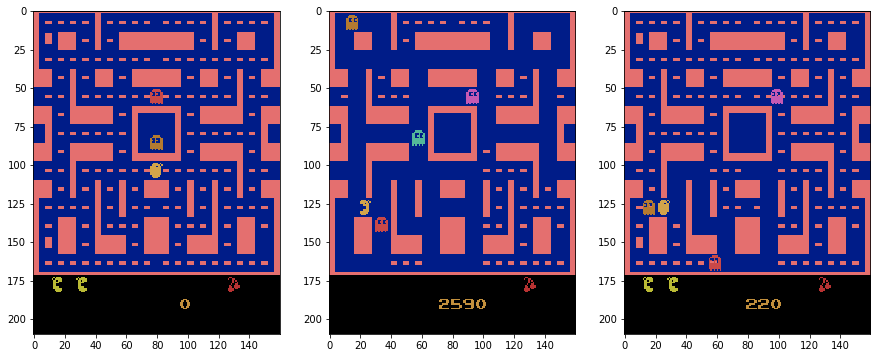

epoch 15210,loss 747.78311, epsilon 0.05000, rewards: ( e-greedy 85.78881, greedy 84.05493) 
rec 747.642 reg 0.141
epoch 15220,loss 944.67921, epsilon 0.05000, rewards: ( e-greedy 85.58493, greedy 98.39944) 
rec 944.538 reg 0.141
epoch 15230,loss 1107.33620, epsilon 0.05000, rewards: ( e-greedy 85.46394, greedy 101.12200) 
rec 1107.195 reg 0.141
epoch 15240,loss 746.56901, epsilon 0.05000, rewards: ( e-greedy 85.41754, greedy 106.32230) 
rec 746.428 reg 0.141
epoch 15250,loss 477.72955, epsilon 0.05000, rewards: ( e-greedy 83.12579, greedy 106.00257) 
rec 477.588 reg 0.141
epoch 15260,loss 2237.27229, epsilon 0.05000, rewards: ( e-greedy 90.75071, greedy 119.46481) 
rec 2237.131 reg 0.141
epoch 15270,loss 1664.68154, epsilon 0.05000, rewards: ( e-greedy 89.23814, greedy 118.26833) 
rec 1664.540 reg 0.142
epoch 15280,loss 1729.47806, epsilon 0.05000, rewards: ( e-greedy 92.62682, greedy 127.12900) 
rec 1729.337 reg 0.142
epoch 15290,loss 323.39571, epsilon 0.05000, rewards: ( e-greedy 8

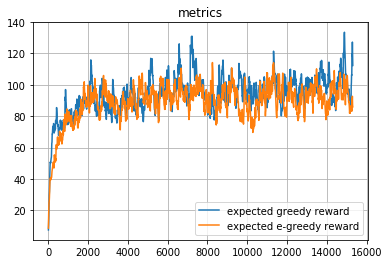

Random session examples


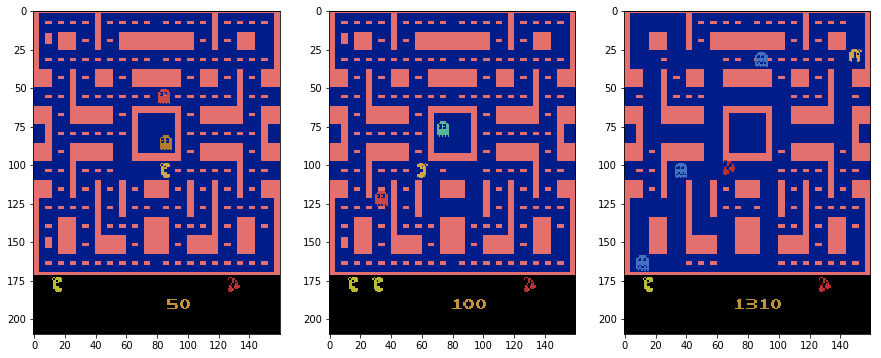

epoch 15310,loss 8403.60350, epsilon 0.05000, rewards: ( e-greedy 99.75558, greedy 107.79141) 
rec 8403.462 reg 0.142
epoch 15320,loss 743.80299, epsilon 0.05000, rewards: ( e-greedy 94.40502, greedy 101.32477) 
rec 743.661 reg 0.142
epoch 15330,loss 2005.55559, epsilon 0.05000, rewards: ( e-greedy 93.96452, greedy 100.75479) 
rec 2005.414 reg 0.142
epoch 15340,loss 393.37831, epsilon 0.05000, rewards: ( e-greedy 91.44307, greedy 97.67932) 
rec 393.237 reg 0.142
epoch 15350,loss 1775.06876, epsilon 0.05000, rewards: ( e-greedy 93.54876, greedy 96.16138) 
rec 1774.927 reg 0.142
epoch 15360,loss 1894.68136, epsilon 0.05000, rewards: ( e-greedy 95.00638, greedy 93.48275) 
rec 1894.540 reg 0.142
epoch 15370,loss 726.84637, epsilon 0.05000, rewards: ( e-greedy 92.75575, greedy 94.57197) 
rec 726.705 reg 0.142
epoch 15380,loss 844.65591, epsilon 0.05000, rewards: ( e-greedy 92.66767, greedy 92.86477) 
rec 844.514 reg 0.142
epoch 15390,loss 364.67251, epsilon 0.05000, rewards: ( e-greedy 90.5

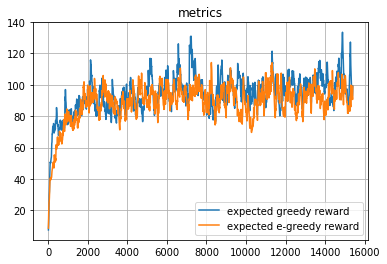

Random session examples


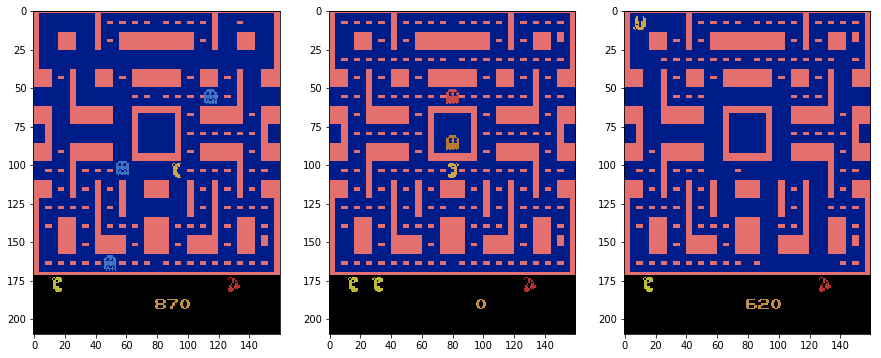

epoch 15410,loss 880.86951, epsilon 0.05000, rewards: ( e-greedy 98.13286, greedy 100.28280) 
rec 880.728 reg 0.142
epoch 15420,loss 493.05190, epsilon 0.05000, rewards: ( e-greedy 95.06957, greedy 95.62952) 
rec 492.910 reg 0.142
epoch 15430,loss 4340.66881, epsilon 0.05000, rewards: ( e-greedy 113.00011, greedy 96.87906) 
rec 4340.527 reg 0.142
epoch 15440,loss 4249.81875, epsilon 0.05000, rewards: ( e-greedy 111.57510, greedy 92.56616) 
rec 4249.677 reg 0.142
epoch 15450,loss 517.25647, epsilon 0.05000, rewards: ( e-greedy 106.04259, greedy 95.37204) 
rec 517.114 reg 0.142
epoch 15460,loss 1832.20624, epsilon 0.05000, rewards: ( e-greedy 108.12583, greedy 99.39734) 
rec 1832.064 reg 0.142
epoch 15470,loss 680.05009, epsilon 0.05000, rewards: ( e-greedy 104.43825, greedy 95.02010) 
rec 679.908 reg 0.142
epoch 15480,loss 723.33248, epsilon 0.05000, rewards: ( e-greedy 102.61943, greedy 97.51809) 
rec 723.190 reg 0.142
epoch 15490,loss 479.78500, epsilon 0.05000, rewards: ( e-greedy 99

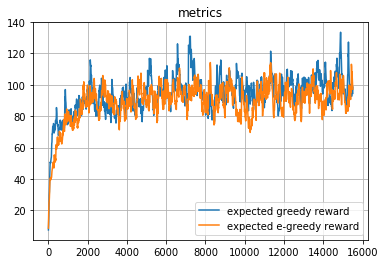

Random session examples


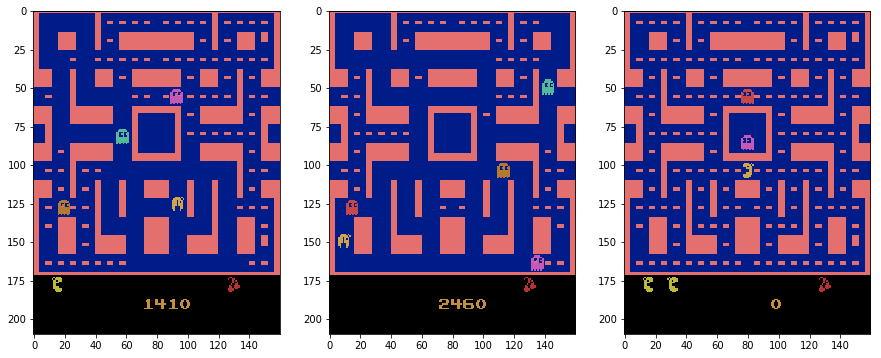

epoch 15510,loss 601.27707, epsilon 0.05000, rewards: ( e-greedy 94.68206, greedy 96.11444) 
rec 601.135 reg 0.142
epoch 15520,loss 395.16763, epsilon 0.05000, rewards: ( e-greedy 90.08885, greedy 93.81550) 
rec 395.025 reg 0.142
epoch 15530,loss 4784.79272, epsilon 0.05000, rewards: ( e-greedy 98.14247, greedy 96.55895) 
rec 4784.650 reg 0.142
epoch 15540,loss 533.72417, epsilon 0.05000, rewards: ( e-greedy 92.89072, greedy 95.09055) 
rec 533.582 reg 0.142
epoch 15550,loss 673.99422, epsilon 0.05000, rewards: ( e-greedy 90.41415, greedy 92.51900) 
rec 673.852 reg 0.142
epoch 15560,loss 426.42633, epsilon 0.05000, rewards: ( e-greedy 88.49774, greedy 91.26710) 
rec 426.284 reg 0.142
epoch 15570,loss 1577.78186, epsilon 0.05000, rewards: ( e-greedy 93.08546, greedy 92.01539) 
rec 1577.640 reg 0.142
epoch 15580,loss 1243.20946, epsilon 0.05000, rewards: ( e-greedy 97.52692, greedy 105.62635) 
rec 1243.067 reg 0.142
epoch 15590,loss 379.76494, epsilon 0.05000, rewards: ( e-greedy 92.89922

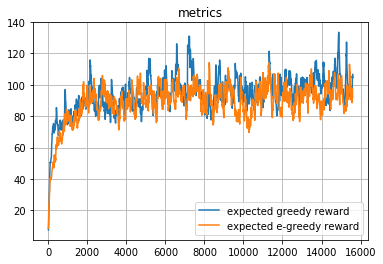

Random session examples


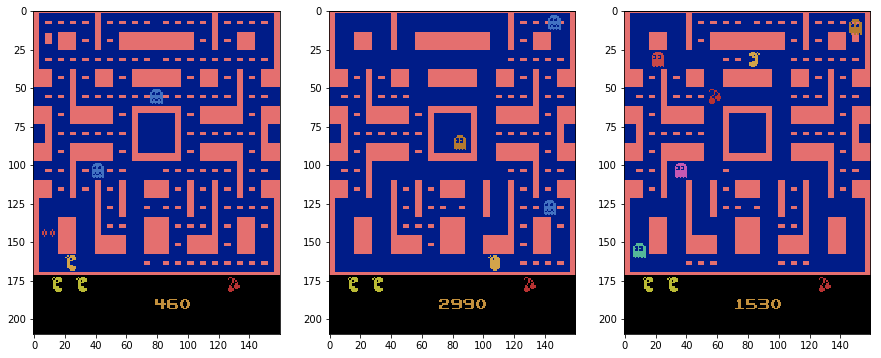

epoch 15610,loss 846.39843, epsilon 0.05000, rewards: ( e-greedy 90.71712, greedy 106.80536) 
rec 846.256 reg 0.142
epoch 15620,loss 1283.44643, epsilon 0.05000, rewards: ( e-greedy 90.39541, greedy 111.37482) 
rec 1283.304 reg 0.142
epoch 15630,loss 1239.31077, epsilon 0.05000, rewards: ( e-greedy 90.85587, greedy 107.48734) 
rec 1239.168 reg 0.142
epoch 15640,loss 328.47943, epsilon 0.05000, rewards: ( e-greedy 85.64528, greedy 110.36361) 
rec 328.337 reg 0.142
epoch 15650,loss 817.08832, epsilon 0.05000, rewards: ( e-greedy 82.83075, greedy 106.82725) 
rec 816.946 reg 0.143
epoch 15660,loss 510.03205, epsilon 0.05000, rewards: ( e-greedy 81.54768, greedy 110.83202) 
rec 509.889 reg 0.143
epoch 15670,loss 364.54188, epsilon 0.05000, rewards: ( e-greedy 76.83041, greedy 102.37382) 
rec 364.399 reg 0.143
epoch 15680,loss 591.39335, epsilon 0.05000, rewards: ( e-greedy 76.14737, greedy 101.26144) 
rec 591.251 reg 0.143
epoch 15690,loss 5960.14715, epsilon 0.05000, rewards: ( e-greedy 82

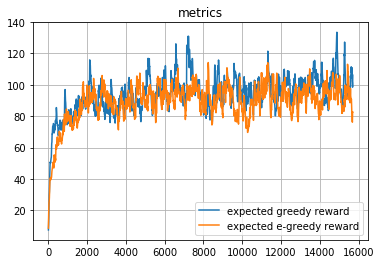

Random session examples


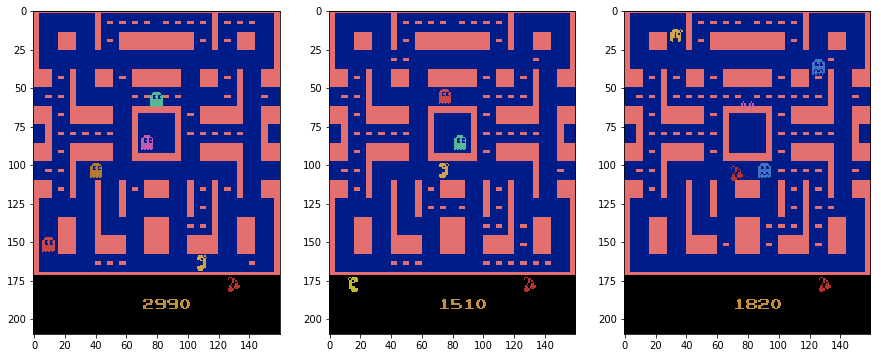

epoch 15710,loss 1283.53872, epsilon 0.05000, rewards: ( e-greedy 82.90143, greedy 103.99896) 
rec 1283.396 reg 0.143
epoch 15720,loss 1083.24261, epsilon 0.05000, rewards: ( e-greedy 83.61129, greedy 114.28657) 
rec 1083.100 reg 0.143
epoch 15730,loss 2289.02034, epsilon 0.05000, rewards: ( e-greedy 88.50016, greedy 114.85791) 
rec 2288.877 reg 0.143
epoch 15740,loss 1352.41753, epsilon 0.05000, rewards: ( e-greedy 89.46264, greedy 111.49712) 
rec 1352.275 reg 0.143
epoch 15750,loss 576.61337, epsilon 0.05000, rewards: ( e-greedy 88.45388, greedy 108.65991) 
rec 576.470 reg 0.143
epoch 15760,loss 1002.55837, epsilon 0.05000, rewards: ( e-greedy 92.48349, greedy 122.60642) 
rec 1002.415 reg 0.143
epoch 15770,loss 1017.47829, epsilon 0.05000, rewards: ( e-greedy 91.98514, greedy 122.15827) 
rec 1017.335 reg 0.143
epoch 15780,loss 6549.33892, epsilon 0.05000, rewards: ( e-greedy 102.78663, greedy 116.56745) 
rec 6549.196 reg 0.143
epoch 15790,loss 1852.83088, epsilon 0.05000, rewards: ( 

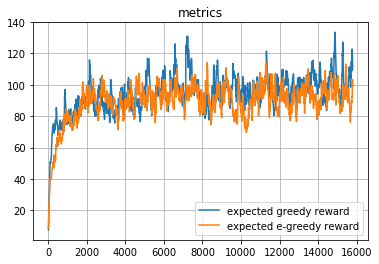

Random session examples


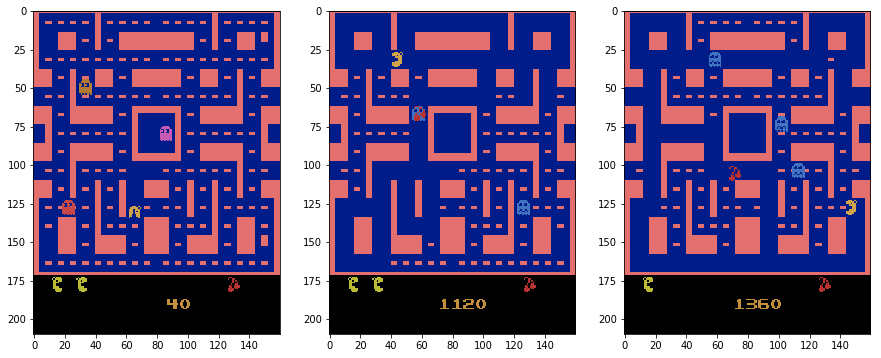

epoch 15810,loss 1156.10774, epsilon 0.05000, rewards: ( e-greedy 101.80145, greedy 110.06892) 
rec 1155.964 reg 0.143
epoch 15820,loss 464.59852, epsilon 0.05000, rewards: ( e-greedy 98.93381, greedy 106.06203) 
rec 464.455 reg 0.143
epoch 15830,loss 1819.27258, epsilon 0.05000, rewards: ( e-greedy 102.22793, greedy 107.33082) 
rec 1819.129 reg 0.143
epoch 15840,loss 484.97667, epsilon 0.05000, rewards: ( e-greedy 99.75513, greedy 108.22274) 
rec 484.833 reg 0.143
epoch 15850,loss 1821.66969, epsilon 0.05000, rewards: ( e-greedy 97.34212, greedy 109.77547) 
rec 1821.526 reg 0.143
epoch 15860,loss 1447.85531, epsilon 0.05000, rewards: ( e-greedy 96.23291, greedy 107.98542) 
rec 1447.712 reg 0.143
epoch 15870,loss 1710.66801, epsilon 0.05000, rewards: ( e-greedy 97.29712, greedy 110.37438) 
rec 1710.525 reg 0.143
epoch 15880,loss 350.52955, epsilon 0.05000, rewards: ( e-greedy 91.00491, greedy 107.08694) 
rec 350.386 reg 0.143
epoch 15890,loss 1396.01430, epsilon 0.05000, rewards: ( e-g

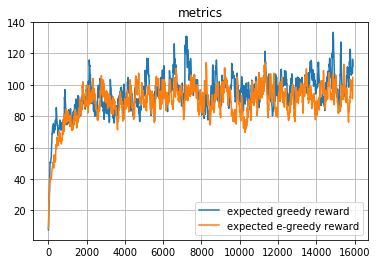

Random session examples


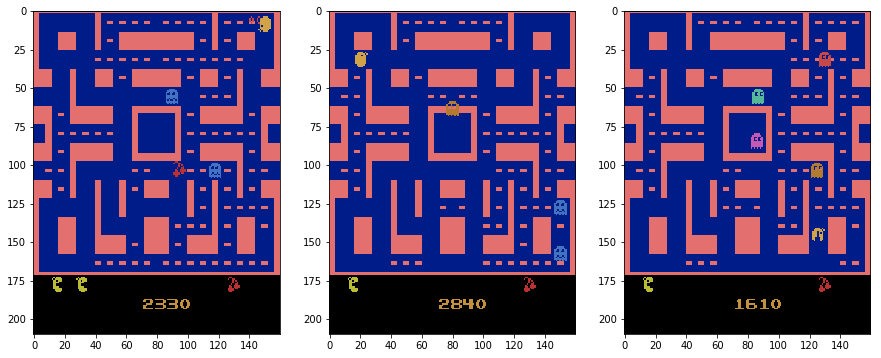

epoch 15910,loss 672.66618, epsilon 0.05000, rewards: ( e-greedy 102.12945, greedy 106.47700) 
rec 672.522 reg 0.144
epoch 15920,loss 1736.15633, epsilon 0.05000, rewards: ( e-greedy 99.22901, greedy 110.57930) 
rec 1736.013 reg 0.144
epoch 15930,loss 2660.95160, epsilon 0.05000, rewards: ( e-greedy 104.36861, greedy 109.52137) 
rec 2660.808 reg 0.144
epoch 15940,loss 1039.00606, epsilon 0.05000, rewards: ( e-greedy 101.80674, greedy 105.25674) 
rec 1038.862 reg 0.144
epoch 15950,loss 992.81957, epsilon 0.05000, rewards: ( e-greedy 97.56357, greedy 103.35606) 
rec 992.676 reg 0.144
epoch 15960,loss 1698.28726, epsilon 0.05000, rewards: ( e-greedy 95.18221, greedy 98.45796) 
rec 1698.143 reg 0.144
epoch 15970,loss 1474.38706, epsilon 0.05000, rewards: ( e-greedy 92.66399, greedy 96.67466) 
rec 1474.243 reg 0.144
epoch 15980,loss 797.33525, epsilon 0.05000, rewards: ( e-greedy 92.89759, greedy 102.06969) 
rec 797.191 reg 0.144
epoch 15990,loss 904.07360, epsilon 0.05000, rewards: ( e-gre

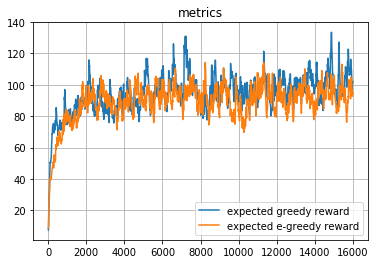

Random session examples


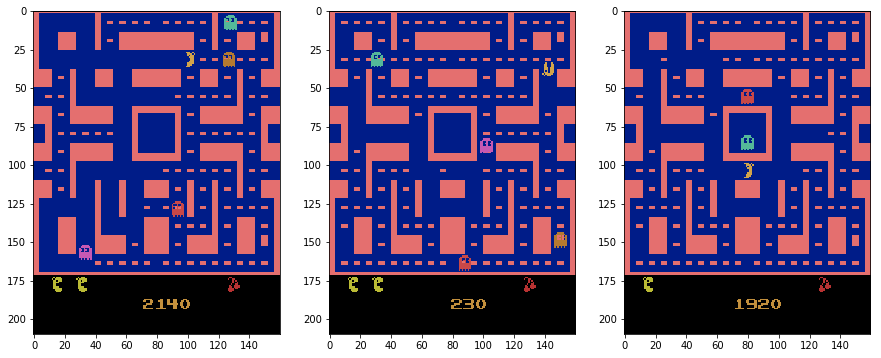

[2017-05-24 22:51:33,416] Making new env: MsPacman-v0
[2017-05-24 22:51:33,580] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 22:51:33,589] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.23.19270.video000000.mp4
[2017-05-24 22:51:34,794] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.23.19270.video000001.mp4


Episode finished after 428 timesteps with reward=60.0
Episode finished after 624 timesteps with reward=350.0
Episode finished after 360 timesteps with reward=70.0
Episode finished after 403 timesteps with reward=170.0
Episode finished after 615 timesteps with reward=120.0
Episode finished after 468 timesteps with reward=110.0
Episode finished after 579 timesteps with reward=350.0


[2017-05-24 22:51:41,761] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.23.19270.video000008.mp4


Episode finished after 568 timesteps with reward=160.0
Episode finished after 445 timesteps with reward=200.0
Episode finished after 591 timesteps with reward=260.0
Episode finished after 572 timesteps with reward=230.0
Episode finished after 430 timesteps with reward=100.0
Episode finished after 492 timesteps with reward=280.0
Episode finished after 510 timesteps with reward=120.0
Episode finished after 499 timesteps with reward=120.0
Episode finished after 674 timesteps with reward=340.0
Episode finished after 539 timesteps with reward=250.0
Episode finished after 635 timesteps with reward=300.0
Episode finished after 671 timesteps with reward=350.0


[2017-05-24 22:51:54,536] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 745 timesteps with reward=610.0
Mean 227.5, Var 16988.75
epoch 16010,loss 950.01712, epsilon 0.05000, rewards: ( e-greedy 93.08422, greedy 101.56631) 
rec 949.873 reg 0.144
epoch 16020,loss 751.48440, epsilon 0.05000, rewards: ( e-greedy 91.21330, greedy 100.72218) 
rec 751.341 reg 0.144
epoch 16030,loss 663.68378, epsilon 0.05000, rewards: ( e-greedy 90.02947, greedy 99.33746) 
rec 663.540 reg 0.144
epoch 16040,loss 468.28060, epsilon 0.05000, rewards: ( e-greedy 86.83902, greedy 98.59121) 
rec 468.136 reg 0.144
epoch 16050,loss 2013.20485, epsilon 0.05000, rewards: ( e-greedy 91.96762, greedy 98.04459) 
rec 2013.061 reg 0.144
epoch 16060,loss 1516.28843, epsilon 0.05000, rewards: ( e-greedy 90.14586, greedy 100.61513) 
rec 1516.144 reg 0.144
epoch 16070,loss 878.37576, epsilon 0.05000, rewards: ( e-greedy 92.63127, greedy 103.86612) 
rec 878.232 reg 0.144
epoch 16080,loss 649.39761, epsilon 0.05000, rewards: ( e-greedy 92.43064, greedy 104.29201) 
rec 649.254 r

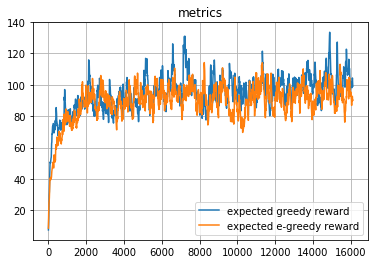

Random session examples


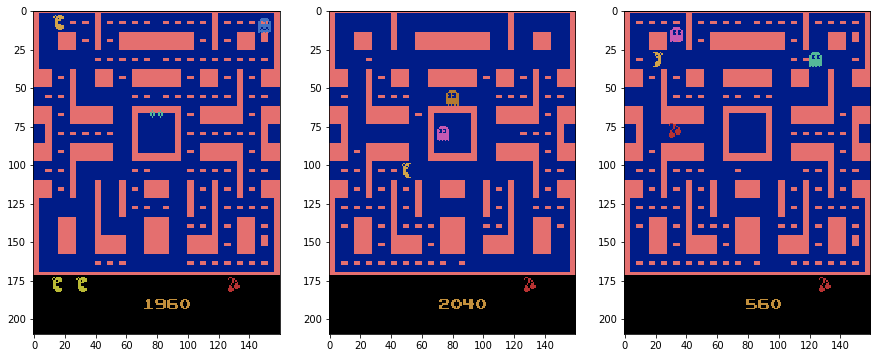

epoch 16110,loss 1274.47992, epsilon 0.05000, rewards: ( e-greedy 90.19194, greedy 96.98200) 
rec 1274.336 reg 0.144
epoch 16120,loss 685.85779, epsilon 0.05000, rewards: ( e-greedy 86.92275, greedy 102.78380) 
rec 685.714 reg 0.144
epoch 16130,loss 415.09211, epsilon 0.05000, rewards: ( e-greedy 83.23047, greedy 101.13042) 
rec 414.948 reg 0.144
epoch 16140,loss 2409.36451, epsilon 0.05000, rewards: ( e-greedy 89.46992, greedy 102.45488) 
rec 2409.220 reg 0.144
epoch 16150,loss 1164.01226, epsilon 0.05000, rewards: ( e-greedy 90.02293, greedy 98.58439) 
rec 1163.868 reg 0.144
epoch 16160,loss 1790.44797, epsilon 0.05000, rewards: ( e-greedy 90.52064, greedy 100.03845) 
rec 1790.304 reg 0.144
epoch 16170,loss 270.79322, epsilon 0.05000, rewards: ( e-greedy 85.03107, greedy 96.22211) 
rec 270.649 reg 0.144
epoch 16180,loss 1435.88413, epsilon 0.05000, rewards: ( e-greedy 87.96547, greedy 98.97489) 
rec 1435.740 reg 0.145
epoch 16190,loss 1467.50895, epsilon 0.05000, rewards: ( e-greedy 

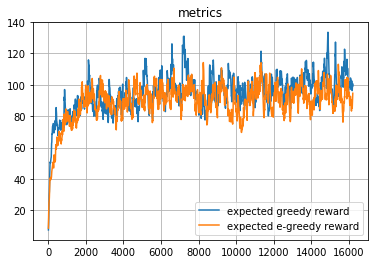

Random session examples


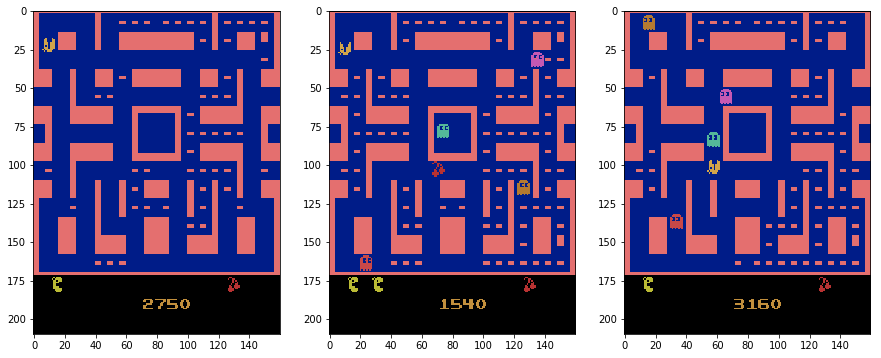

epoch 16210,loss 375.24051, epsilon 0.05000, rewards: ( e-greedy 92.40933, greedy 103.70645) 
rec 375.096 reg 0.145
epoch 16220,loss 1647.05651, epsilon 0.05000, rewards: ( e-greedy 94.98089, greedy 103.96080) 
rec 1646.912 reg 0.145
epoch 16230,loss 366.51947, epsilon 0.05000, rewards: ( e-greedy 90.42030, greedy 99.37722) 
rec 366.375 reg 0.145
epoch 16240,loss 1768.21062, epsilon 0.05000, rewards: ( e-greedy 94.00327, greedy 105.12700) 
rec 1768.066 reg 0.145
epoch 16250,loss 1636.48370, epsilon 0.05000, rewards: ( e-greedy 95.60295, greedy 118.80180) 
rec 1636.339 reg 0.145
epoch 16260,loss 5520.70258, epsilon 0.05000, rewards: ( e-greedy 98.85515, greedy 113.54662) 
rec 5520.558 reg 0.145
epoch 16270,loss 1262.65802, epsilon 0.05000, rewards: ( e-greedy 98.28214, greedy 107.69196) 
rec 1262.513 reg 0.145
epoch 16280,loss 2014.42900, epsilon 0.05000, rewards: ( e-greedy 98.51642, greedy 125.17276) 
rec 2014.284 reg 0.145
epoch 16290,loss 1360.07172, epsilon 0.05000, rewards: ( e-gr

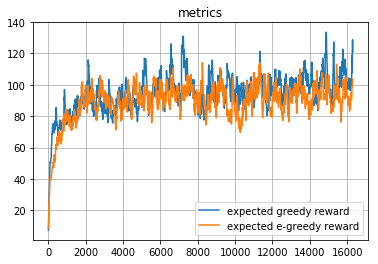

Random session examples


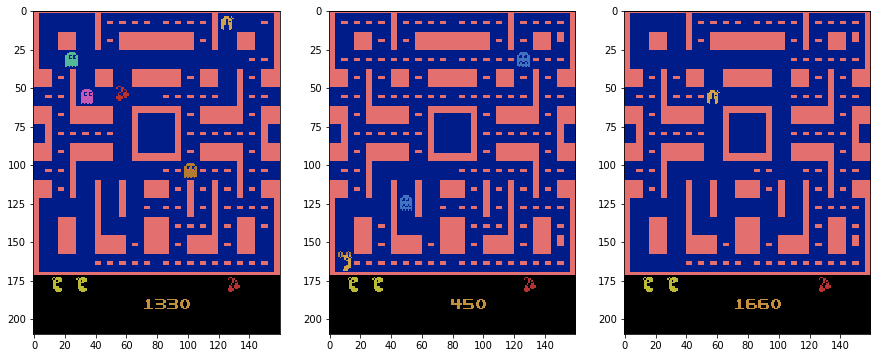

epoch 16310,loss 410.41916, epsilon 0.05000, rewards: ( e-greedy 101.23785, greedy 115.97344) 
rec 410.274 reg 0.145
epoch 16320,loss 1568.07191, epsilon 0.05000, rewards: ( e-greedy 104.30156, greedy 122.75110) 
rec 1567.927 reg 0.145
epoch 16330,loss 479.29745, epsilon 0.05000, rewards: ( e-greedy 98.12141, greedy 117.72599) 
rec 479.152 reg 0.145
epoch 16340,loss 956.77656, epsilon 0.05000, rewards: ( e-greedy 100.37177, greedy 121.95339) 
rec 956.631 reg 0.145
epoch 16350,loss 2876.05241, epsilon 0.05000, rewards: ( e-greedy 103.27209, greedy 118.63305) 
rec 2875.907 reg 0.145
epoch 16360,loss 6178.76997, epsilon 0.05000, rewards: ( e-greedy 106.88238, greedy 127.14475) 
rec 6178.625 reg 0.145
epoch 16370,loss 380.40618, epsilon 0.05000, rewards: ( e-greedy 103.06914, greedy 121.43027) 
rec 380.261 reg 0.146
epoch 16380,loss 1306.68825, epsilon 0.05000, rewards: ( e-greedy 103.88723, greedy 120.91224) 
rec 1306.543 reg 0.146
epoch 16390,loss 937.64951, epsilon 0.05000, rewards: ( e

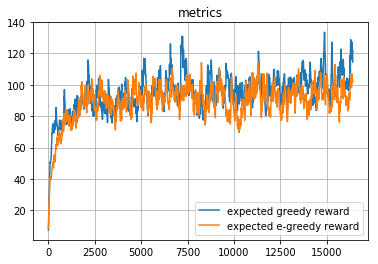

Random session examples


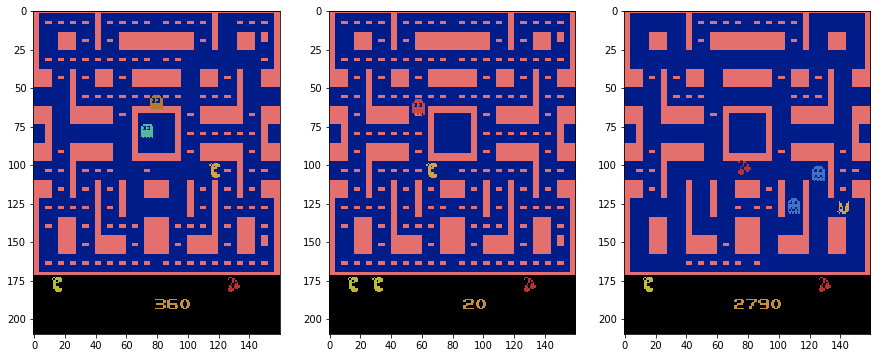

epoch 16410,loss 743.97890, epsilon 0.05000, rewards: ( e-greedy 100.65504, greedy 109.56940) 
rec 743.833 reg 0.146
epoch 16420,loss 904.49819, epsilon 0.05000, rewards: ( e-greedy 98.33954, greedy 108.54996) 
rec 904.352 reg 0.146
epoch 16430,loss 648.35250, epsilon 0.05000, rewards: ( e-greedy 97.06808, greedy 110.81997) 
rec 648.207 reg 0.146
epoch 16440,loss 1658.14515, epsilon 0.05000, rewards: ( e-greedy 95.23627, greedy 104.80047) 
rec 1657.999 reg 0.146
epoch 16450,loss 444.19445, epsilon 0.05000, rewards: ( e-greedy 91.77515, greedy 102.38292) 
rec 444.049 reg 0.146
epoch 16460,loss 481.51623, epsilon 0.05000, rewards: ( e-greedy 92.97263, greedy 104.26963) 
rec 481.370 reg 0.146
epoch 16470,loss 604.72935, epsilon 0.05000, rewards: ( e-greedy 91.73787, greedy 101.84267) 
rec 604.583 reg 0.146
epoch 16480,loss 6065.61119, epsilon 0.05000, rewards: ( e-greedy 100.81408, greedy 115.65840) 
rec 6065.465 reg 0.146
epoch 16490,loss 2891.74487, epsilon 0.05000, rewards: ( e-greedy 

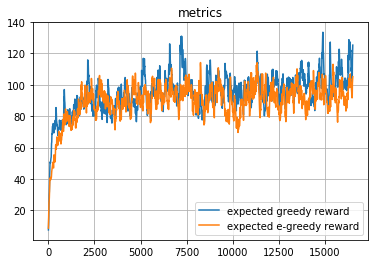

Random session examples


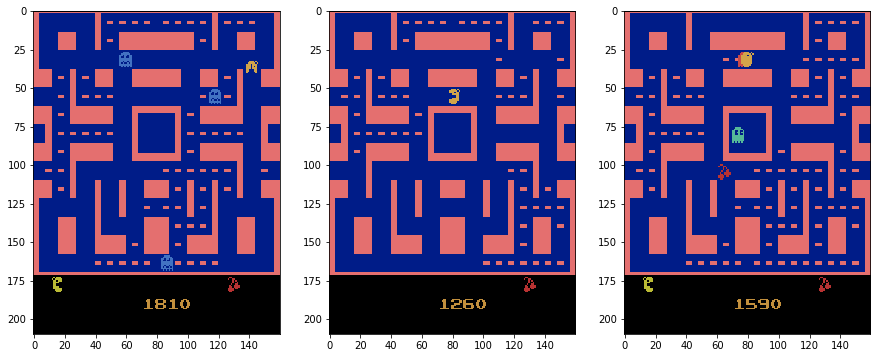

epoch 16510,loss 666.50415, epsilon 0.05000, rewards: ( e-greedy 100.97347, greedy 119.61935) 
rec 666.358 reg 0.146
epoch 16520,loss 403.53057, epsilon 0.05000, rewards: ( e-greedy 96.37612, greedy 113.59491) 
rec 403.384 reg 0.146
epoch 16530,loss 1099.58772, epsilon 0.05000, rewards: ( e-greedy 100.98851, greedy 114.11042) 
rec 1099.442 reg 0.146
epoch 16540,loss 3210.07138, epsilon 0.05000, rewards: ( e-greedy 106.63966, greedy 125.94938) 
rec 3209.925 reg 0.146
epoch 16550,loss 366.74258, epsilon 0.05000, rewards: ( e-greedy 100.78819, greedy 125.35444) 
rec 366.596 reg 0.146
epoch 16560,loss 1355.49693, epsilon 0.05000, rewards: ( e-greedy 100.70937, greedy 118.56900) 
rec 1355.351 reg 0.146
epoch 16570,loss 266.64832, epsilon 0.05000, rewards: ( e-greedy 94.51343, greedy 114.96210) 
rec 266.502 reg 0.146
epoch 16580,loss 1663.26801, epsilon 0.05000, rewards: ( e-greedy 96.43709, greedy 112.65339) 
rec 1663.122 reg 0.146
epoch 16590,loss 1543.90243, epsilon 0.05000, rewards: ( e-

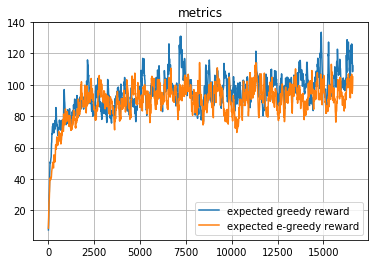

Random session examples


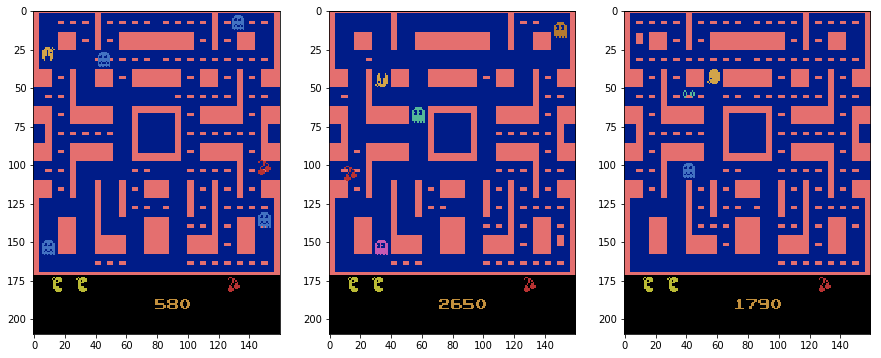

epoch 16610,loss 348.96140, epsilon 0.05000, rewards: ( e-greedy 98.96764, greedy 108.73682) 
rec 348.815 reg 0.146
epoch 16620,loss 2130.34009, epsilon 0.05000, rewards: ( e-greedy 99.07088, greedy 105.86314) 
rec 2130.194 reg 0.146
epoch 16630,loss 4488.94879, epsilon 0.05000, rewards: ( e-greedy 106.53879, greedy 103.40182) 
rec 4488.802 reg 0.147
epoch 16640,loss 849.74772, epsilon 0.05000, rewards: ( e-greedy 104.44741, greedy 102.49914) 
rec 849.601 reg 0.147
epoch 16650,loss 747.83102, epsilon 0.05000, rewards: ( e-greedy 101.25267, greedy 99.43673) 
rec 747.684 reg 0.147
epoch 16660,loss 1682.95213, epsilon 0.05000, rewards: ( e-greedy 102.50240, greedy 96.11805) 
rec 1682.806 reg 0.147
epoch 16670,loss 377.14766, epsilon 0.05000, rewards: ( e-greedy 97.43966, greedy 99.69375) 
rec 377.001 reg 0.147
epoch 16680,loss 1422.46824, epsilon 0.05000, rewards: ( e-greedy 96.88320, greedy 99.47437) 
rec 1422.321 reg 0.147
epoch 16690,loss 430.51636, epsilon 0.05000, rewards: ( e-greedy

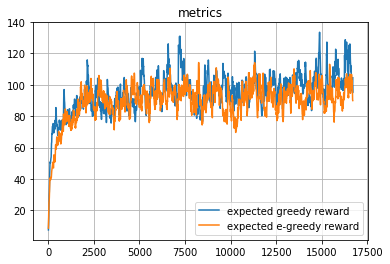

Random session examples


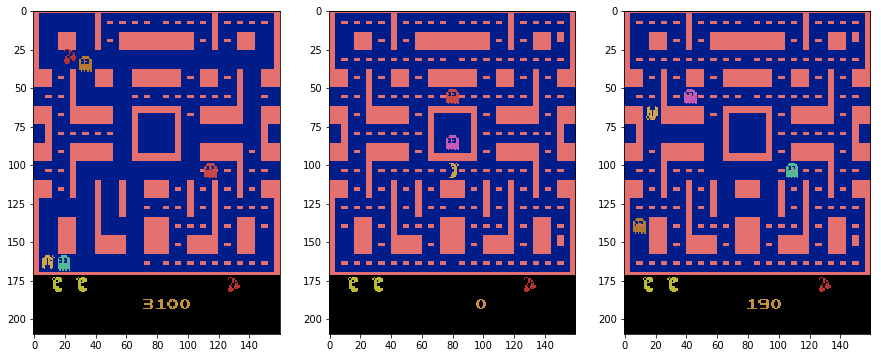

epoch 16710,loss 1778.22911, epsilon 0.05000, rewards: ( e-greedy 91.72285, greedy 98.97619) 
rec 1778.082 reg 0.147
epoch 16720,loss 589.03167, epsilon 0.05000, rewards: ( e-greedy 90.11306, greedy 95.76607) 
rec 588.885 reg 0.147
epoch 16730,loss 2531.94775, epsilon 0.05000, rewards: ( e-greedy 98.47676, greedy 97.62697) 
rec 2531.801 reg 0.147
epoch 16740,loss 1087.98466, epsilon 0.05000, rewards: ( e-greedy 100.00408, greedy 107.11427) 
rec 1087.838 reg 0.147
epoch 16750,loss 715.38906, epsilon 0.05000, rewards: ( e-greedy 95.56617, greedy 102.21534) 
rec 715.242 reg 0.147
epoch 16760,loss 1275.97128, epsilon 0.05000, rewards: ( e-greedy 98.57206, greedy 102.55631) 
rec 1275.824 reg 0.147
epoch 16770,loss 964.16336, epsilon 0.05000, rewards: ( e-greedy 94.33985, greedy 98.17568) 
rec 964.016 reg 0.147
epoch 16780,loss 1873.48591, epsilon 0.05000, rewards: ( e-greedy 93.34337, greedy 97.17061) 
rec 1873.339 reg 0.147
epoch 16790,loss 785.21102, epsilon 0.05000, rewards: ( e-greedy 9

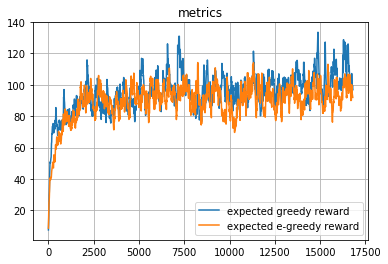

Random session examples


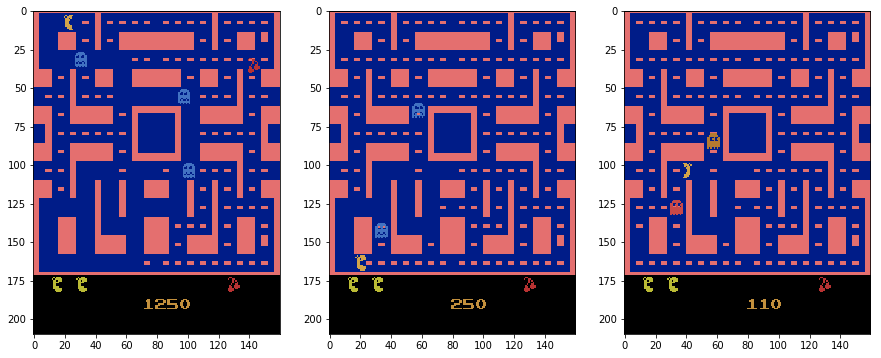

epoch 16810,loss 3293.47159, epsilon 0.05000, rewards: ( e-greedy 95.64919, greedy 96.45862) 
rec 3293.324 reg 0.147
epoch 16820,loss 952.28969, epsilon 0.05000, rewards: ( e-greedy 93.14677, greedy 105.31276) 
rec 952.143 reg 0.147
epoch 16830,loss 569.49178, epsilon 0.05000, rewards: ( e-greedy 91.58209, greedy 102.71899) 
rec 569.344 reg 0.147
epoch 16840,loss 10255.32914, epsilon 0.05000, rewards: ( e-greedy 99.23638, greedy 99.75959) 
rec 10255.182 reg 0.148
epoch 16850,loss 927.06524, epsilon 0.05000, rewards: ( e-greedy 99.93775, greedy 97.90863) 
rec 926.918 reg 0.148
epoch 16860,loss 4958.31010, epsilon 0.05000, rewards: ( e-greedy 109.31897, greedy 99.05527) 
rec 4958.163 reg 0.148
epoch 16870,loss 3097.55544, epsilon 0.05000, rewards: ( e-greedy 110.26207, greedy 97.89974) 
rec 3097.408 reg 0.147
epoch 16880,loss 963.09589, epsilon 0.05000, rewards: ( e-greedy 108.79837, greedy 100.17227) 
rec 962.948 reg 0.148
epoch 16890,loss 414.80083, epsilon 0.05000, rewards: ( e-greedy

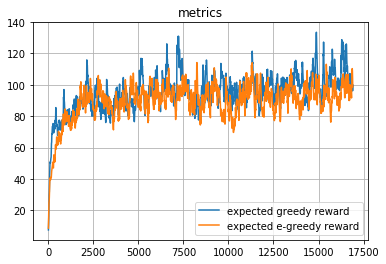

Random session examples


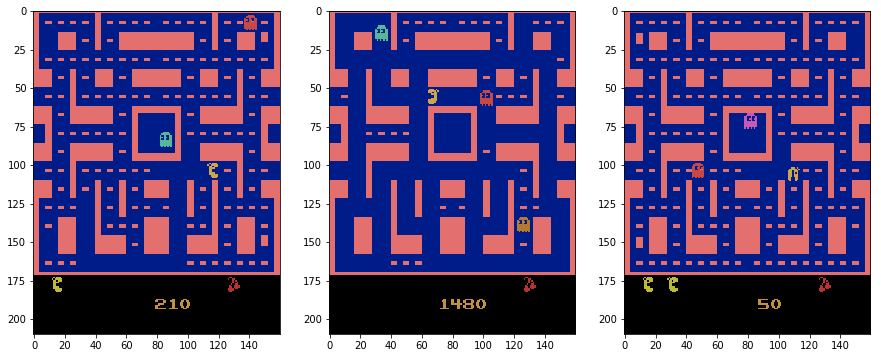

epoch 16910,loss 582.33005, epsilon 0.05000, rewards: ( e-greedy 96.58713, greedy 106.26621) 
rec 582.182 reg 0.148
epoch 16920,loss 1386.21652, epsilon 0.05000, rewards: ( e-greedy 99.55342, greedy 100.70209) 
rec 1386.069 reg 0.148
epoch 16930,loss 1904.58943, epsilon 0.05000, rewards: ( e-greedy 98.16058, greedy 115.31938) 
rec 1904.442 reg 0.148
epoch 16940,loss 542.79599, epsilon 0.05000, rewards: ( e-greedy 95.90702, greedy 112.34994) 
rec 542.648 reg 0.148
epoch 16950,loss 1802.22320, epsilon 0.05000, rewards: ( e-greedy 98.87882, greedy 115.73995) 
rec 1802.075 reg 0.148
epoch 16960,loss 1424.89479, epsilon 0.05000, rewards: ( e-greedy 95.86594, greedy 109.79095) 
rec 1424.747 reg 0.148
epoch 16970,loss 571.10422, epsilon 0.05000, rewards: ( e-greedy 94.02934, greedy 106.62436) 
rec 570.956 reg 0.148
epoch 16980,loss 2165.17498, epsilon 0.05000, rewards: ( e-greedy 98.31391, greedy 104.14942) 
rec 2165.027 reg 0.148
epoch 16990,loss 1188.11087, epsilon 0.05000, rewards: ( e-gre

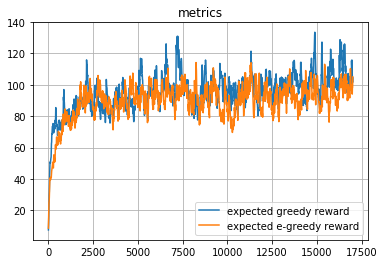

Random session examples


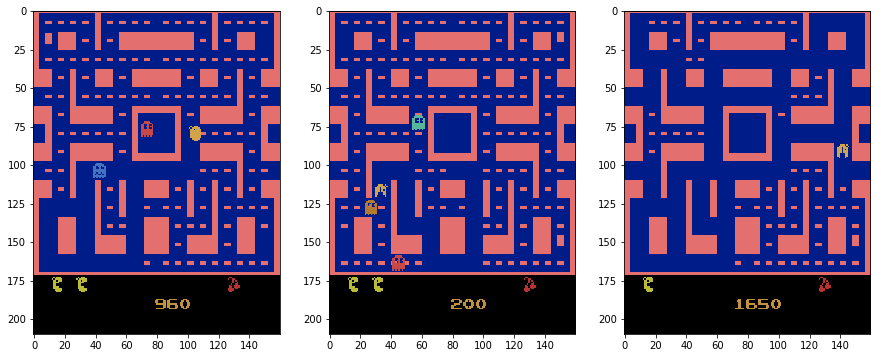

[2017-05-24 23:17:40,071] Making new env: MsPacman-v0
[2017-05-24 23:17:40,243] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 23:17:40,252] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.24.19270.video000000.mp4
[2017-05-24 23:17:41,583] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.24.19270.video000001.mp4


Episode finished after 472 timesteps with reward=240.0
Episode finished after 628 timesteps with reward=230.0
Episode finished after 667 timesteps with reward=300.0
Episode finished after 706 timesteps with reward=240.0
Episode finished after 775 timesteps with reward=300.0
Episode finished after 675 timesteps with reward=240.0
Episode finished after 607 timesteps with reward=240.0


[2017-05-24 23:17:50,576] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.24.19270.video000008.mp4


Episode finished after 674 timesteps with reward=230.0
Episode finished after 1072 timesteps with reward=240.0
Episode finished after 601 timesteps with reward=240.0
Episode finished after 786 timesteps with reward=240.0
Episode finished after 662 timesteps with reward=300.0
Episode finished after 770 timesteps with reward=190.0
Episode finished after 803 timesteps with reward=490.0
Episode finished after 697 timesteps with reward=210.0
Episode finished after 622 timesteps with reward=280.0
Episode finished after 647 timesteps with reward=200.0
Episode finished after 689 timesteps with reward=300.0
Episode finished after 540 timesteps with reward=240.0


[2017-05-24 23:18:06,436] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 597 timesteps with reward=190.0
Mean 257.0, Var 4021.0
epoch 17010,loss 2466.74707, epsilon 0.05000, rewards: ( e-greedy 104.77584, greedy 109.53305) 
rec 2466.599 reg 0.148
epoch 17020,loss 2033.95886, epsilon 0.05000, rewards: ( e-greedy 107.17326, greedy 114.26725) 
rec 2033.811 reg 0.148
epoch 17030,loss 22238.90580, epsilon 0.05000, rewards: ( e-greedy 124.26843, greedy 115.09052) 
rec 22238.758 reg 0.148
epoch 17040,loss 986.28277, epsilon 0.05000, rewards: ( e-greedy 122.84159, greedy 109.39397) 
rec 986.135 reg 0.148
epoch 17050,loss 1899.03230, epsilon 0.05000, rewards: ( e-greedy 126.30743, greedy 107.32957) 
rec 1898.884 reg 0.148
epoch 17060,loss 2671.05436, epsilon 0.05000, rewards: ( e-greedy 131.80169, greedy 104.09662) 
rec 2670.906 reg 0.148
epoch 17070,loss 455.95875, epsilon 0.05000, rewards: ( e-greedy 123.18402, greedy 103.49945) 
rec 455.811 reg 0.148
epoch 17080,loss 2686.71965, epsilon 0.05000, rewards: ( e-greedy 125.61562, greedy 99.0245

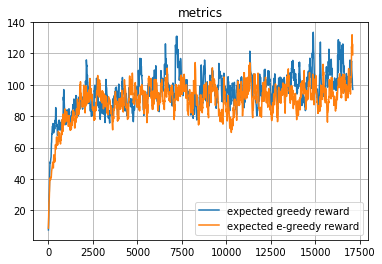

Random session examples


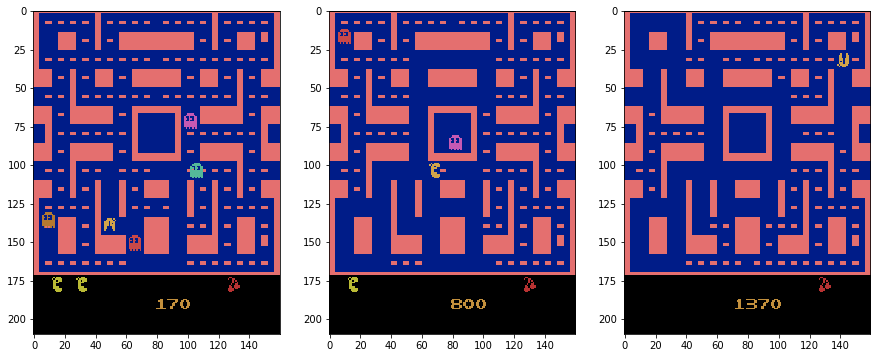

epoch 17110,loss 1573.51731, epsilon 0.05000, rewards: ( e-greedy 118.88253, greedy 112.95074) 
rec 1573.369 reg 0.148
epoch 17120,loss 5491.45353, epsilon 0.05000, rewards: ( e-greedy 118.99428, greedy 109.09317) 
rec 5491.305 reg 0.148
epoch 17130,loss 498.73058, epsilon 0.05000, rewards: ( e-greedy 113.09485, greedy 106.55885) 
rec 498.582 reg 0.148
epoch 17140,loss 339.12422, epsilon 0.05000, rewards: ( e-greedy 104.97287, greedy 101.21547) 
rec 338.976 reg 0.149
epoch 17150,loss 4792.84818, epsilon 0.05000, rewards: ( e-greedy 109.97558, greedy 98.46892) 
rec 4792.700 reg 0.148
epoch 17160,loss 821.11984, epsilon 0.05000, rewards: ( e-greedy 108.97802, greedy 99.74703) 
rec 820.971 reg 0.148
epoch 17170,loss 2237.73332, epsilon 0.05000, rewards: ( e-greedy 105.33022, greedy 94.52232) 
rec 2237.585 reg 0.149
epoch 17180,loss 765.70890, epsilon 0.05000, rewards: ( e-greedy 102.67220, greedy 94.50759) 
rec 765.560 reg 0.149
epoch 17190,loss 838.22052, epsilon 0.05000, rewards: ( e-gr

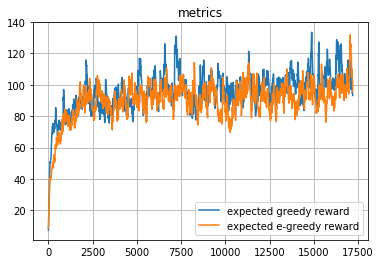

Random session examples


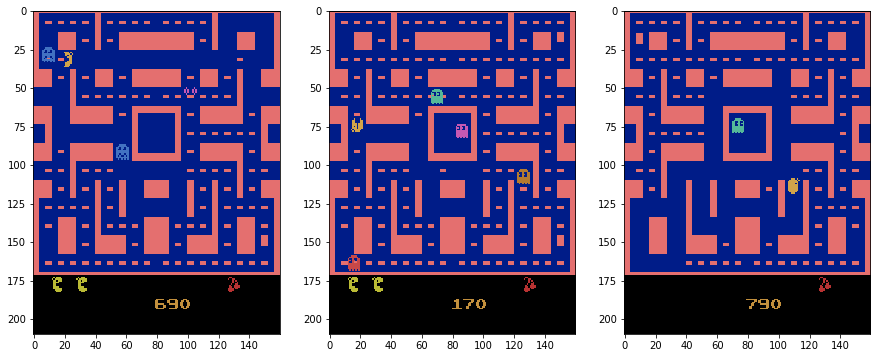

epoch 17210,loss 1474.39722, epsilon 0.05000, rewards: ( e-greedy 96.50616, greedy 91.98353) 
rec 1474.249 reg 0.149
epoch 17220,loss 1534.90537, epsilon 0.05000, rewards: ( e-greedy 95.35554, greedy 86.59768) 
rec 1534.757 reg 0.149
epoch 17230,loss 735.94468, epsilon 0.05000, rewards: ( e-greedy 96.94499, greedy 91.18791) 
rec 735.796 reg 0.149
epoch 17240,loss 696.18293, epsilon 0.05000, rewards: ( e-greedy 95.87549, greedy 95.50662) 
rec 696.034 reg 0.149
epoch 17250,loss 1437.11352, epsilon 0.05000, rewards: ( e-greedy 92.85044, greedy 90.39346) 
rec 1436.965 reg 0.149
epoch 17260,loss 409.76827, epsilon 0.05000, rewards: ( e-greedy 87.87790, greedy 88.72911) 
rec 409.619 reg 0.149
epoch 17270,loss 2021.88104, epsilon 0.05000, rewards: ( e-greedy 88.90261, greedy 92.60620) 
rec 2021.732 reg 0.149
epoch 17280,loss 1383.67172, epsilon 0.05000, rewards: ( e-greedy 85.63735, greedy 88.84558) 
rec 1383.523 reg 0.149
epoch 17290,loss 1372.95122, epsilon 0.05000, rewards: ( e-greedy 88.3

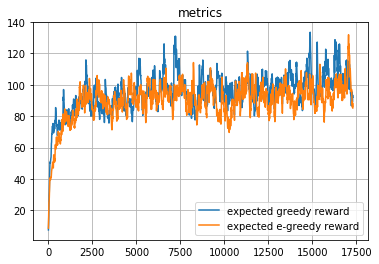

Random session examples


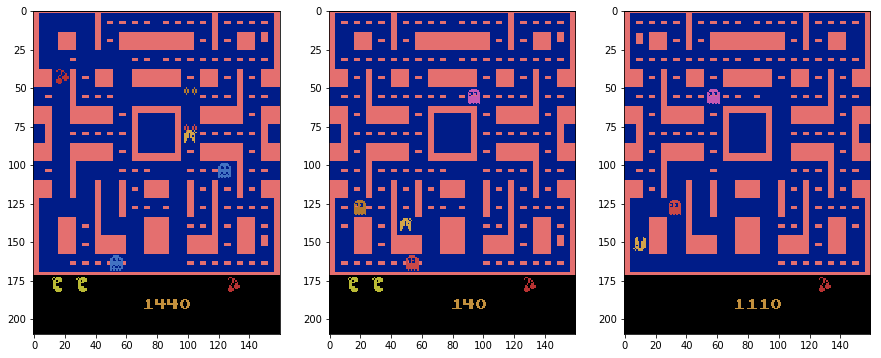

epoch 17310,loss 2159.64190, epsilon 0.05000, rewards: ( e-greedy 90.97337, greedy 92.66593) 
rec 2159.493 reg 0.149
epoch 17320,loss 5334.04260, epsilon 0.05000, rewards: ( e-greedy 94.56354, greedy 89.83684) 
rec 5333.894 reg 0.149
epoch 17330,loss 977.24269, epsilon 0.05000, rewards: ( e-greedy 92.48218, greedy 91.04065) 
rec 977.094 reg 0.149
epoch 17340,loss 390.47491, epsilon 0.05000, rewards: ( e-greedy 87.48397, greedy 92.24909) 
rec 390.326 reg 0.149
epoch 17350,loss 987.38284, epsilon 0.05000, rewards: ( e-greedy 88.11057, greedy 89.52418) 
rec 987.234 reg 0.149
epoch 17360,loss 1937.73037, epsilon 0.05000, rewards: ( e-greedy 87.23701, greedy 83.82176) 
rec 1937.581 reg 0.149
epoch 17370,loss 862.42003, epsilon 0.05000, rewards: ( e-greedy 86.20081, greedy 84.68958) 
rec 862.271 reg 0.149
epoch 17380,loss 1252.94746, epsilon 0.05000, rewards: ( e-greedy 89.89323, greedy 83.78313) 
rec 1252.798 reg 0.149
epoch 17390,loss 1869.16455, epsilon 0.05000, rewards: ( e-greedy 88.966

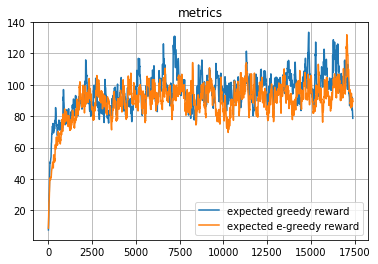

Random session examples


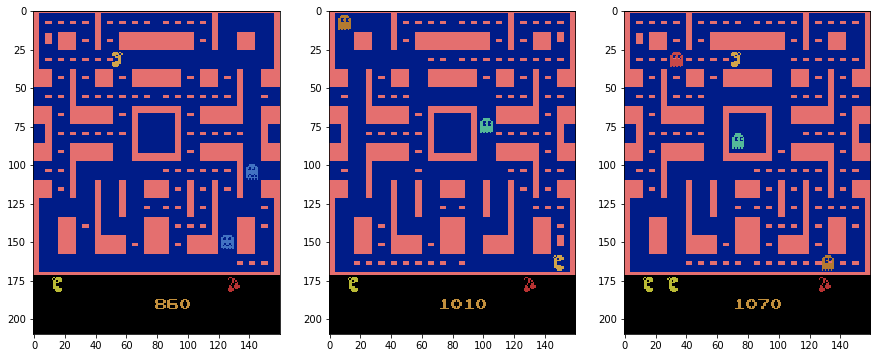

epoch 17410,loss 2178.68738, epsilon 0.05000, rewards: ( e-greedy 95.40654, greedy 80.73040) 
rec 2178.538 reg 0.149
epoch 17420,loss 364.33274, epsilon 0.05000, rewards: ( e-greedy 92.92839, greedy 86.03236) 
rec 364.183 reg 0.149
epoch 17430,loss 289.35393, epsilon 0.05000, rewards: ( e-greedy 89.01055, greedy 85.86662) 
rec 289.204 reg 0.149
epoch 17440,loss 758.36940, epsilon 0.05000, rewards: ( e-greedy 89.60949, greedy 94.59246) 
rec 758.220 reg 0.149
epoch 17450,loss 3271.98183, epsilon 0.05000, rewards: ( e-greedy 95.64854, greedy 94.82071) 
rec 3271.832 reg 0.150
epoch 17460,loss 1903.00722, epsilon 0.05000, rewards: ( e-greedy 100.20869, greedy 96.71364) 
rec 1902.858 reg 0.150
epoch 17470,loss 1070.32876, epsilon 0.05000, rewards: ( e-greedy 96.50032, greedy 98.22978) 
rec 1070.179 reg 0.150
epoch 17480,loss 2870.11741, epsilon 0.05000, rewards: ( e-greedy 101.22529, greedy 99.03180) 
rec 2869.968 reg 0.150
epoch 17490,loss 4371.81430, epsilon 0.05000, rewards: ( e-greedy 10

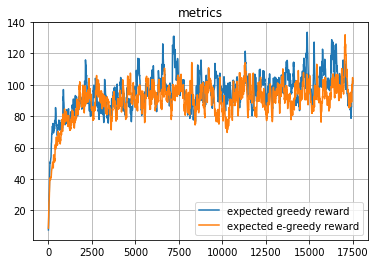

Random session examples


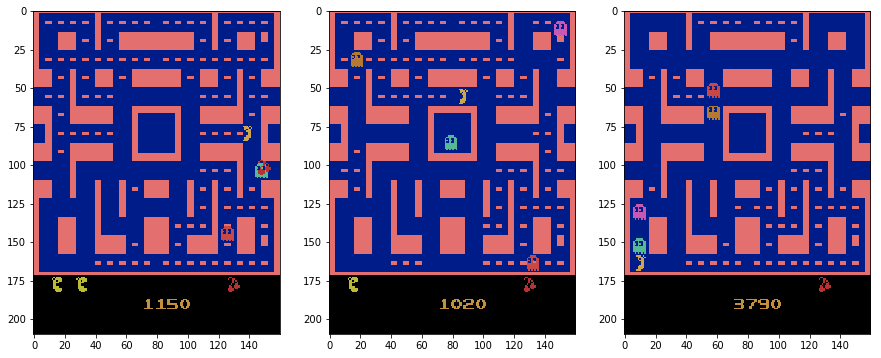

epoch 17510,loss 2956.79559, epsilon 0.05000, rewards: ( e-greedy 105.99636, greedy 105.51418) 
rec 2956.646 reg 0.150
epoch 17520,loss 429.75596, epsilon 0.05000, rewards: ( e-greedy 101.52172, greedy 101.83776) 
rec 429.606 reg 0.150
epoch 17530,loss 893.41970, epsilon 0.05000, rewards: ( e-greedy 101.86955, greedy 101.40399) 
rec 893.270 reg 0.150
epoch 17540,loss 1280.87276, epsilon 0.05000, rewards: ( e-greedy 105.05760, greedy 110.20109) 
rec 1280.723 reg 0.150
epoch 17550,loss 443.77093, epsilon 0.05000, rewards: ( e-greedy 100.42684, greedy 106.05598) 
rec 443.621 reg 0.150
epoch 17560,loss 1615.83410, epsilon 0.05000, rewards: ( e-greedy 100.32165, greedy 111.82538) 
rec 1615.684 reg 0.150
epoch 17570,loss 375.16578, epsilon 0.05000, rewards: ( e-greedy 96.16449, greedy 108.64284) 
rec 375.016 reg 0.150
epoch 17580,loss 637.37239, epsilon 0.05000, rewards: ( e-greedy 92.36054, greedy 106.71606) 
rec 637.222 reg 0.150
epoch 17590,loss 581.68663, epsilon 0.05000, rewards: ( e-gr

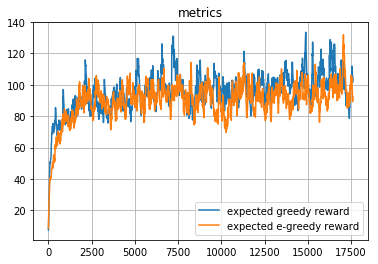

Random session examples


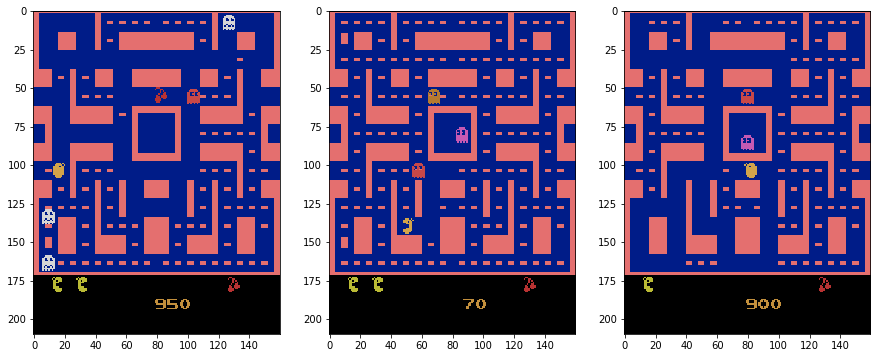

epoch 17610,loss 12255.29592, epsilon 0.05000, rewards: ( e-greedy 104.87958, greedy 105.73226) 
rec 12255.146 reg 0.150
epoch 17620,loss 1110.26145, epsilon 0.05000, rewards: ( e-greedy 103.20412, greedy 101.97153) 
rec 1110.111 reg 0.150
epoch 17630,loss 338.06036, epsilon 0.05000, rewards: ( e-greedy 98.19621, greedy 101.21188) 
rec 337.910 reg 0.151
epoch 17640,loss 453.15009, epsilon 0.05000, rewards: ( e-greedy 94.12659, greedy 99.90319) 
rec 453.000 reg 0.150
epoch 17650,loss 403.58538, epsilon 0.05000, rewards: ( e-greedy 91.27643, greedy 101.60037) 
rec 403.435 reg 0.151
epoch 17660,loss 737.76909, epsilon 0.05000, rewards: ( e-greedy 90.33629, greedy 103.87783) 
rec 737.619 reg 0.150
epoch 17670,loss 2478.37857, epsilon 0.05000, rewards: ( e-greedy 95.30266, greedy 102.74005) 
rec 2478.228 reg 0.151
epoch 17680,loss 1048.80224, epsilon 0.05000, rewards: ( e-greedy 96.27239, greedy 98.40355) 
rec 1048.652 reg 0.151
epoch 17690,loss 403.94948, epsilon 0.05000, rewards: ( e-gree

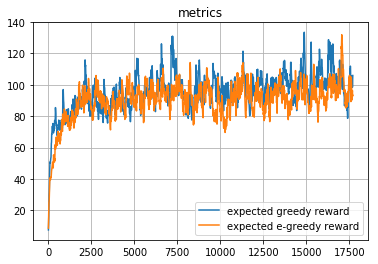

Random session examples


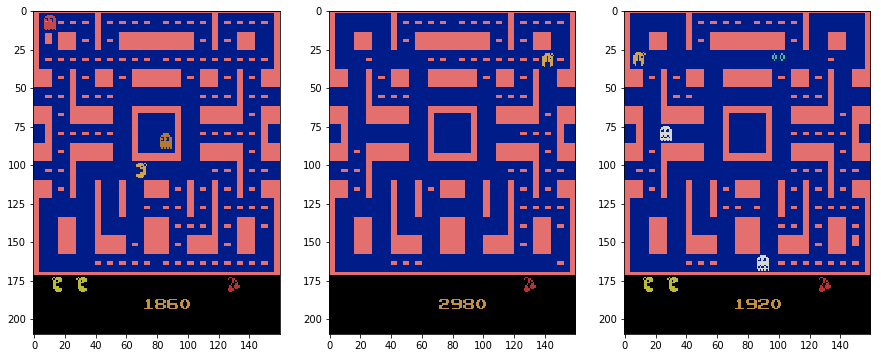

epoch 17710,loss 2618.42200, epsilon 0.05000, rewards: ( e-greedy 95.61195, greedy 114.52119) 
rec 2618.271 reg 0.151
epoch 17720,loss 418.08060, epsilon 0.05000, rewards: ( e-greedy 93.48826, greedy 114.25657) 
rec 417.930 reg 0.151
epoch 17730,loss 346.49393, epsilon 0.05000, rewards: ( e-greedy 89.32693, greedy 109.89341) 
rec 346.343 reg 0.151
epoch 17740,loss 792.89729, epsilon 0.05000, rewards: ( e-greedy 90.14424, greedy 105.52907) 
rec 792.747 reg 0.151
epoch 17750,loss 1904.18154, epsilon 0.05000, rewards: ( e-greedy 94.50481, greedy 101.22616) 
rec 1904.031 reg 0.151
epoch 17760,loss 350.43365, epsilon 0.05000, rewards: ( e-greedy 89.42933, greedy 99.47855) 
rec 350.283 reg 0.151
epoch 17770,loss 2669.69605, epsilon 0.05000, rewards: ( e-greedy 95.79890, greedy 100.03069) 
rec 2669.545 reg 0.151
epoch 17780,loss 759.71542, epsilon 0.05000, rewards: ( e-greedy 94.96901, greedy 100.84012) 
rec 759.565 reg 0.151
epoch 17790,loss 1854.32353, epsilon 0.05000, rewards: ( e-greedy 9

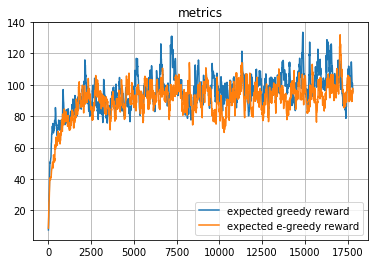

Random session examples


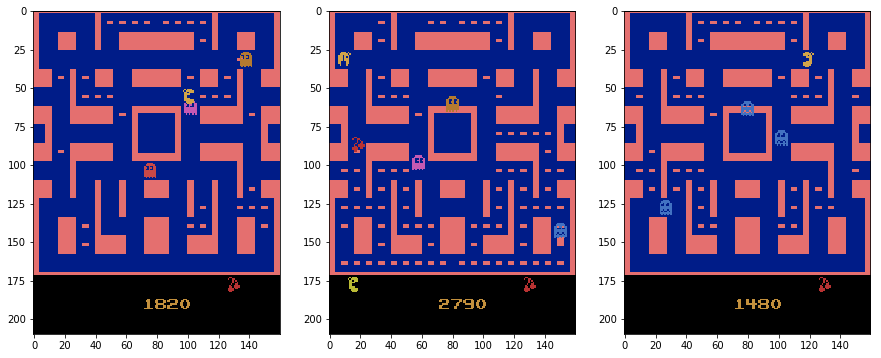

epoch 17810,loss 722.92621, epsilon 0.05000, rewards: ( e-greedy 93.87991, greedy 91.36245) 
rec 722.775 reg 0.151
epoch 17820,loss 439.19925, epsilon 0.05000, rewards: ( e-greedy 92.74192, greedy 91.47620) 
rec 439.048 reg 0.151
epoch 17830,loss 385.57836, epsilon 0.05000, rewards: ( e-greedy 90.03022, greedy 93.76608) 
rec 385.427 reg 0.151
epoch 17840,loss 836.44975, epsilon 0.05000, rewards: ( e-greedy 87.52720, greedy 96.13948) 
rec 836.299 reg 0.151
epoch 17850,loss 5406.38546, epsilon 0.05000, rewards: ( e-greedy 92.52448, greedy 94.08803) 
rec 5406.234 reg 0.151
epoch 17860,loss 638.28057, epsilon 0.05000, rewards: ( e-greedy 89.14703, greedy 102.17923) 
rec 638.129 reg 0.151
epoch 17870,loss 519.04363, epsilon 0.05000, rewards: ( e-greedy 87.98233, greedy 112.58630) 
rec 518.893 reg 0.151
epoch 17880,loss 859.29254, epsilon 0.05000, rewards: ( e-greedy 85.87160, greedy 114.07767) 
rec 859.141 reg 0.151
epoch 17890,loss 3499.89580, epsilon 0.05000, rewards: ( e-greedy 94.59694,

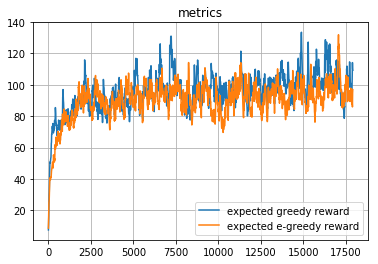

Random session examples


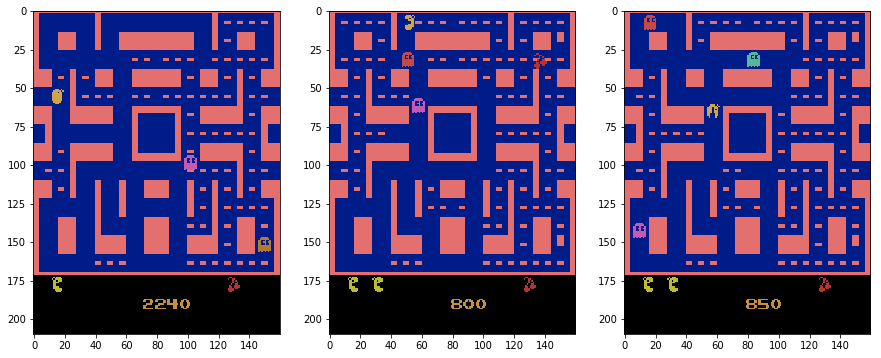

epoch 17910,loss 1604.57374, epsilon 0.05000, rewards: ( e-greedy 97.76727, greedy 105.45887) 
rec 1604.422 reg 0.151
epoch 17920,loss 1562.28523, epsilon 0.05000, rewards: ( e-greedy 99.55304, greedy 101.60049) 
rec 1562.134 reg 0.151
epoch 17930,loss 907.22810, epsilon 0.05000, rewards: ( e-greedy 100.28524, greedy 102.87794) 
rec 907.077 reg 0.151
epoch 17940,loss 501.14572, epsilon 0.05000, rewards: ( e-greedy 96.31921, greedy 101.46514) 
rec 500.994 reg 0.151
epoch 17950,loss 1961.01435, epsilon 0.05000, rewards: ( e-greedy 102.87479, greedy 106.88113) 
rec 1960.863 reg 0.151
epoch 17960,loss 2000.32711, epsilon 0.05000, rewards: ( e-greedy 106.39981, greedy 126.31802) 
rec 2000.176 reg 0.151
epoch 17970,loss 2284.09042, epsilon 0.05000, rewards: ( e-greedy 107.19733, greedy 121.87371) 
rec 2283.939 reg 0.151
epoch 17980,loss 767.30319, epsilon 0.05000, rewards: ( e-greedy 105.04010, greedy 119.74884) 
rec 767.152 reg 0.152
epoch 17990,loss 7258.70284, epsilon 0.05000, rewards: ( 

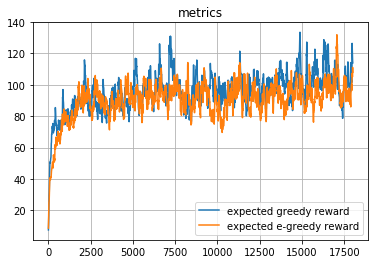

Random session examples


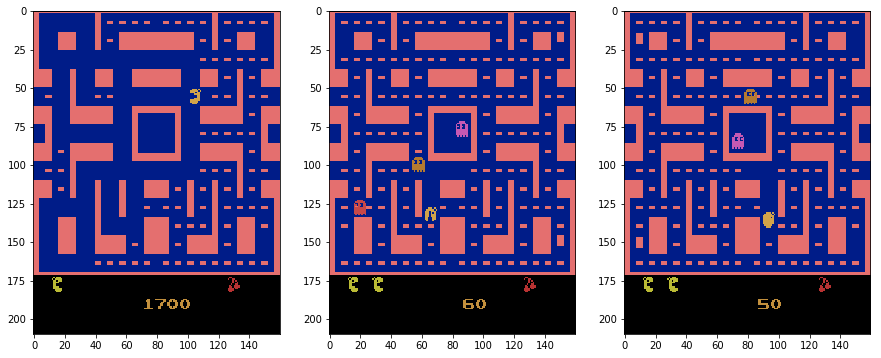

[2017-05-24 23:43:36,933] Making new env: MsPacman-v0
[2017-05-24 23:43:37,096] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 23:43:37,105] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.25.19270.video000000.mp4
[2017-05-24 23:43:38,460] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.25.19270.video000001.mp4


Episode finished after 503 timesteps with reward=120.0
Episode finished after 379 timesteps with reward=60.0
Episode finished after 828 timesteps with reward=200.0
Episode finished after 574 timesteps with reward=280.0
Episode finished after 594 timesteps with reward=170.0
Episode finished after 717 timesteps with reward=290.0
Episode finished after 461 timesteps with reward=170.0


[2017-05-24 23:43:46,029] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.25.19270.video000008.mp4


Episode finished after 536 timesteps with reward=170.0
Episode finished after 595 timesteps with reward=270.0
Episode finished after 906 timesteps with reward=280.0
Episode finished after 606 timesteps with reward=170.0
Episode finished after 834 timesteps with reward=310.0
Episode finished after 886 timesteps with reward=1030.0
Episode finished after 557 timesteps with reward=160.0
Episode finished after 608 timesteps with reward=280.0
Episode finished after 481 timesteps with reward=80.0
Episode finished after 590 timesteps with reward=330.0
Episode finished after 611 timesteps with reward=120.0
Episode finished after 701 timesteps with reward=260.0


[2017-05-24 23:44:00,400] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 583 timesteps with reward=350.0
Mean 255.0, Var 38385.0
epoch 18010,loss 23257.89982, epsilon 0.05000, rewards: ( e-greedy 122.15173, greedy 112.56941) 
rec 23257.748 reg 0.152
epoch 18020,loss 503.70431, epsilon 0.05000, rewards: ( e-greedy 115.12406, greedy 109.81247) 
rec 503.552 reg 0.152
epoch 18030,loss 387.14585, epsilon 0.05000, rewards: ( e-greedy 107.29915, greedy 106.58122) 
rec 386.994 reg 0.152
epoch 18040,loss 941.06298, epsilon 0.05000, rewards: ( e-greedy 106.50674, greedy 109.79810) 
rec 940.911 reg 0.152
epoch 18050,loss 402.36803, epsilon 0.05000, rewards: ( e-greedy 102.04356, greedy 107.25579) 
rec 402.216 reg 0.152
epoch 18060,loss 1627.11310, epsilon 0.05000, rewards: ( e-greedy 101.40171, greedy 106.34271) 
rec 1626.961 reg 0.152
epoch 18070,loss 2156.07232, epsilon 0.05000, rewards: ( e-greedy 103.13654, greedy 101.45844) 
rec 2155.920 reg 0.152
epoch 18080,loss 252.06192, epsilon 0.05000, rewards: ( e-greedy 96.44788, greedy 102.68759) 


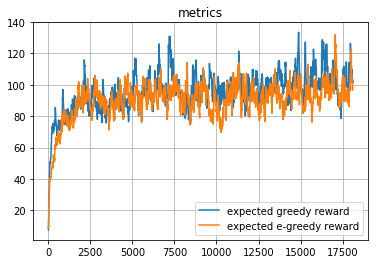

Random session examples


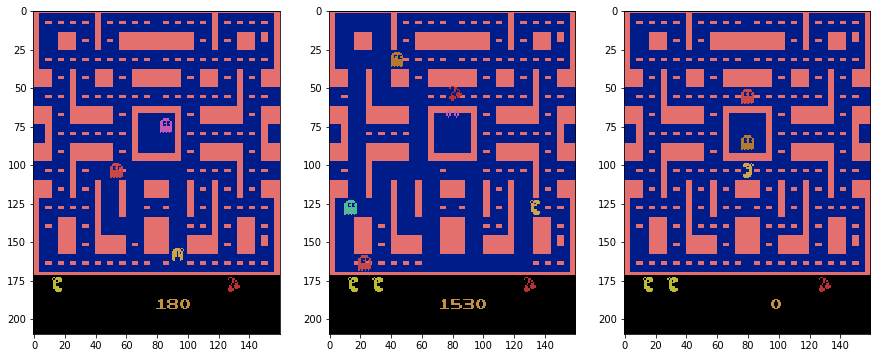

epoch 18110,loss 859.59422, epsilon 0.05000, rewards: ( e-greedy 100.44926, greedy 101.96301) 
rec 859.442 reg 0.152
epoch 18120,loss 324.55157, epsilon 0.05000, rewards: ( e-greedy 94.15433, greedy 98.39171) 
rec 324.399 reg 0.152
epoch 18130,loss 1805.35079, epsilon 0.05000, rewards: ( e-greedy 95.67640, greedy 97.86504) 
rec 1805.199 reg 0.152
epoch 18140,loss 1678.34818, epsilon 0.05000, rewards: ( e-greedy 95.54626, greedy 97.45353) 
rec 1678.196 reg 0.152
epoch 18150,loss 630.51111, epsilon 0.05000, rewards: ( e-greedy 93.67913, greedy 94.39568) 
rec 630.359 reg 0.152
epoch 18160,loss 3106.59312, epsilon 0.05000, rewards: ( e-greedy 107.93622, greedy 91.51861) 
rec 3106.441 reg 0.152
epoch 18170,loss 2040.99998, epsilon 0.05000, rewards: ( e-greedy 108.14260, greedy 88.61675) 
rec 2040.848 reg 0.152
epoch 18180,loss 983.51022, epsilon 0.05000, rewards: ( e-greedy 106.45334, greedy 87.50507) 
rec 983.358 reg 0.152
epoch 18190,loss 427.49251, epsilon 0.05000, rewards: ( e-greedy 10

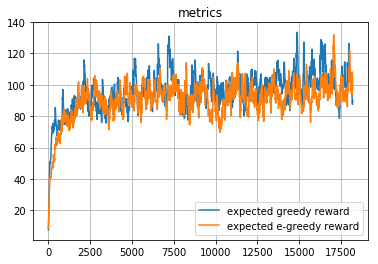

Random session examples


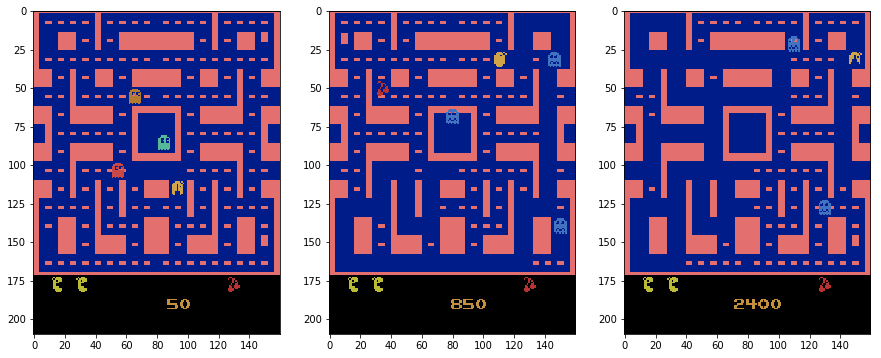

epoch 18210,loss 1537.24949, epsilon 0.05000, rewards: ( e-greedy 99.81823, greedy 96.03370) 
rec 1537.097 reg 0.153
epoch 18220,loss 1624.42931, epsilon 0.05000, rewards: ( e-greedy 100.89891, greedy 97.49283) 
rec 1624.277 reg 0.153
epoch 18230,loss 554.42459, epsilon 0.05000, rewards: ( e-greedy 98.68402, greedy 96.99355) 
rec 554.272 reg 0.153
epoch 18240,loss 6282.15703, epsilon 0.05000, rewards: ( e-greedy 100.37812, greedy 91.54419) 
rec 6282.004 reg 0.153
epoch 18250,loss 1673.94194, epsilon 0.05000, rewards: ( e-greedy 100.46531, greedy 93.07727) 
rec 1673.789 reg 0.153
epoch 18260,loss 1533.46001, epsilon 0.05000, rewards: ( e-greedy 99.54377, greedy 95.20705) 
rec 1533.307 reg 0.153
epoch 18270,loss 1398.66714, epsilon 0.05000, rewards: ( e-greedy 98.02690, greedy 92.81134) 
rec 1398.514 reg 0.153
epoch 18280,loss 479.19372, epsilon 0.05000, rewards: ( e-greedy 94.03671, greedy 91.34271) 
rec 479.041 reg 0.153
epoch 18290,loss 324.56307, epsilon 0.05000, rewards: ( e-greedy 

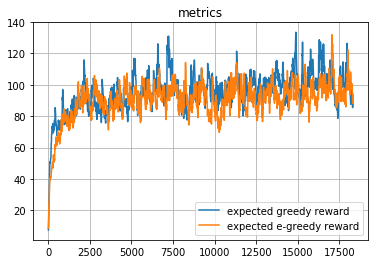

Random session examples


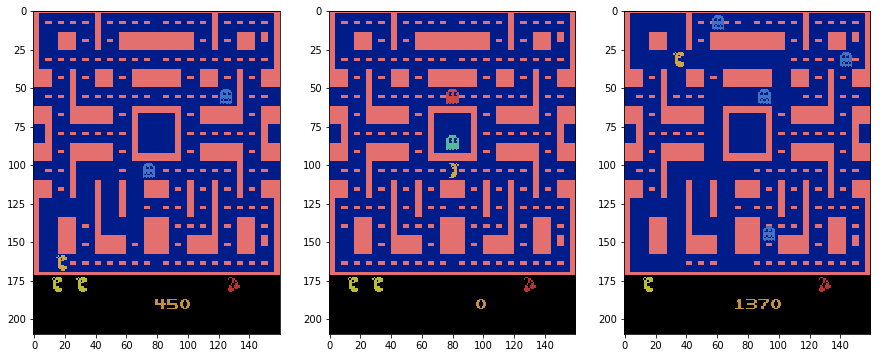

epoch 18310,loss 1683.52608, epsilon 0.05000, rewards: ( e-greedy 92.09338, greedy 93.84008) 
rec 1683.373 reg 0.153
epoch 18320,loss 766.11694, epsilon 0.05000, rewards: ( e-greedy 90.88405, greedy 92.45607) 
rec 765.964 reg 0.153
epoch 18330,loss 1463.48139, epsilon 0.05000, rewards: ( e-greedy 95.60814, greedy 102.96047) 
rec 1463.328 reg 0.153
epoch 18340,loss 1519.73585, epsilon 0.05000, rewards: ( e-greedy 101.17233, greedy 102.72692) 
rec 1519.583 reg 0.153
epoch 18350,loss 302.11864, epsilon 0.05000, rewards: ( e-greedy 94.68009, greedy 98.14173) 
rec 301.965 reg 0.153
epoch 18360,loss 2308.79075, epsilon 0.05000, rewards: ( e-greedy 99.14959, greedy 102.01506) 
rec 2308.637 reg 0.153
epoch 18370,loss 848.91958, epsilon 0.05000, rewards: ( e-greedy 99.60963, greedy 105.87605) 
rec 848.766 reg 0.153
epoch 18380,loss 1414.28176, epsilon 0.05000, rewards: ( e-greedy 102.96116, greedy 109.47595) 
rec 1414.128 reg 0.153
epoch 18390,loss 461.24263, epsilon 0.05000, rewards: ( e-greed

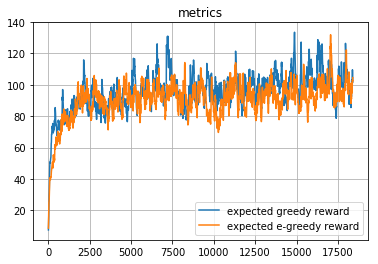

Random session examples


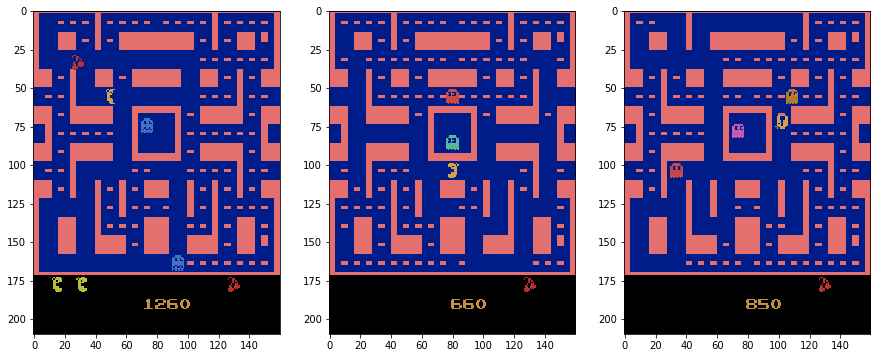

epoch 18410,loss 2354.86038, epsilon 0.05000, rewards: ( e-greedy 104.24744, greedy 100.86046) 
rec 2354.707 reg 0.153
epoch 18420,loss 401.29892, epsilon 0.05000, rewards: ( e-greedy 101.13519, greedy 105.52442) 
rec 401.146 reg 0.153
epoch 18430,loss 1566.82420, epsilon 0.05000, rewards: ( e-greedy 105.39668, greedy 112.15948) 
rec 1566.671 reg 0.154
epoch 18440,loss 731.29943, epsilon 0.05000, rewards: ( e-greedy 103.35701, greedy 116.63103) 
rec 731.146 reg 0.154
epoch 18450,loss 951.40991, epsilon 0.05000, rewards: ( e-greedy 101.58381, greedy 112.03043) 
rec 951.256 reg 0.154
epoch 18460,loss 1756.58346, epsilon 0.05000, rewards: ( e-greedy 100.73793, greedy 108.38988) 
rec 1756.430 reg 0.154
epoch 18470,loss 2564.58729, epsilon 0.05000, rewards: ( e-greedy 106.91413, greedy 104.30089) 
rec 2564.434 reg 0.154
epoch 18480,loss 603.59437, epsilon 0.05000, rewards: ( e-greedy 102.53522, greedy 113.24581) 
rec 603.441 reg 0.154
epoch 18490,loss 685.99027, epsilon 0.05000, rewards: ( 

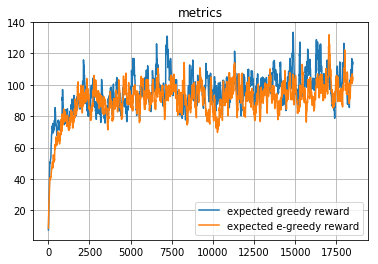

Random session examples


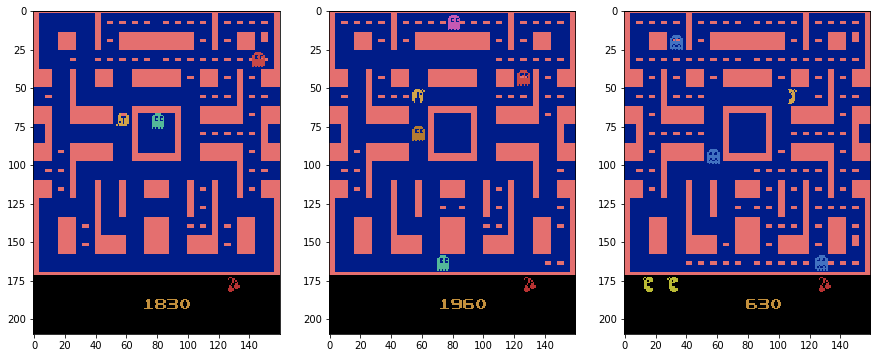

epoch 18510,loss 1629.62052, epsilon 0.05000, rewards: ( e-greedy 109.94318, greedy 115.49682) 
rec 1629.467 reg 0.154
epoch 18520,loss 4650.96881, epsilon 0.05000, rewards: ( e-greedy 114.26136, greedy 116.88464) 
rec 4650.815 reg 0.154
epoch 18530,loss 553.61135, epsilon 0.05000, rewards: ( e-greedy 109.33522, greedy 112.57117) 
rec 553.457 reg 0.154
epoch 18540,loss 542.53385, epsilon 0.05000, rewards: ( e-greedy 107.71420, greedy 110.93905) 
rec 542.380 reg 0.154
epoch 18550,loss 1247.83822, epsilon 0.05000, rewards: ( e-greedy 107.44278, greedy 107.15765) 
rec 1247.684 reg 0.154
epoch 18560,loss 1472.24758, epsilon 0.05000, rewards: ( e-greedy 104.51100, greedy 101.81688) 
rec 1472.094 reg 0.154
epoch 18570,loss 2433.81793, epsilon 0.05000, rewards: ( e-greedy 103.49740, greedy 103.88520) 
rec 2433.664 reg 0.154
epoch 18580,loss 1230.84398, epsilon 0.05000, rewards: ( e-greedy 101.89766, greedy 104.55918) 
rec 1230.690 reg 0.154
epoch 18590,loss 331.97255, epsilon 0.05000, rewards

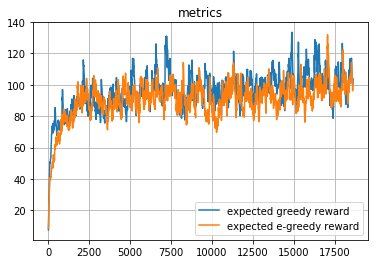

Random session examples


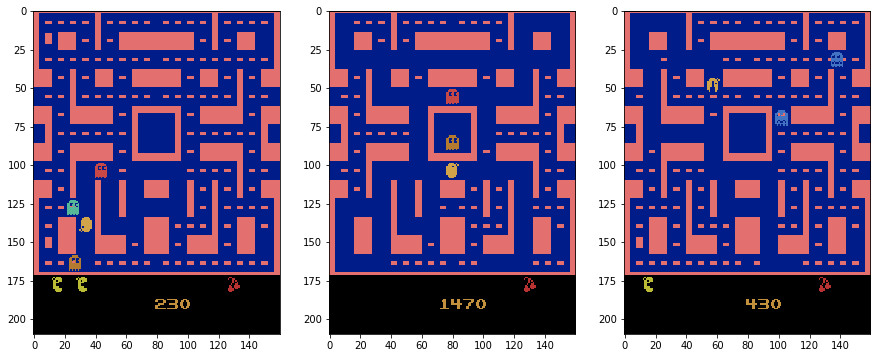

epoch 18610,loss 1439.82773, epsilon 0.05000, rewards: ( e-greedy 100.79652, greedy 104.76989) 
rec 1439.673 reg 0.154
epoch 18620,loss 487.45630, epsilon 0.05000, rewards: ( e-greedy 98.46687, greedy 105.98040) 
rec 487.302 reg 0.154
epoch 18630,loss 1882.36669, epsilon 0.05000, rewards: ( e-greedy 99.93268, greedy 104.75736) 
rec 1882.212 reg 0.154
epoch 18640,loss 1481.11285, epsilon 0.05000, rewards: ( e-greedy 101.56441, greedy 102.65662) 
rec 1480.958 reg 0.154
epoch 18650,loss 316.52901, epsilon 0.05000, rewards: ( e-greedy 95.22047, greedy 100.39096) 
rec 316.375 reg 0.154
epoch 18660,loss 488.65858, epsilon 0.05000, rewards: ( e-greedy 93.94842, greedy 104.78937) 
rec 488.504 reg 0.155
epoch 18670,loss 1104.18425, epsilon 0.05000, rewards: ( e-greedy 95.67858, greedy 104.99793) 
rec 1104.030 reg 0.155
epoch 18680,loss 800.16788, epsilon 0.05000, rewards: ( e-greedy 95.42322, greedy 101.99814) 
rec 800.013 reg 0.155
epoch 18690,loss 7271.43600, epsilon 0.05000, rewards: ( e-gre

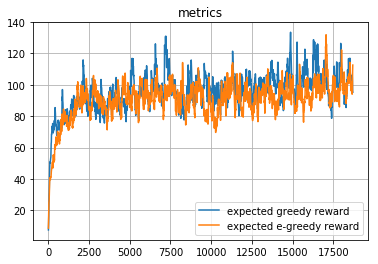

Random session examples


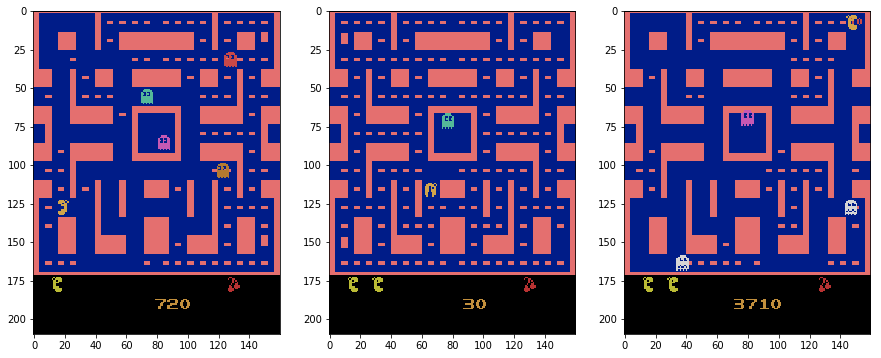

epoch 18710,loss 490.28469, epsilon 0.05000, rewards: ( e-greedy 105.57291, greedy 95.77664) 
rec 490.130 reg 0.155
epoch 18720,loss 815.34335, epsilon 0.05000, rewards: ( e-greedy 100.76561, greedy 96.07398) 
rec 815.188 reg 0.155
epoch 18730,loss 659.20124, epsilon 0.05000, rewards: ( e-greedy 98.12655, greedy 99.40408) 
rec 659.046 reg 0.155
epoch 18740,loss 6811.58413, epsilon 0.05000, rewards: ( e-greedy 105.06390, greedy 101.71367) 
rec 6811.429 reg 0.155
epoch 18750,loss 551.21319, epsilon 0.05000, rewards: ( e-greedy 99.87001, greedy 101.22980) 
rec 551.058 reg 0.155
epoch 18760,loss 808.53638, epsilon 0.05000, rewards: ( e-greedy 96.13301, greedy 97.73182) 
rec 808.381 reg 0.155
epoch 18770,loss 450.76759, epsilon 0.05000, rewards: ( e-greedy 94.14471, greedy 95.70864) 
rec 450.613 reg 0.155
epoch 18780,loss 556.36421, epsilon 0.05000, rewards: ( e-greedy 89.04274, greedy 92.57528) 
rec 556.209 reg 0.155
epoch 18790,loss 743.94441, epsilon 0.05000, rewards: ( e-greedy 91.76346

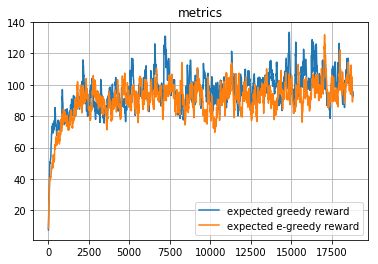

Random session examples


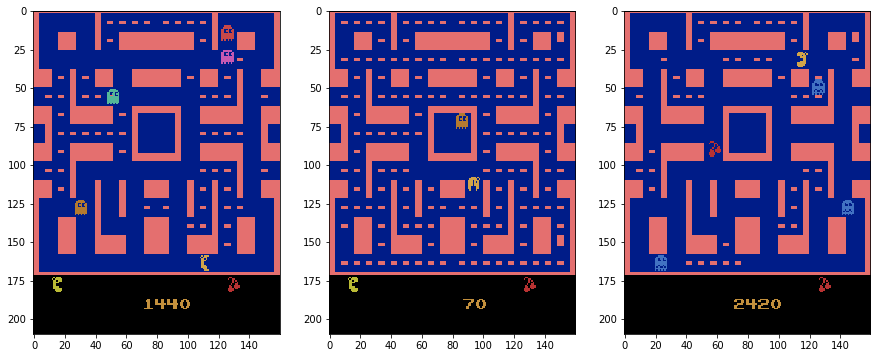

epoch 18810,loss 2846.81670, epsilon 0.05000, rewards: ( e-greedy 100.64090, greedy 90.67488) 
rec 2846.662 reg 0.155
epoch 18820,loss 1236.66540, epsilon 0.05000, rewards: ( e-greedy 97.95181, greedy 88.23239) 
rec 1236.510 reg 0.155
epoch 18830,loss 1038.24675, epsilon 0.05000, rewards: ( e-greedy 97.28163, greedy 86.97165) 
rec 1038.092 reg 0.155
epoch 18840,loss 585.67795, epsilon 0.05000, rewards: ( e-greedy 95.42847, greedy 89.52449) 
rec 585.523 reg 0.155
epoch 18850,loss 1150.40323, epsilon 0.05000, rewards: ( e-greedy 94.69812, greedy 91.32204) 
rec 1150.248 reg 0.155
epoch 18860,loss 1829.43316, epsilon 0.05000, rewards: ( e-greedy 94.60331, greedy 90.87733) 
rec 1829.278 reg 0.155
epoch 18870,loss 993.10896, epsilon 0.05000, rewards: ( e-greedy 91.14298, greedy 89.97710) 
rec 992.954 reg 0.155
epoch 18880,loss 783.29134, epsilon 0.05000, rewards: ( e-greedy 89.77868, greedy 92.47939) 
rec 783.136 reg 0.155
epoch 18890,loss 2661.74361, epsilon 0.05000, rewards: ( e-greedy 92.

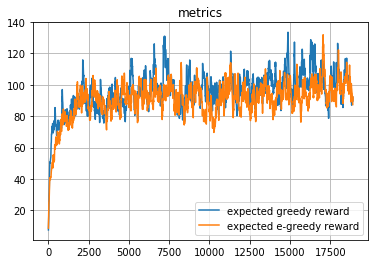

Random session examples


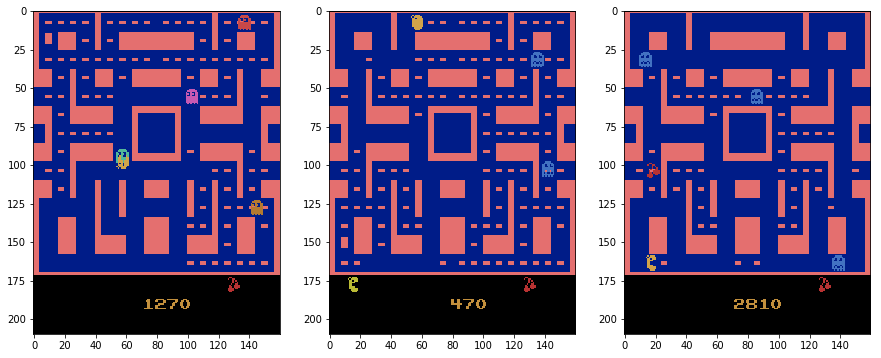

epoch 18910,loss 4012.06398, epsilon 0.05000, rewards: ( e-greedy 96.05991, greedy 91.18310) 
rec 4011.908 reg 0.156
epoch 18920,loss 473.43777, epsilon 0.05000, rewards: ( e-greedy 89.57892, greedy 89.50229) 
rec 473.282 reg 0.156
epoch 18930,loss 3093.87973, epsilon 0.05000, rewards: ( e-greedy 92.62103, greedy 92.05206) 
rec 3093.724 reg 0.156
epoch 18940,loss 369.23047, epsilon 0.05000, rewards: ( e-greedy 89.04642, greedy 89.72186) 
rec 369.075 reg 0.156
epoch 18950,loss 822.57518, epsilon 0.05000, rewards: ( e-greedy 91.32928, greedy 89.62467) 
rec 822.419 reg 0.156
epoch 18960,loss 754.50858, epsilon 0.05000, rewards: ( e-greedy 92.25885, greedy 105.59970) 
rec 754.353 reg 0.156
epoch 18970,loss 7585.23729, epsilon 0.05000, rewards: ( e-greedy 103.90797, greedy 100.60223) 
rec 7585.082 reg 0.156
epoch 18980,loss 772.22750, epsilon 0.05000, rewards: ( e-greedy 102.57967, greedy 95.85451) 
rec 772.072 reg 0.156
epoch 18990,loss 457.77063, epsilon 0.05000, rewards: ( e-greedy 95.82

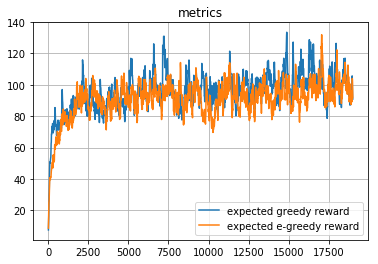

Random session examples


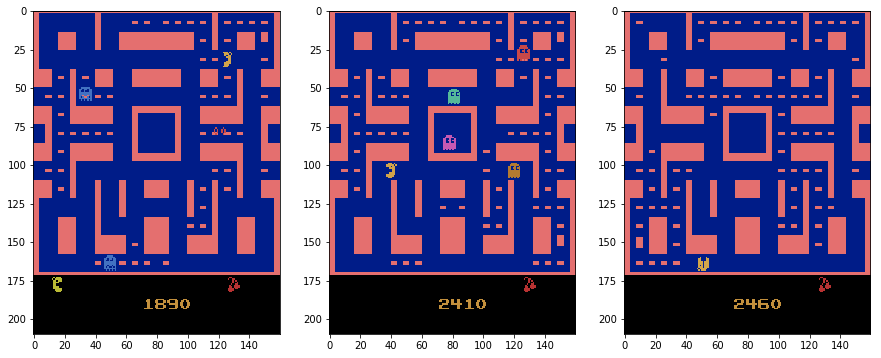

[2017-05-25 00:09:56,109] Making new env: MsPacman-v0
[2017-05-25 00:09:56,274] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 00:09:56,284] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.26.19270.video000000.mp4
[2017-05-25 00:09:58,349] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.26.19270.video000001.mp4


Episode finished after 813 timesteps with reward=430.0
Episode finished after 846 timesteps with reward=380.0
Episode finished after 635 timesteps with reward=160.0
Episode finished after 522 timesteps with reward=110.0
Episode finished after 821 timesteps with reward=190.0
Episode finished after 836 timesteps with reward=180.0
Episode finished after 451 timesteps with reward=60.0


[2017-05-25 00:10:08,001] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.26.19270.video000008.mp4


Episode finished after 915 timesteps with reward=780.0
Episode finished after 838 timesteps with reward=180.0
Episode finished after 834 timesteps with reward=180.0
Episode finished after 600 timesteps with reward=170.0
Episode finished after 456 timesteps with reward=60.0
Episode finished after 895 timesteps with reward=430.0
Episode finished after 614 timesteps with reward=110.0
Episode finished after 463 timesteps with reward=60.0
Episode finished after 660 timesteps with reward=1610.0
Episode finished after 875 timesteps with reward=180.0
Episode finished after 1056 timesteps with reward=180.0
Episode finished after 825 timesteps with reward=380.0


[2017-05-25 00:10:24,624] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 768 timesteps with reward=380.0
Mean 310.5, Var 118144.75
epoch 19010,loss 995.38030, epsilon 0.05000, rewards: ( e-greedy 96.00308, greedy 85.58731) 
rec 995.224 reg 0.156
epoch 19020,loss 3257.32836, epsilon 0.05000, rewards: ( e-greedy 104.52777, greedy 93.46608) 
rec 3257.172 reg 0.156
epoch 19030,loss 1125.37023, epsilon 0.05000, rewards: ( e-greedy 101.94999, greedy 98.05697) 
rec 1125.214 reg 0.156
epoch 19040,loss 1007.88772, epsilon 0.05000, rewards: ( e-greedy 102.69250, greedy 99.25128) 
rec 1007.732 reg 0.156
epoch 19050,loss 426.39937, epsilon 0.05000, rewards: ( e-greedy 97.73575, greedy 98.20115) 
rec 426.243 reg 0.156
epoch 19060,loss 1371.31897, epsilon 0.05000, rewards: ( e-greedy 99.83717, greedy 101.31853) 
rec 1371.163 reg 0.156
epoch 19070,loss 1867.11253, epsilon 0.05000, rewards: ( e-greedy 105.47845, greedy 105.87418) 
rec 1866.957 reg 0.156
epoch 19080,loss 440.58039, epsilon 0.05000, rewards: ( e-greedy 100.86811, greedy 101.78676) 
rec

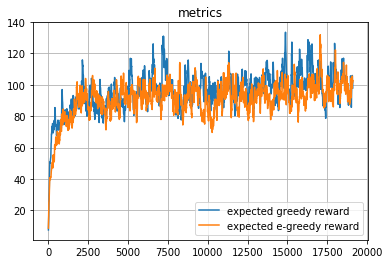

Random session examples


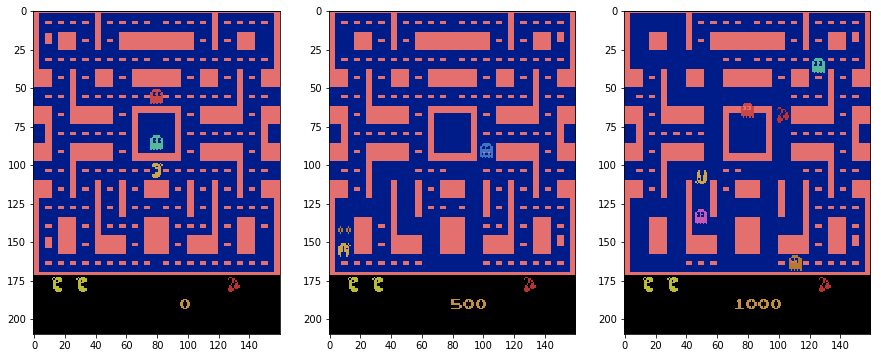

epoch 19110,loss 903.53678, epsilon 0.05000, rewards: ( e-greedy 106.05910, greedy 101.93692) 
rec 903.380 reg 0.156
epoch 19120,loss 1714.37785, epsilon 0.05000, rewards: ( e-greedy 103.07819, greedy 102.30573) 
rec 1714.221 reg 0.156
epoch 19130,loss 356.41590, epsilon 0.05000, rewards: ( e-greedy 100.64537, greedy 108.07516) 
rec 356.260 reg 0.156
epoch 19140,loss 1394.85508, epsilon 0.05000, rewards: ( e-greedy 102.39333, greedy 108.20514) 
rec 1394.699 reg 0.156
epoch 19150,loss 2726.99939, epsilon 0.05000, rewards: ( e-greedy 102.71650, greedy 104.88463) 
rec 2726.843 reg 0.156
epoch 19160,loss 1209.82858, epsilon 0.05000, rewards: ( e-greedy 103.88235, greedy 103.64617) 
rec 1209.672 reg 0.156
epoch 19170,loss 549.51891, epsilon 0.05000, rewards: ( e-greedy 101.43162, greedy 98.84405) 
rec 549.362 reg 0.157
epoch 19180,loss 329.15846, epsilon 0.05000, rewards: ( e-greedy 95.28845, greedy 93.20964) 
rec 329.002 reg 0.157
epoch 19190,loss 4539.60880, epsilon 0.05000, rewards: ( e-

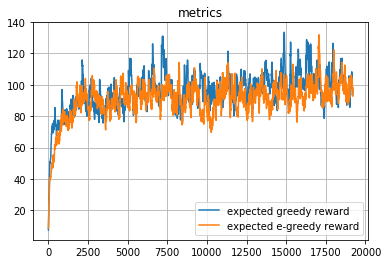

Random session examples


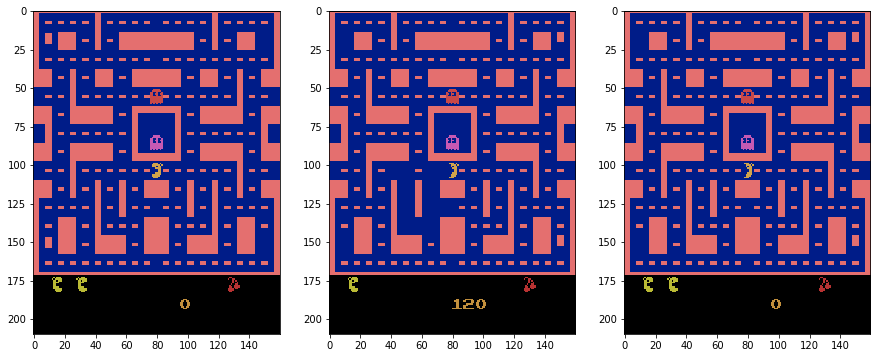

epoch 19210,loss 660.73560, epsilon 0.05000, rewards: ( e-greedy 91.14716, greedy 100.77171) 
rec 660.579 reg 0.157
epoch 19220,loss 1553.45536, epsilon 0.05000, rewards: ( e-greedy 92.34494, greedy 100.44454) 
rec 1553.299 reg 0.157
epoch 19230,loss 1531.48908, epsilon 0.05000, rewards: ( e-greedy 93.11045, greedy 94.52508) 
rec 1531.332 reg 0.157
epoch 19240,loss 804.52842, epsilon 0.05000, rewards: ( e-greedy 93.92440, greedy 95.76007) 
rec 804.372 reg 0.157
epoch 19250,loss 323.75505, epsilon 0.05000, rewards: ( e-greedy 89.78196, greedy 94.62157) 
rec 323.598 reg 0.157
epoch 19260,loss 551.64413, epsilon 0.05000, rewards: ( e-greedy 89.80377, greedy 95.59691) 
rec 551.487 reg 0.157
epoch 19270,loss 1350.52726, epsilon 0.05000, rewards: ( e-greedy 95.82339, greedy 98.47472) 
rec 1350.370 reg 0.157
epoch 19280,loss 495.10936, epsilon 0.05000, rewards: ( e-greedy 91.74105, greedy 97.93975) 
rec 494.952 reg 0.157
epoch 19290,loss 545.59173, epsilon 0.05000, rewards: ( e-greedy 91.1294

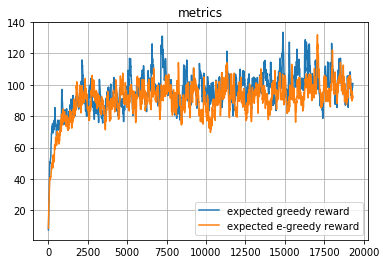

Random session examples


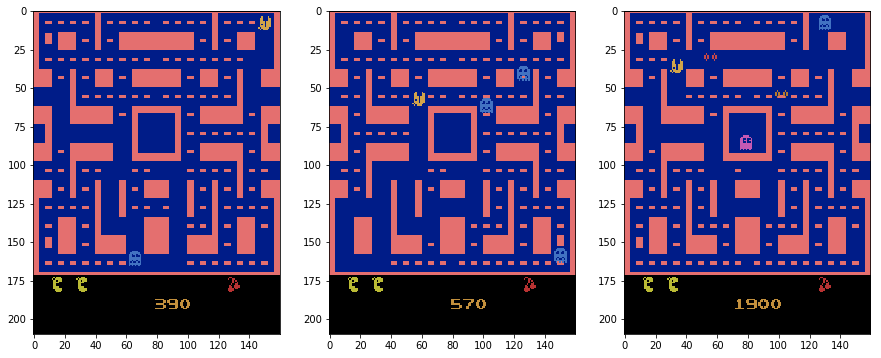

epoch 19310,loss 445.51285, epsilon 0.05000, rewards: ( e-greedy 90.30860, greedy 98.23745) 
rec 445.356 reg 0.157
epoch 19320,loss 1218.66723, epsilon 0.05000, rewards: ( e-greedy 91.96524, greedy 93.97621) 
rec 1218.510 reg 0.157
epoch 19330,loss 1097.44618, epsilon 0.05000, rewards: ( e-greedy 93.08122, greedy 96.01608) 
rec 1097.289 reg 0.157
epoch 19340,loss 1099.62507, epsilon 0.05000, rewards: ( e-greedy 91.89810, greedy 94.03948) 
rec 1099.468 reg 0.157
epoch 19350,loss 1107.96227, epsilon 0.05000, rewards: ( e-greedy 96.77079, greedy 94.32303) 
rec 1107.805 reg 0.157
epoch 19360,loss 386.84888, epsilon 0.05000, rewards: ( e-greedy 90.46871, greedy 87.70323) 
rec 386.691 reg 0.157
epoch 19370,loss 821.06642, epsilon 0.05000, rewards: ( e-greedy 92.73434, greedy 90.55790) 
rec 820.909 reg 0.157
epoch 19380,loss 1798.15431, epsilon 0.05000, rewards: ( e-greedy 92.89840, greedy 86.18961) 
rec 1797.997 reg 0.157
epoch 19390,loss 742.14783, epsilon 0.05000, rewards: ( e-greedy 93.10

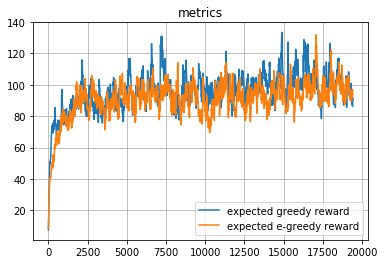

Random session examples


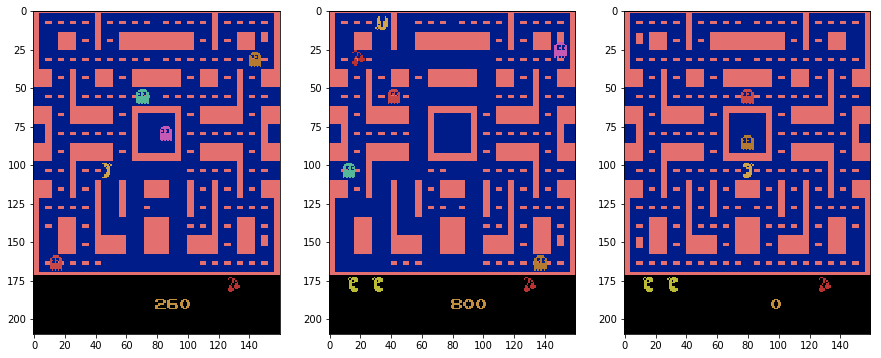

epoch 19410,loss 648.61799, epsilon 0.05000, rewards: ( e-greedy 92.62419, greedy 87.55285) 
rec 648.460 reg 0.158
epoch 19420,loss 1125.80641, epsilon 0.05000, rewards: ( e-greedy 92.42427, greedy 90.79757) 
rec 1125.649 reg 0.158
epoch 19430,loss 3022.28039, epsilon 0.05000, rewards: ( e-greedy 96.99434, greedy 89.84281) 
rec 3022.123 reg 0.158
epoch 19440,loss 3765.91323, epsilon 0.05000, rewards: ( e-greedy 99.54491, greedy 87.35853) 
rec 3765.755 reg 0.158
epoch 19450,loss 1394.80263, epsilon 0.05000, rewards: ( e-greedy 104.90292, greedy 96.87268) 
rec 1394.645 reg 0.158
epoch 19460,loss 6489.05145, epsilon 0.05000, rewards: ( e-greedy 112.35012, greedy 99.68541) 
rec 6488.894 reg 0.158
epoch 19470,loss 946.94585, epsilon 0.05000, rewards: ( e-greedy 111.42761, greedy 100.84187) 
rec 946.788 reg 0.158
epoch 19480,loss 956.43859, epsilon 0.05000, rewards: ( e-greedy 109.97235, greedy 102.57018) 
rec 956.281 reg 0.158
epoch 19490,loss 731.61597, epsilon 0.05000, rewards: ( e-greedy

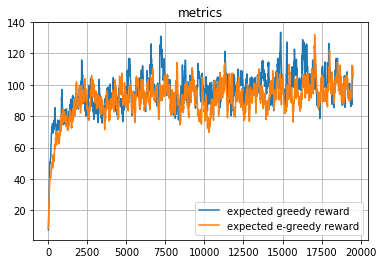

Random session examples


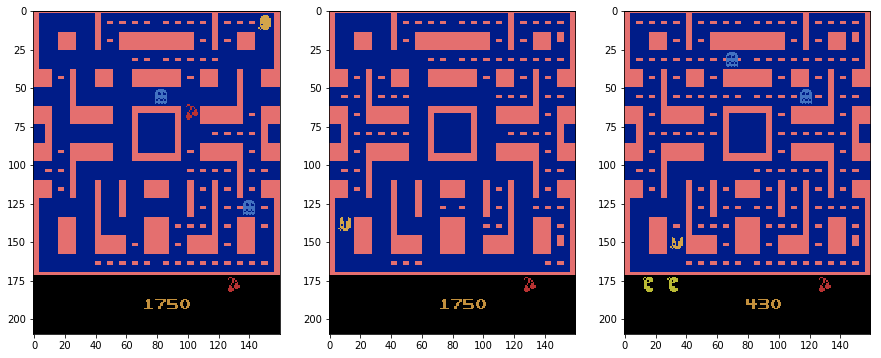

epoch 19510,loss 1682.26438, epsilon 0.05000, rewards: ( e-greedy 113.86672, greedy 108.01616) 
rec 1682.106 reg 0.158
epoch 19520,loss 551.05166, epsilon 0.05000, rewards: ( e-greedy 110.54255, greedy 108.40205) 
rec 550.894 reg 0.158
epoch 19530,loss 542.94352, epsilon 0.05000, rewards: ( e-greedy 108.30079, greedy 105.18684) 
rec 542.785 reg 0.158
epoch 19540,loss 6000.42184, epsilon 0.05000, rewards: ( e-greedy 117.65821, greedy 110.23066) 
rec 6000.264 reg 0.158
epoch 19550,loss 1604.07230, epsilon 0.05000, rewards: ( e-greedy 117.07989, greedy 104.39509) 
rec 1603.914 reg 0.158
epoch 19560,loss 700.13957, epsilon 0.05000, rewards: ( e-greedy 111.87190, greedy 99.39308) 
rec 699.981 reg 0.158
epoch 19570,loss 517.29543, epsilon 0.05000, rewards: ( e-greedy 107.74721, greedy 96.14127) 
rec 517.137 reg 0.158
epoch 19580,loss 2249.10618, epsilon 0.05000, rewards: ( e-greedy 108.22249, greedy 96.90215) 
rec 2248.948 reg 0.158
epoch 19590,loss 583.60139, epsilon 0.05000, rewards: ( e-g

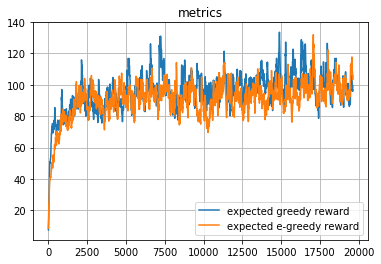

Random session examples


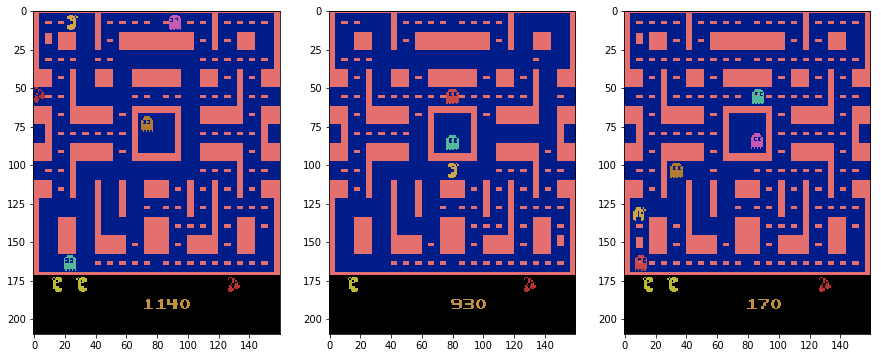

epoch 19610,loss 7501.09070, epsilon 0.05000, rewards: ( e-greedy 112.26982, greedy 96.45229) 
rec 7500.932 reg 0.159
epoch 19620,loss 2077.87442, epsilon 0.05000, rewards: ( e-greedy 111.35534, greedy 102.11956) 
rec 2077.716 reg 0.159
epoch 19630,loss 662.28992, epsilon 0.05000, rewards: ( e-greedy 107.28230, greedy 104.72010) 
rec 662.131 reg 0.159
epoch 19640,loss 1912.68339, epsilon 0.05000, rewards: ( e-greedy 107.80407, greedy 104.68559) 
rec 1912.525 reg 0.159
epoch 19650,loss 3750.15792, epsilon 0.05000, rewards: ( e-greedy 108.71117, greedy 101.77953) 
rec 3749.999 reg 0.159
epoch 19660,loss 696.46580, epsilon 0.05000, rewards: ( e-greedy 107.52755, greedy 97.35158) 
rec 696.307 reg 0.159
epoch 19670,loss 791.16707, epsilon 0.05000, rewards: ( e-greedy 104.96230, greedy 92.80392) 
rec 791.008 reg 0.159
epoch 19680,loss 887.76980, epsilon 0.05000, rewards: ( e-greedy 102.21607, greedy 91.71103) 
rec 887.611 reg 0.159
epoch 19690,loss 742.35995, epsilon 0.05000, rewards: ( e-gr

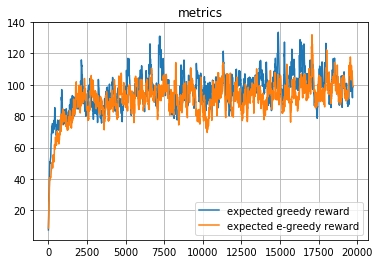

Random session examples


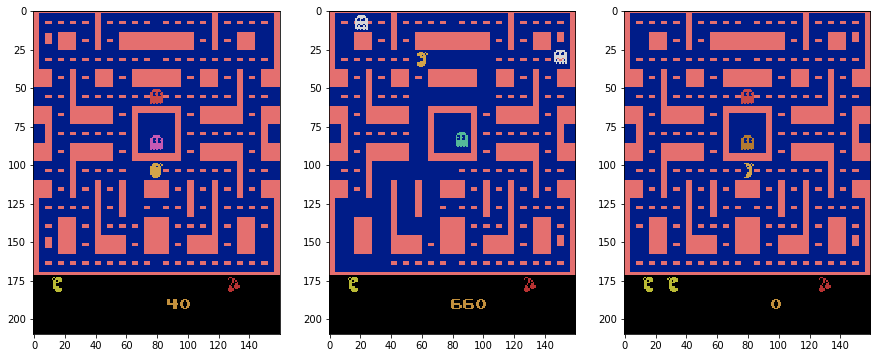

epoch 19710,loss 1749.94504, epsilon 0.05000, rewards: ( e-greedy 102.71051, greedy 99.06672) 
rec 1749.786 reg 0.159
epoch 19720,loss 1060.65300, epsilon 0.05000, rewards: ( e-greedy 104.00196, greedy 97.03504) 
rec 1060.494 reg 0.159
epoch 19730,loss 2091.23289, epsilon 0.05000, rewards: ( e-greedy 108.60176, greedy 106.64404) 
rec 2091.074 reg 0.159
epoch 19740,loss 1576.68645, epsilon 0.05000, rewards: ( e-greedy 110.24159, greedy 105.22964) 
rec 1576.527 reg 0.159
epoch 19750,loss 1478.47546, epsilon 0.05000, rewards: ( e-greedy 109.59243, greedy 100.89417) 
rec 1478.316 reg 0.159
epoch 19760,loss 1918.12031, epsilon 0.05000, rewards: ( e-greedy 107.75819, greedy 104.42976) 
rec 1917.961 reg 0.159
epoch 19770,loss 678.94618, epsilon 0.05000, rewards: ( e-greedy 105.85737, greedy 107.54928) 
rec 678.787 reg 0.159
epoch 19780,loss 502.52187, epsilon 0.05000, rewards: ( e-greedy 101.27163, greedy 104.29435) 
rec 502.362 reg 0.159
epoch 19790,loss 445.48242, epsilon 0.05000, rewards: 

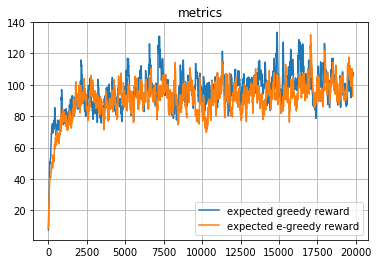

Random session examples


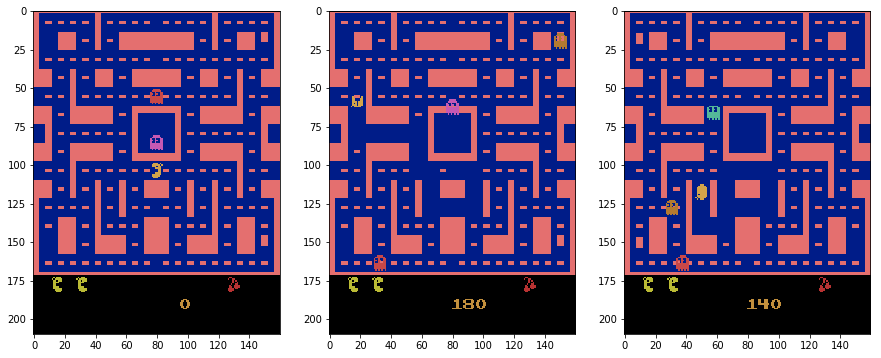

epoch 19810,loss 909.21342, epsilon 0.05000, rewards: ( e-greedy 93.61014, greedy 104.43621) 
rec 909.054 reg 0.160
epoch 19820,loss 448.09420, epsilon 0.05000, rewards: ( e-greedy 89.31163, greedy 105.18009) 
rec 447.934 reg 0.160
epoch 19830,loss 469.05052, epsilon 0.05000, rewards: ( e-greedy 88.19297, greedy 111.53708) 
rec 468.891 reg 0.160
epoch 19840,loss 1183.77525, epsilon 0.05000, rewards: ( e-greedy 89.24867, greedy 107.94587) 
rec 1183.615 reg 0.160
epoch 19850,loss 1159.66519, epsilon 0.05000, rewards: ( e-greedy 89.94880, greedy 103.90128) 
rec 1159.505 reg 0.160
epoch 19860,loss 1191.25642, epsilon 0.05000, rewards: ( e-greedy 91.14142, greedy 104.88615) 
rec 1191.096 reg 0.160
epoch 19870,loss 1014.01011, epsilon 0.05000, rewards: ( e-greedy 90.58978, greedy 103.83504) 
rec 1013.850 reg 0.160
epoch 19880,loss 483.85985, epsilon 0.05000, rewards: ( e-greedy 88.53080, greedy 110.13904) 
rec 483.700 reg 0.160
epoch 19890,loss 1282.30996, epsilon 0.05000, rewards: ( e-greed

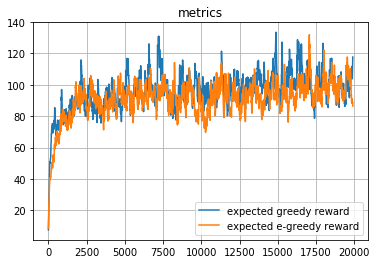

Random session examples


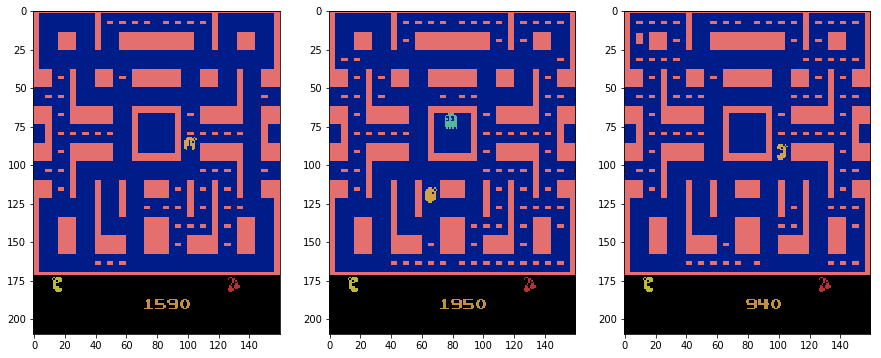

epoch 19910,loss 1727.04575, epsilon 0.05000, rewards: ( e-greedy 89.54208, greedy 113.41948) 
rec 1726.885 reg 0.160
epoch 19920,loss 426.04924, epsilon 0.05000, rewards: ( e-greedy 85.83787, greedy 108.45253) 
rec 425.889 reg 0.160
epoch 19930,loss 2872.70327, epsilon 0.05000, rewards: ( e-greedy 86.87908, greedy 104.35728) 
rec 2872.543 reg 0.160
epoch 19940,loss 1658.26372, epsilon 0.05000, rewards: ( e-greedy 90.31618, greedy 101.92155) 
rec 1658.103 reg 0.160
epoch 19950,loss 777.06160, epsilon 0.05000, rewards: ( e-greedy 91.09706, greedy 104.22940) 
rec 776.901 reg 0.160
epoch 19960,loss 677.98695, epsilon 0.05000, rewards: ( e-greedy 86.29985, greedy 101.55646) 
rec 677.827 reg 0.160
epoch 19970,loss 491.16901, epsilon 0.05000, rewards: ( e-greedy 84.91987, greedy 95.96331) 
rec 491.009 reg 0.160
epoch 19980,loss 2310.88025, epsilon 0.05000, rewards: ( e-greedy 90.24038, greedy 95.86698) 
rec 2310.720 reg 0.161
epoch 19990,loss 1256.86760, epsilon 0.05000, rewards: ( e-greedy 

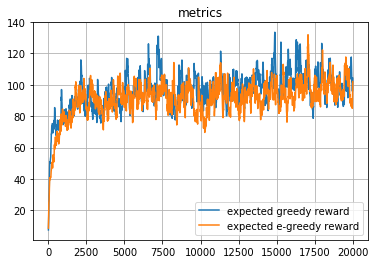

Random session examples


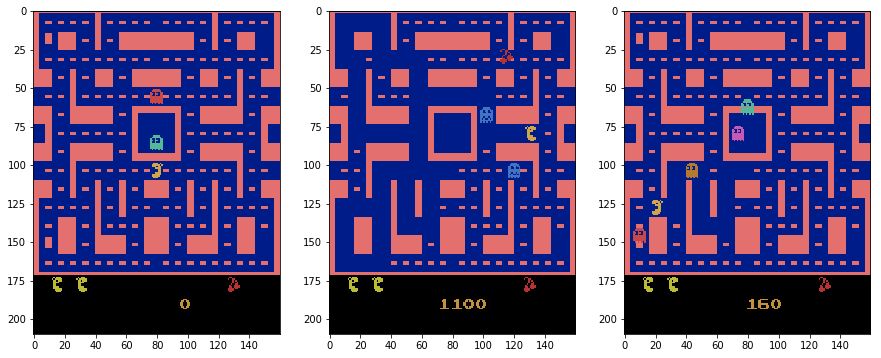

[2017-05-25 00:36:13,774] Making new env: MsPacman-v0
[2017-05-25 00:36:13,940] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 00:36:13,949] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.27.19270.video000000.mp4
[2017-05-25 00:36:16,046] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.27.19270.video000001.mp4


Episode finished after 866 timesteps with reward=960.0
Episode finished after 628 timesteps with reward=320.0
Episode finished after 679 timesteps with reward=300.0
Episode finished after 880 timesteps with reward=300.0
Episode finished after 856 timesteps with reward=240.0
Episode finished after 674 timesteps with reward=280.0
Episode finished after 803 timesteps with reward=240.0


[2017-05-25 00:36:26,004] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.27.19270.video000008.mp4


Episode finished after 882 timesteps with reward=240.0
Episode finished after 897 timesteps with reward=240.0
Episode finished after 500 timesteps with reward=210.0
Episode finished after 906 timesteps with reward=280.0
Episode finished after 617 timesteps with reward=170.0
Episode finished after 674 timesteps with reward=250.0
Episode finished after 587 timesteps with reward=240.0
Episode finished after 694 timesteps with reward=240.0
Episode finished after 586 timesteps with reward=230.0
Episode finished after 685 timesteps with reward=240.0
Episode finished after 687 timesteps with reward=300.0
Episode finished after 711 timesteps with reward=260.0


[2017-05-25 00:36:41,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 797 timesteps with reward=200.0
Mean 287.0, Var 25131.0
epoch 20010,loss 742.86373, epsilon 0.05000, rewards: ( e-greedy 98.40336, greedy 101.83390) 
rec 742.703 reg 0.161
epoch 20020,loss 656.87824, epsilon 0.05000, rewards: ( e-greedy 96.18803, greedy 99.08801) 
rec 656.718 reg 0.161
epoch 20030,loss 791.84787, epsilon 0.05000, rewards: ( e-greedy 92.50672, greedy 96.17921) 
rec 791.687 reg 0.161
epoch 20040,loss 1454.64385, epsilon 0.05000, rewards: ( e-greedy 96.38105, greedy 99.43629) 
rec 1454.483 reg 0.161
epoch 20050,loss 655.72565, epsilon 0.05000, rewards: ( e-greedy 92.86795, greedy 96.86766) 
rec 655.565 reg 0.161
epoch 20060,loss 299.59339, epsilon 0.05000, rewards: ( e-greedy 89.58115, greedy 94.55590) 
rec 299.433 reg 0.161
epoch 20070,loss 2328.50469, epsilon 0.05000, rewards: ( e-greedy 90.99804, greedy 97.97531) 
rec 2328.344 reg 0.161
epoch 20080,loss 1063.00562, epsilon 0.05000, rewards: ( e-greedy 88.52323, greedy 97.36528) 
rec 1062.845 reg 

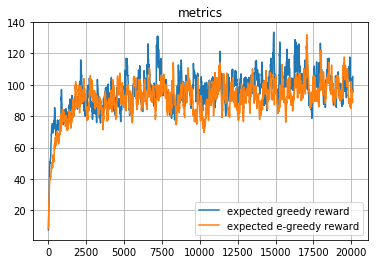

Random session examples


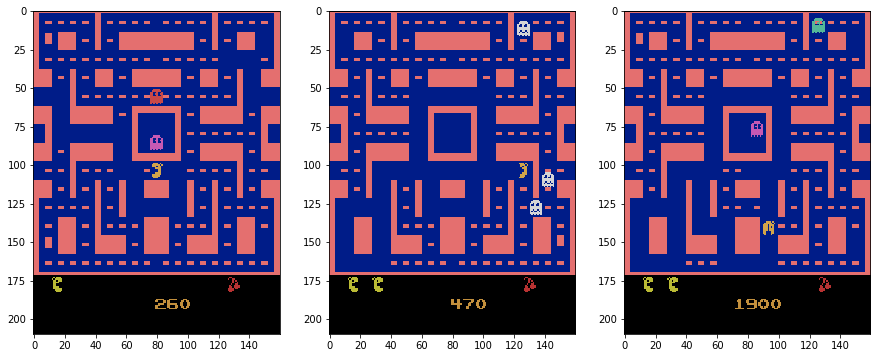

epoch 20110,loss 4627.18596, epsilon 0.05000, rewards: ( e-greedy 93.52531, greedy 105.35929) 
rec 4627.025 reg 0.161
epoch 20120,loss 1174.99805, epsilon 0.05000, rewards: ( e-greedy 94.11028, greedy 101.63586) 
rec 1174.837 reg 0.161
epoch 20130,loss 614.85174, epsilon 0.05000, rewards: ( e-greedy 90.44925, greedy 97.78477) 
rec 614.691 reg 0.161
epoch 20140,loss 432.85493, epsilon 0.05000, rewards: ( e-greedy 85.27933, greedy 91.75629) 
rec 432.694 reg 0.161
epoch 20150,loss 2218.31558, epsilon 0.05000, rewards: ( e-greedy 91.62639, greedy 94.26816) 
rec 2218.154 reg 0.161
epoch 20160,loss 708.99828, epsilon 0.05000, rewards: ( e-greedy 91.02626, greedy 90.02885) 
rec 708.837 reg 0.161
epoch 20170,loss 437.08459, epsilon 0.05000, rewards: ( e-greedy 87.73613, greedy 89.33846) 
rec 436.923 reg 0.161
epoch 20180,loss 822.37391, epsilon 0.05000, rewards: ( e-greedy 86.58752, greedy 87.40462) 
rec 822.212 reg 0.161
epoch 20190,loss 7176.42283, epsilon 0.05000, rewards: ( e-greedy 93.303

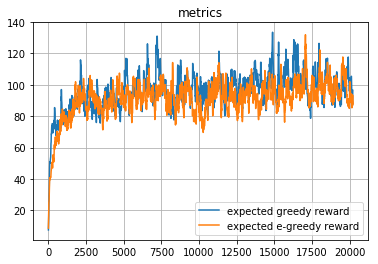

Random session examples


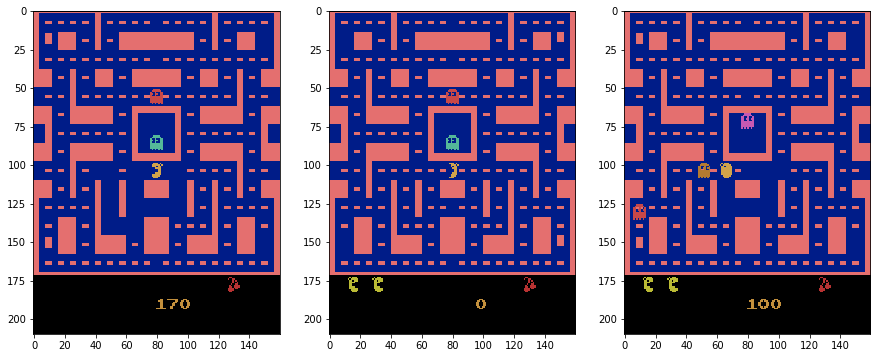

epoch 20210,loss 1139.90164, epsilon 0.05000, rewards: ( e-greedy 89.31980, greedy 105.53609) 
rec 1139.740 reg 0.162
epoch 20220,loss 968.96066, epsilon 0.05000, rewards: ( e-greedy 87.38782, greedy 103.29498) 
rec 968.799 reg 0.162
epoch 20230,loss 863.89025, epsilon 0.05000, rewards: ( e-greedy 87.14904, greedy 105.65298) 
rec 863.729 reg 0.162
epoch 20240,loss 773.89439, epsilon 0.05000, rewards: ( e-greedy 88.24663, greedy 101.52519) 
rec 773.733 reg 0.162
epoch 20250,loss 550.84314, epsilon 0.05000, rewards: ( e-greedy 85.54697, greedy 104.49767) 
rec 550.681 reg 0.162
epoch 20260,loss 592.93068, epsilon 0.05000, rewards: ( e-greedy 85.17977, greedy 101.42290) 
rec 592.769 reg 0.162
epoch 20270,loss 3378.95718, epsilon 0.05000, rewards: ( e-greedy 93.28680, greedy 119.71811) 
rec 3378.795 reg 0.162
epoch 20280,loss 2520.41086, epsilon 0.05000, rewards: ( e-greedy 99.77062, greedy 119.74630) 
rec 2520.249 reg 0.162
epoch 20290,loss 5016.58767, epsilon 0.05000, rewards: ( e-greedy 

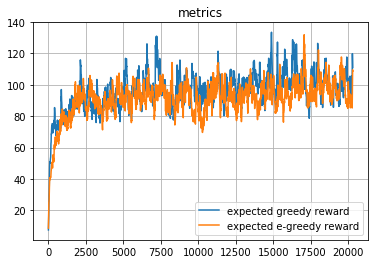

Random session examples


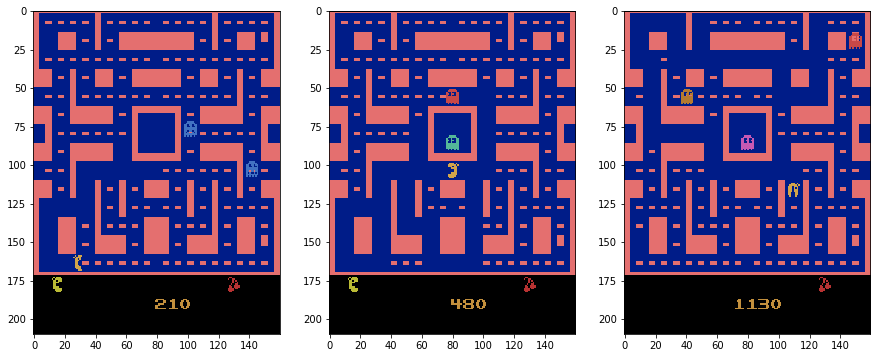

epoch 20310,loss 2149.20495, epsilon 0.05000, rewards: ( e-greedy 111.04215, greedy 107.94130) 
rec 2149.043 reg 0.162
epoch 20320,loss 2310.29943, epsilon 0.05000, rewards: ( e-greedy 110.68794, greedy 105.08467) 
rec 2310.137 reg 0.162
epoch 20330,loss 2893.74602, epsilon 0.05000, rewards: ( e-greedy 114.55665, greedy 97.63870) 
rec 2893.584 reg 0.162
epoch 20340,loss 674.17296, epsilon 0.05000, rewards: ( e-greedy 110.16348, greedy 99.62483) 
rec 674.011 reg 0.162
epoch 20350,loss 706.65515, epsilon 0.05000, rewards: ( e-greedy 107.39713, greedy 101.84985) 
rec 706.493 reg 0.162
epoch 20360,loss 1214.96908, epsilon 0.05000, rewards: ( e-greedy 106.53242, greedy 98.03987) 
rec 1214.807 reg 0.162
epoch 20370,loss 830.82372, epsilon 0.05000, rewards: ( e-greedy 103.75418, greedy 104.73588) 
rec 830.661 reg 0.162
epoch 20380,loss 533.31795, epsilon 0.05000, rewards: ( e-greedy 98.06626, greedy 102.51229) 
rec 533.156 reg 0.162
epoch 20390,loss 1263.01054, epsilon 0.05000, rewards: ( e-g

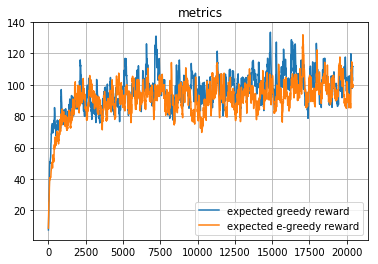

Random session examples


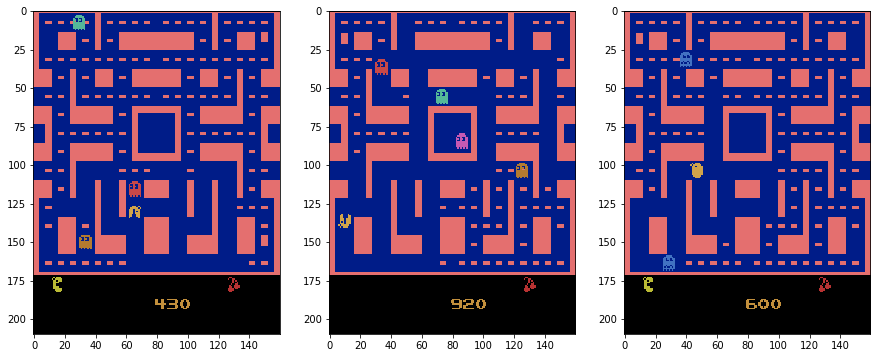

epoch 20410,loss 445.40797, epsilon 0.05000, rewards: ( e-greedy 93.59905, greedy 110.61396) 
rec 445.246 reg 0.162
epoch 20420,loss 926.48940, epsilon 0.05000, rewards: ( e-greedy 94.30165, greedy 107.74006) 
rec 926.327 reg 0.163
epoch 20430,loss 284.44827, epsilon 0.05000, rewards: ( e-greedy 87.24648, greedy 102.52856) 
rec 284.286 reg 0.163
epoch 20440,loss 1740.89951, epsilon 0.05000, rewards: ( e-greedy 86.89683, greedy 102.27570) 
rec 1740.737 reg 0.163
epoch 20450,loss 2860.12034, epsilon 0.05000, rewards: ( e-greedy 95.45715, greedy 103.79813) 
rec 2859.958 reg 0.163
epoch 20460,loss 2236.68407, epsilon 0.05000, rewards: ( e-greedy 94.09894, greedy 97.29332) 
rec 2236.521 reg 0.163
epoch 20470,loss 1467.22389, epsilon 0.05000, rewards: ( e-greedy 96.43904, greedy 95.81399) 
rec 1467.061 reg 0.163
epoch 20480,loss 482.37013, epsilon 0.05000, rewards: ( e-greedy 91.73264, greedy 95.35759) 
rec 482.208 reg 0.163
epoch 20490,loss 995.32747, epsilon 0.05000, rewards: ( e-greedy 86

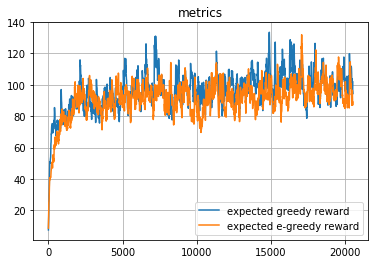

Random session examples


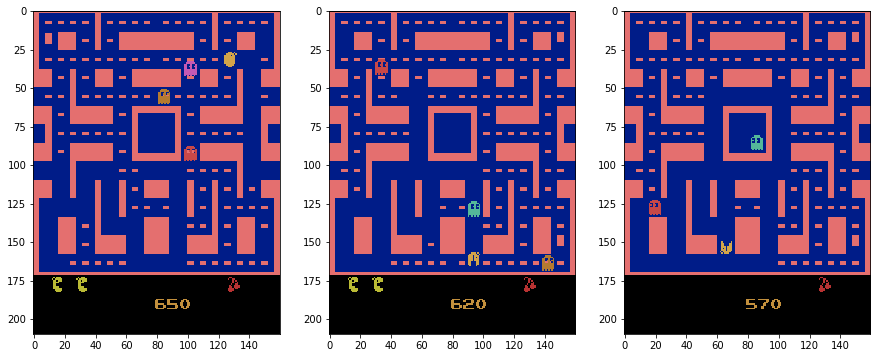

epoch 20510,loss 2190.09411, epsilon 0.05000, rewards: ( e-greedy 89.52372, greedy 102.17881) 
rec 2189.931 reg 0.163
epoch 20520,loss 3037.81101, epsilon 0.05000, rewards: ( e-greedy 100.63385, greedy 106.89843) 
rec 3037.648 reg 0.163
epoch 20530,loss 837.88171, epsilon 0.05000, rewards: ( e-greedy 103.07046, greedy 109.33358) 
rec 837.719 reg 0.163
epoch 20540,loss 770.04644, epsilon 0.05000, rewards: ( e-greedy 103.51342, greedy 108.77523) 
rec 769.883 reg 0.163
epoch 20550,loss 1506.70455, epsilon 0.05000, rewards: ( e-greedy 105.09957, greedy 108.71020) 
rec 1506.542 reg 0.163
epoch 20560,loss 7288.90865, epsilon 0.05000, rewards: ( e-greedy 112.83962, greedy 106.90168) 
rec 7288.746 reg 0.163
epoch 20570,loss 544.41108, epsilon 0.05000, rewards: ( e-greedy 106.99316, greedy 102.89901) 
rec 544.248 reg 0.163
epoch 20580,loss 465.67989, epsilon 0.05000, rewards: ( e-greedy 102.60634, greedy 98.73411) 
rec 465.517 reg 0.163
epoch 20590,loss 5548.53916, epsilon 0.05000, rewards: ( e

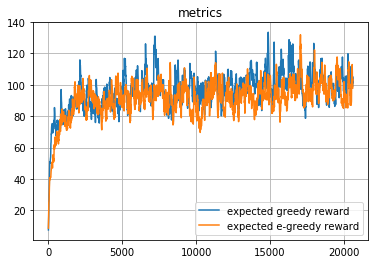

Random session examples


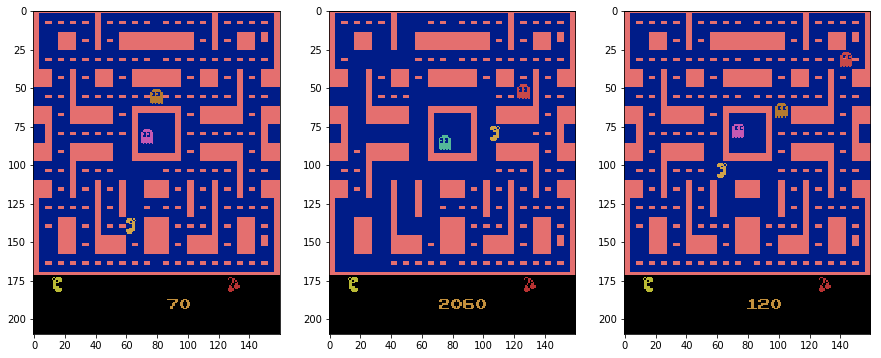

epoch 20610,loss 619.62082, epsilon 0.05000, rewards: ( e-greedy 97.76752, greedy 99.22779) 
rec 619.458 reg 0.163
epoch 20620,loss 2501.58104, epsilon 0.05000, rewards: ( e-greedy 100.05327, greedy 98.43001) 
rec 2501.418 reg 0.163
epoch 20630,loss 703.47373, epsilon 0.05000, rewards: ( e-greedy 98.61044, greedy 101.33701) 
rec 703.310 reg 0.163
epoch 20640,loss 1019.18229, epsilon 0.05000, rewards: ( e-greedy 95.62440, greedy 100.76581) 
rec 1019.019 reg 0.163
epoch 20650,loss 2177.92593, epsilon 0.05000, rewards: ( e-greedy 99.68696, greedy 112.75173) 
rec 2177.762 reg 0.163
epoch 20660,loss 414.85689, epsilon 0.05000, rewards: ( e-greedy 94.46826, greedy 106.35156) 
rec 414.693 reg 0.164
epoch 20670,loss 1405.81486, epsilon 0.05000, rewards: ( e-greedy 95.77144, greedy 108.77890) 
rec 1405.651 reg 0.164
epoch 20680,loss 1210.73289, epsilon 0.05000, rewards: ( e-greedy 95.25679, greedy 110.90101) 
rec 1210.569 reg 0.164
epoch 20690,loss 2943.65102, epsilon 0.05000, rewards: ( e-gree

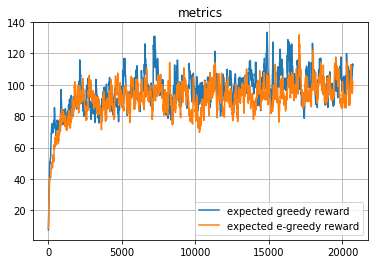

Random session examples


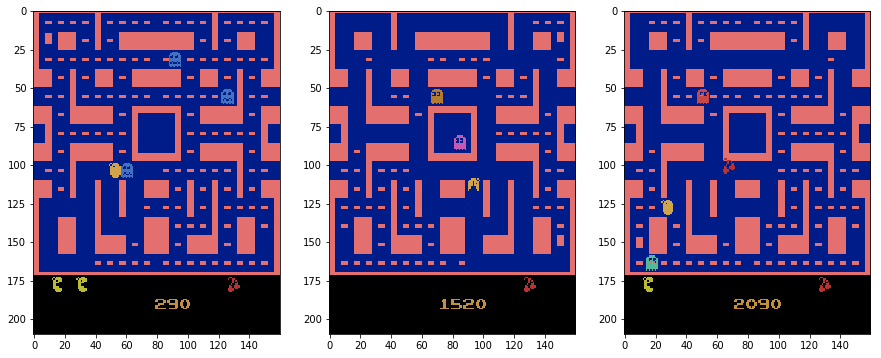

epoch 20710,loss 650.50759, epsilon 0.05000, rewards: ( e-greedy 97.17533, greedy 108.78746) 
rec 650.344 reg 0.164
epoch 20720,loss 1352.16733, epsilon 0.05000, rewards: ( e-greedy 98.14529, greedy 117.72122) 
rec 1352.003 reg 0.164
epoch 20730,loss 1757.87225, epsilon 0.05000, rewards: ( e-greedy 95.70576, greedy 113.82409) 
rec 1757.708 reg 0.164
epoch 20740,loss 3565.66832, epsilon 0.05000, rewards: ( e-greedy 104.13519, greedy 115.37918) 
rec 3565.504 reg 0.164
epoch 20750,loss 2696.22411, epsilon 0.05000, rewards: ( e-greedy 111.22167, greedy 120.09127) 
rec 2696.060 reg 0.164
epoch 20760,loss 721.73286, epsilon 0.05000, rewards: ( e-greedy 108.03700, greedy 117.14464) 
rec 721.569 reg 0.164
epoch 20770,loss 1087.95369, epsilon 0.05000, rewards: ( e-greedy 105.73330, greedy 123.30518) 
rec 1087.790 reg 0.164
epoch 20780,loss 539.45154, epsilon 0.05000, rewards: ( e-greedy 101.47247, greedy 123.59966) 
rec 539.287 reg 0.164
epoch 20790,loss 876.32587, epsilon 0.05000, rewards: ( e

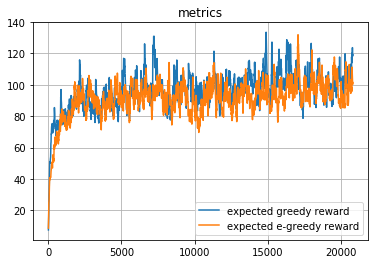

Random session examples


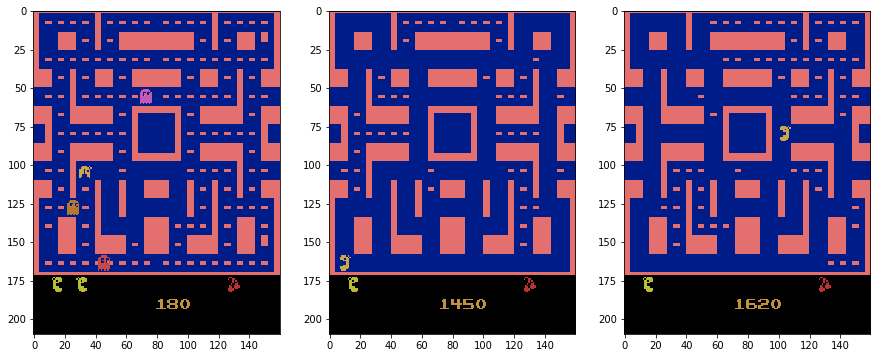

epoch 20810,loss 1235.49285, epsilon 0.05000, rewards: ( e-greedy 101.85593, greedy 117.51728) 
rec 1235.329 reg 0.164
epoch 20820,loss 723.99695, epsilon 0.05000, rewards: ( e-greedy 100.73284, greedy 114.70305) 
rec 723.833 reg 0.164
epoch 20830,loss 1160.42168, epsilon 0.05000, rewards: ( e-greedy 102.09706, greedy 116.04524) 
rec 1160.257 reg 0.164
epoch 20840,loss 1512.97556, epsilon 0.05000, rewards: ( e-greedy 101.44985, greedy 113.00322) 
rec 1512.811 reg 0.164
epoch 20850,loss 668.20273, epsilon 0.05000, rewards: ( e-greedy 97.30486, greedy 110.82790) 
rec 668.038 reg 0.165
epoch 20860,loss 416.82838, epsilon 0.05000, rewards: ( e-greedy 94.01188, greedy 106.18261) 
rec 416.664 reg 0.165
epoch 20870,loss 817.08188, epsilon 0.05000, rewards: ( e-greedy 96.67319, greedy 106.68935) 
rec 816.917 reg 0.165
epoch 20880,loss 1694.41073, epsilon 0.05000, rewards: ( e-greedy 99.00587, greedy 106.08291) 
rec 1694.246 reg 0.165
epoch 20890,loss 1804.98586, epsilon 0.05000, rewards: ( e-g

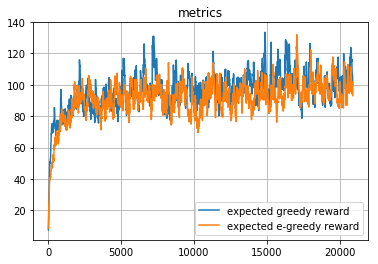

Random session examples


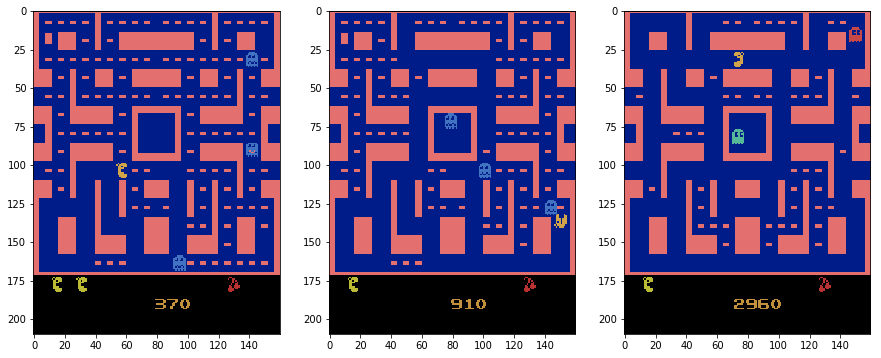

epoch 20910,loss 506.22624, epsilon 0.05000, rewards: ( e-greedy 89.83091, greedy 99.41757) 
rec 506.062 reg 0.165
epoch 20920,loss 441.09905, epsilon 0.05000, rewards: ( e-greedy 86.66031, greedy 97.28831) 
rec 440.934 reg 0.165
epoch 20930,loss 679.25436, epsilon 0.05000, rewards: ( e-greedy 84.86928, greedy 95.30948) 
rec 679.090 reg 0.165
epoch 20940,loss 927.91408, epsilon 0.05000, rewards: ( e-greedy 87.19485, greedy 95.59103) 
rec 927.749 reg 0.165
epoch 20950,loss 2695.37163, epsilon 0.05000, rewards: ( e-greedy 88.91287, greedy 90.96943) 
rec 2695.207 reg 0.165
epoch 20960,loss 713.20634, epsilon 0.05000, rewards: ( e-greedy 88.70908, greedy 87.80999) 
rec 713.041 reg 0.165
epoch 20970,loss 1085.42556, epsilon 0.05000, rewards: ( e-greedy 90.65067, greedy 90.84149) 
rec 1085.261 reg 0.165
epoch 20980,loss 396.37645, epsilon 0.05000, rewards: ( e-greedy 87.39811, greedy 87.25734) 
rec 396.211 reg 0.165
epoch 20990,loss 431.25264, epsilon 0.05000, rewards: ( e-greedy 84.15830, g

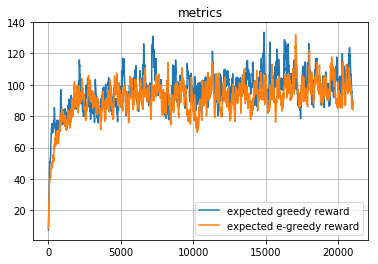

Random session examples


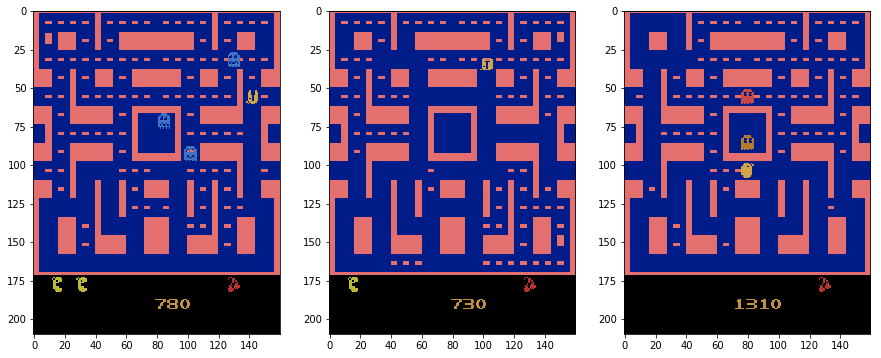

[2017-05-25 01:02:22,736] Making new env: MsPacman-v0
[2017-05-25 01:02:22,996] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 01:02:23,005] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.28.19270.video000000.mp4
[2017-05-25 01:02:24,564] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.28.19270.video000001.mp4


Episode finished after 624 timesteps with reward=380.0
Episode finished after 481 timesteps with reward=110.0
Episode finished after 653 timesteps with reward=380.0
Episode finished after 684 timesteps with reward=130.0
Episode finished after 482 timesteps with reward=110.0
Episode finished after 456 timesteps with reward=60.0
Episode finished after 479 timesteps with reward=110.0


[2017-05-25 01:02:32,169] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.28.19270.video000008.mp4


Episode finished after 688 timesteps with reward=110.0
Episode finished after 883 timesteps with reward=180.0
Episode finished after 890 timesteps with reward=180.0
Episode finished after 475 timesteps with reward=70.0
Episode finished after 733 timesteps with reward=110.0
Episode finished after 475 timesteps with reward=110.0
Episode finished after 750 timesteps with reward=110.0
Episode finished after 481 timesteps with reward=110.0
Episode finished after 449 timesteps with reward=60.0
Episode finished after 614 timesteps with reward=110.0
Episode finished after 735 timesteps with reward=110.0
Episode finished after 851 timesteps with reward=180.0


[2017-05-25 01:02:46,977] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 693 timesteps with reward=180.0
Mean 145.0, Var 7395.0
epoch 21010,loss 454.48637, epsilon 0.05000, rewards: ( e-greedy 86.34322, greedy 94.73185) 
rec 454.321 reg 0.165
epoch 21020,loss 406.91027, epsilon 0.05000, rewards: ( e-greedy 82.95890, greedy 95.13366) 
rec 406.745 reg 0.165
epoch 21030,loss 414.56353, epsilon 0.05000, rewards: ( e-greedy 81.03801, greedy 93.74530) 
rec 414.398 reg 0.165
epoch 21040,loss 523.54829, epsilon 0.05000, rewards: ( e-greedy 77.43421, greedy 91.62077) 
rec 523.383 reg 0.165
epoch 21050,loss 1981.86999, epsilon 0.05000, rewards: ( e-greedy 80.69079, greedy 89.89619) 
rec 1981.705 reg 0.165
epoch 21060,loss 397.72170, epsilon 0.05000, rewards: ( e-greedy 76.74671, greedy 86.09407) 
rec 397.556 reg 0.165
epoch 21070,loss 635.56186, epsilon 0.05000, rewards: ( e-greedy 74.19704, greedy 82.04717) 
rec 635.397 reg 0.165
epoch 21080,loss 2121.09081, epsilon 0.05000, rewards: ( e-greedy 75.77733, greedy 82.27995) 
rec 2120.926 reg 0.16

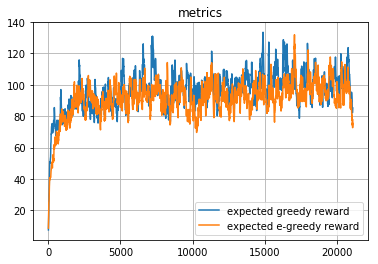

Random session examples


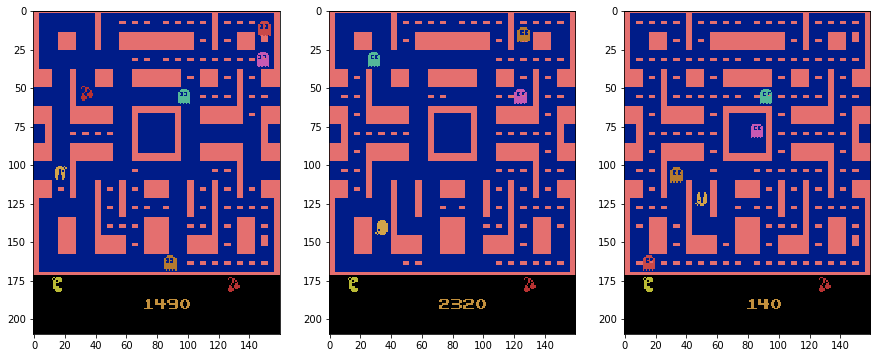

epoch 21110,loss 914.88050, epsilon 0.05000, rewards: ( e-greedy 77.04855, greedy 94.41021) 
rec 914.715 reg 0.165
epoch 21120,loss 1782.70241, epsilon 0.05000, rewards: ( e-greedy 81.59370, greedy 103.46919) 
rec 1782.537 reg 0.165
epoch 21130,loss 1644.22367, epsilon 0.05000, rewards: ( e-greedy 84.55933, greedy 102.74727) 
rec 1644.058 reg 0.165
epoch 21140,loss 675.06733, epsilon 0.05000, rewards: ( e-greedy 84.16589, greedy 104.09754) 
rec 674.902 reg 0.165
epoch 21150,loss 276.11002, epsilon 0.05000, rewards: ( e-greedy 79.49930, greedy 101.68779) 
rec 275.945 reg 0.165
epoch 21160,loss 3222.53069, epsilon 0.05000, rewards: ( e-greedy 90.67437, greedy 101.39401) 
rec 3222.365 reg 0.165
epoch 21170,loss 1196.48912, epsilon 0.05000, rewards: ( e-greedy 96.29444, greedy 105.25461) 
rec 1196.324 reg 0.166
epoch 21180,loss 534.23525, epsilon 0.05000, rewards: ( e-greedy 94.85249, greedy 100.10415) 
rec 534.070 reg 0.166
epoch 21190,loss 336.85231, epsilon 0.05000, rewards: ( e-greedy 

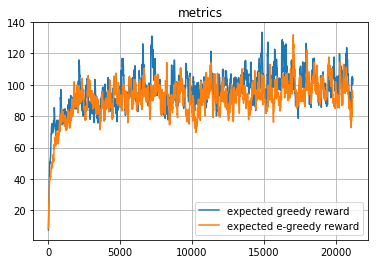

Random session examples


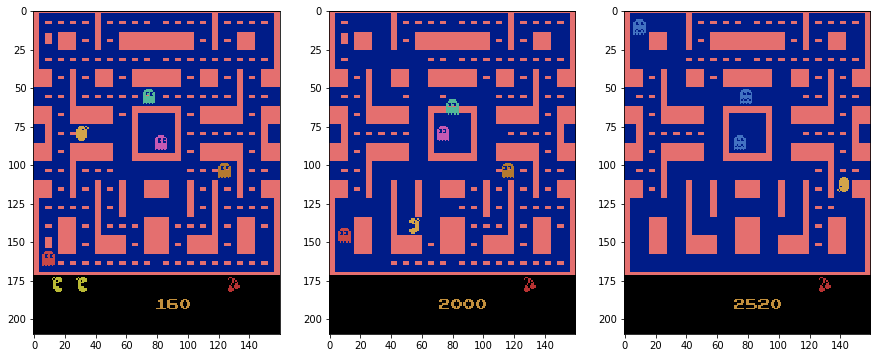

epoch 21210,loss 2266.10828, epsilon 0.05000, rewards: ( e-greedy 94.00434, greedy 100.54217) 
rec 2265.943 reg 0.166
epoch 21220,loss 1155.88609, epsilon 0.05000, rewards: ( e-greedy 93.41641, greedy 96.17546) 
rec 1155.720 reg 0.166
epoch 21230,loss 368.71096, epsilon 0.05000, rewards: ( e-greedy 88.51227, greedy 96.93291) 
rec 368.545 reg 0.166
epoch 21240,loss 274.08675, epsilon 0.05000, rewards: ( e-greedy 85.84854, greedy 94.55212) 
rec 273.921 reg 0.166
epoch 21250,loss 478.05534, epsilon 0.05000, rewards: ( e-greedy 82.57619, greedy 92.59691) 
rec 477.890 reg 0.166
epoch 21260,loss 3327.42771, epsilon 0.05000, rewards: ( e-greedy 88.38107, greedy 96.33722) 
rec 3327.262 reg 0.166
epoch 21270,loss 749.44579, epsilon 0.05000, rewards: ( e-greedy 89.85546, greedy 99.32849) 
rec 749.280 reg 0.166
epoch 21280,loss 691.61143, epsilon 0.05000, rewards: ( e-greedy 88.36991, greedy 98.45815) 
rec 691.446 reg 0.166
epoch 21290,loss 6900.83091, epsilon 0.05000, rewards: ( e-greedy 101.345

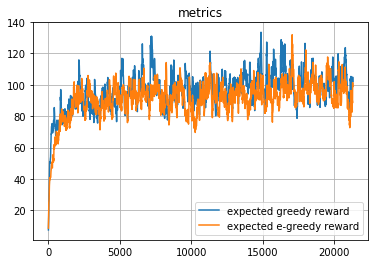

Random session examples


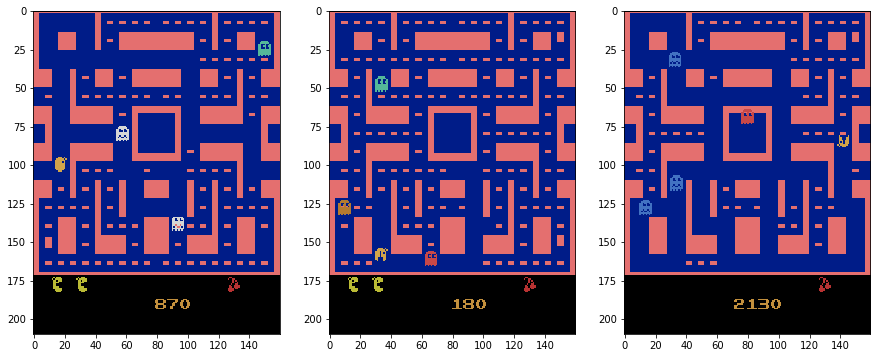

epoch 21310,loss 1076.41001, epsilon 0.05000, rewards: ( e-greedy 98.80854, greedy 106.54474) 
rec 1076.244 reg 0.166
epoch 21320,loss 725.52411, epsilon 0.05000, rewards: ( e-greedy 97.30269, greedy 101.95276) 
rec 725.358 reg 0.166
epoch 21330,loss 680.61998, epsilon 0.05000, rewards: ( e-greedy 95.19742, greedy 100.06999) 
rec 680.454 reg 0.166
epoch 21340,loss 1122.66581, epsilon 0.05000, rewards: ( e-greedy 94.05268, greedy 100.56299) 
rec 1122.500 reg 0.166
epoch 21350,loss 669.58288, epsilon 0.05000, rewards: ( e-greedy 91.89741, greedy 98.63169) 
rec 669.417 reg 0.166
epoch 21360,loss 2298.93862, epsilon 0.05000, rewards: ( e-greedy 94.20767, greedy 97.70602) 
rec 2298.773 reg 0.166
epoch 21370,loss 708.08240, epsilon 0.05000, rewards: ( e-greedy 94.41190, greedy 99.56042) 
rec 707.916 reg 0.166
epoch 21380,loss 674.42815, epsilon 0.05000, rewards: ( e-greedy 90.72071, greedy 96.47938) 
rec 674.262 reg 0.166
epoch 21390,loss 1564.75369, epsilon 0.05000, rewards: ( e-greedy 98.2

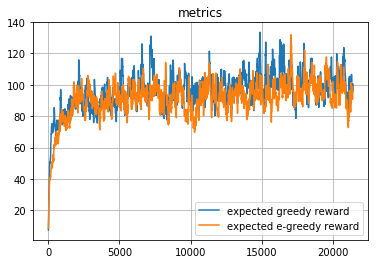

Random session examples


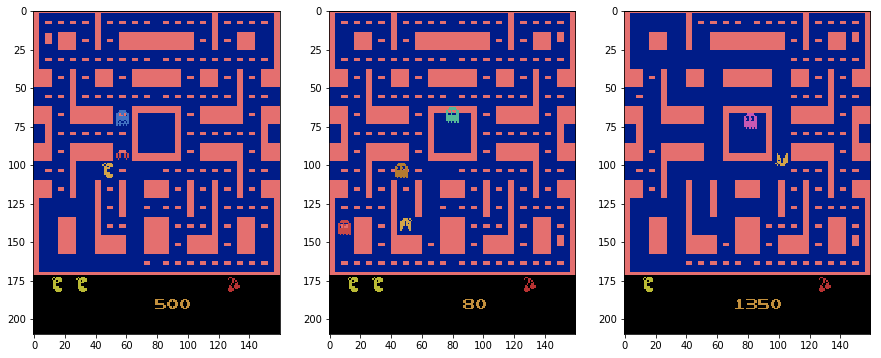

epoch 21410,loss 1553.15269, epsilon 0.05000, rewards: ( e-greedy 99.95102, greedy 101.68284) 
rec 1552.986 reg 0.166
epoch 21420,loss 1973.19155, epsilon 0.05000, rewards: ( e-greedy 99.39342, greedy 104.13956) 
rec 1973.025 reg 0.166
epoch 21430,loss 860.31777, epsilon 0.05000, rewards: ( e-greedy 97.20408, greedy 102.72560) 
rec 860.151 reg 0.166
epoch 21440,loss 2078.59266, epsilon 0.05000, rewards: ( e-greedy 96.35867, greedy 105.70304) 
rec 2078.426 reg 0.166
epoch 21450,loss 1565.14888, epsilon 0.05000, rewards: ( e-greedy 99.03530, greedy 103.88274) 
rec 1564.982 reg 0.166
epoch 21460,loss 1888.90542, epsilon 0.05000, rewards: ( e-greedy 104.69427, greedy 100.30696) 
rec 1888.739 reg 0.167
epoch 21470,loss 420.53834, epsilon 0.05000, rewards: ( e-greedy 99.72485, greedy 100.15127) 
rec 420.372 reg 0.167
epoch 21480,loss 998.53115, epsilon 0.05000, rewards: ( e-greedy 98.37736, greedy 102.26114) 
rec 998.365 reg 0.167
epoch 21490,loss 454.57483, epsilon 0.05000, rewards: ( e-gre

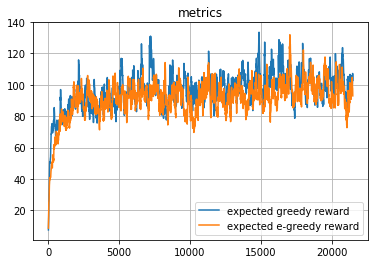

Random session examples


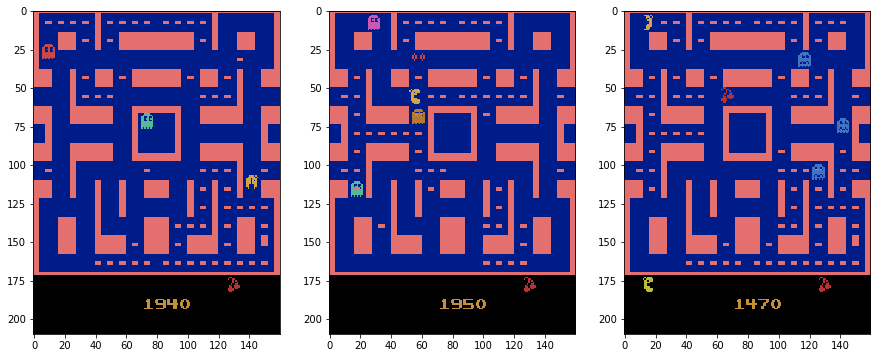

epoch 21510,loss 934.11019, epsilon 0.05000, rewards: ( e-greedy 95.05147, greedy 103.54337) 
rec 933.943 reg 0.167
epoch 21520,loss 1760.59220, epsilon 0.05000, rewards: ( e-greedy 97.04632, greedy 106.25153) 
rec 1760.425 reg 0.167
epoch 21530,loss 1838.35240, epsilon 0.05000, rewards: ( e-greedy 102.90419, greedy 106.93888) 
rec 1838.185 reg 0.167
epoch 21540,loss 1162.32623, epsilon 0.05000, rewards: ( e-greedy 101.48877, greedy 102.74499) 
rec 1162.159 reg 0.167
epoch 21550,loss 995.73049, epsilon 0.05000, rewards: ( e-greedy 98.52740, greedy 98.97049) 
rec 995.563 reg 0.167
epoch 21560,loss 435.04037, epsilon 0.05000, rewards: ( e-greedy 95.86216, greedy 97.01094) 
rec 434.873 reg 0.167
epoch 21570,loss 1358.54357, epsilon 0.05000, rewards: ( e-greedy 99.71344, greedy 94.37235) 
rec 1358.376 reg 0.167
epoch 21580,loss 3822.08148, epsilon 0.05000, rewards: ( e-greedy 106.92960, greedy 89.81011) 
rec 3821.914 reg 0.167
epoch 21590,loss 2140.55367, epsilon 0.05000, rewards: ( e-gree

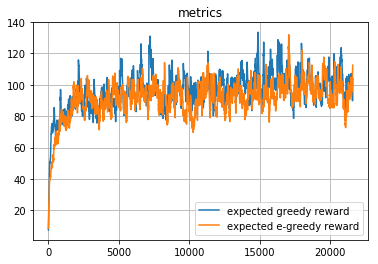

Random session examples


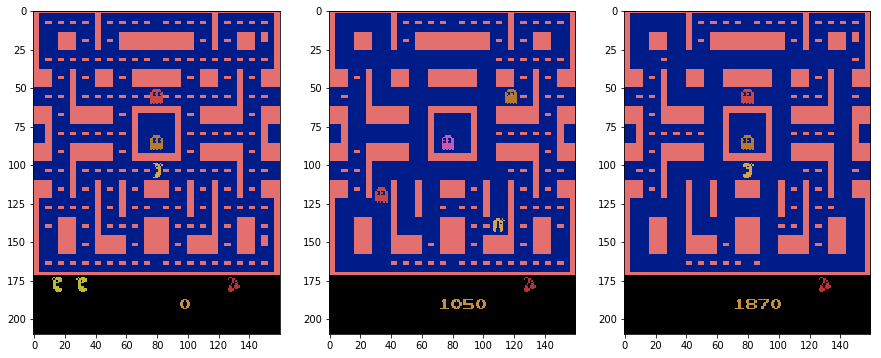

epoch 21610,loss 315.76021, epsilon 0.05000, rewards: ( e-greedy 107.84168, greedy 103.42657) 
rec 315.593 reg 0.167
epoch 21620,loss 1706.52703, epsilon 0.05000, rewards: ( e-greedy 108.80751, greedy 100.52142) 
rec 1706.360 reg 0.167
epoch 21630,loss 694.07043, epsilon 0.05000, rewards: ( e-greedy 105.67676, greedy 100.15677) 
rec 693.903 reg 0.167
epoch 21640,loss 1359.14077, epsilon 0.05000, rewards: ( e-greedy 104.35908, greedy 100.95360) 
rec 1358.973 reg 0.167
epoch 21650,loss 1560.84497, epsilon 0.05000, rewards: ( e-greedy 104.73567, greedy 100.17074) 
rec 1560.677 reg 0.167
epoch 21660,loss 450.85663, epsilon 0.05000, rewards: ( e-greedy 98.82461, greedy 96.27866) 
rec 450.689 reg 0.168
epoch 21670,loss 2277.35111, epsilon 0.05000, rewards: ( e-greedy 103.50465, greedy 107.52580) 
rec 2277.184 reg 0.168
epoch 21680,loss 2523.12190, epsilon 0.05000, rewards: ( e-greedy 105.09168, greedy 104.08572) 
rec 2522.954 reg 0.168
epoch 21690,loss 564.60017, epsilon 0.05000, rewards: ( 

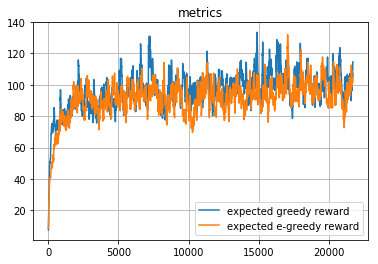

Random session examples


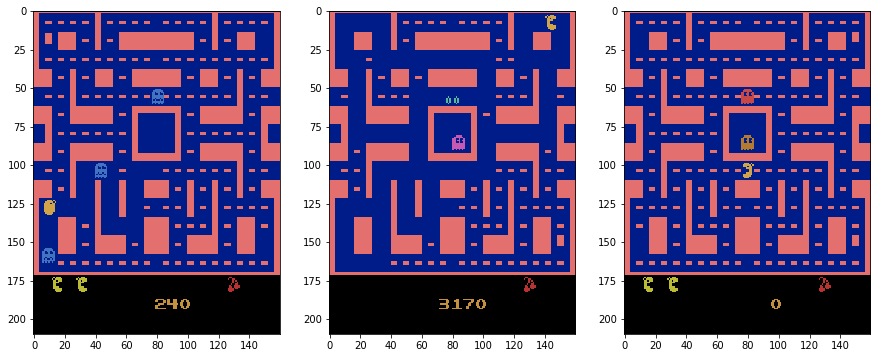

epoch 21710,loss 696.74393, epsilon 0.05000, rewards: ( e-greedy 101.02434, greedy 119.66099) 
rec 696.576 reg 0.168
epoch 21720,loss 1865.98345, epsilon 0.05000, rewards: ( e-greedy 100.48440, greedy 110.50739) 
rec 1865.816 reg 0.168
epoch 21730,loss 499.29997, epsilon 0.05000, rewards: ( e-greedy 96.06096, greedy 107.33165) 
rec 499.132 reg 0.168
epoch 21740,loss 2060.27698, epsilon 0.05000, rewards: ( e-greedy 102.45487, greedy 108.78599) 
rec 2060.109 reg 0.168
epoch 21750,loss 1645.55216, epsilon 0.05000, rewards: ( e-greedy 105.39688, greedy 103.65739) 
rec 1645.384 reg 0.168
epoch 21760,loss 663.89711, epsilon 0.05000, rewards: ( e-greedy 100.98219, greedy 105.79165) 
rec 663.729 reg 0.168
epoch 21770,loss 3830.16794, epsilon 0.05000, rewards: ( e-greedy 110.69647, greedy 107.08748) 
rec 3830.000 reg 0.168
epoch 21780,loss 892.13809, epsilon 0.05000, rewards: ( e-greedy 105.56432, greedy 100.81623) 
rec 891.970 reg 0.168
epoch 21790,loss 1698.39340, epsilon 0.05000, rewards: ( 

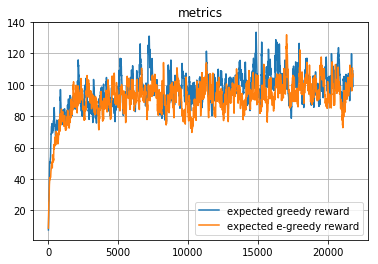

Random session examples


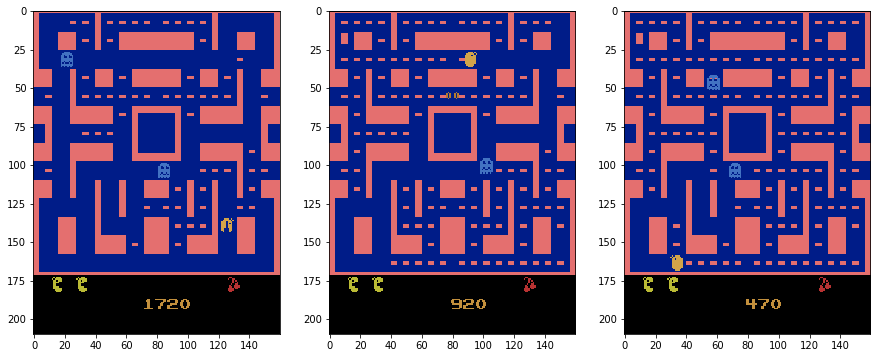

epoch 21810,loss 730.56099, epsilon 0.05000, rewards: ( e-greedy 102.05952, greedy 109.49816) 
rec 730.393 reg 0.168
epoch 21820,loss 503.63585, epsilon 0.05000, rewards: ( e-greedy 99.54107, greedy 109.79834) 
rec 503.468 reg 0.168
epoch 21830,loss 2337.19113, epsilon 0.05000, rewards: ( e-greedy 102.02446, greedy 113.38101) 
rec 2337.023 reg 0.168
epoch 21840,loss 1320.42055, epsilon 0.05000, rewards: ( e-greedy 100.57201, greedy 110.66791) 
rec 1320.252 reg 0.168
epoch 21850,loss 1070.44711, epsilon 0.05000, rewards: ( e-greedy 101.26481, greedy 112.97612) 
rec 1070.279 reg 0.168
epoch 21860,loss 1542.84011, epsilon 0.05000, rewards: ( e-greedy 105.45083, greedy 116.24101) 
rec 1542.672 reg 0.168
epoch 21870,loss 840.59516, epsilon 0.05000, rewards: ( e-greedy 104.84325, greedy 120.74191) 
rec 840.427 reg 0.168
epoch 21880,loss 808.09069, epsilon 0.05000, rewards: ( e-greedy 100.48392, greedy 117.29272) 
rec 807.922 reg 0.168
epoch 21890,loss 2889.09067, epsilon 0.05000, rewards: ( 

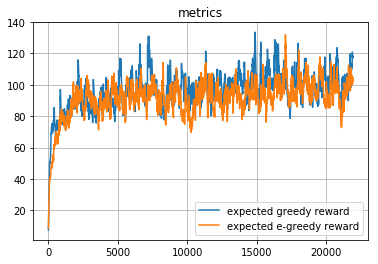

Random session examples


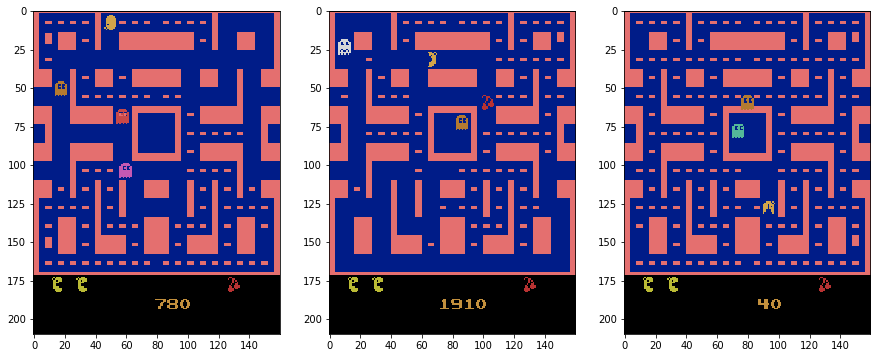

epoch 21910,loss 888.80011, epsilon 0.05000, rewards: ( e-greedy 101.51590, greedy 116.36139) 
rec 888.631 reg 0.169
epoch 21920,loss 2038.62541, epsilon 0.05000, rewards: ( e-greedy 102.05181, greedy 116.10025) 
rec 2038.457 reg 0.169
epoch 21930,loss 1227.15539, epsilon 0.05000, rewards: ( e-greedy 103.22163, greedy 114.24023) 
rec 1226.987 reg 0.169
epoch 21940,loss 586.68313, epsilon 0.05000, rewards: ( e-greedy 99.52447, greedy 110.56620) 
rec 586.514 reg 0.169
epoch 21950,loss 1218.01138, epsilon 0.05000, rewards: ( e-greedy 102.00952, greedy 107.75958) 
rec 1217.842 reg 0.169
epoch 21960,loss 6394.47710, epsilon 0.05000, rewards: ( e-greedy 103.24607, greedy 111.17112) 
rec 6394.308 reg 0.169
epoch 21970,loss 710.22165, epsilon 0.05000, rewards: ( e-greedy 102.10896, greedy 117.36651) 
rec 710.053 reg 0.169
epoch 21980,loss 871.80300, epsilon 0.05000, rewards: ( e-greedy 97.96057, greedy 120.50486) 
rec 871.634 reg 0.169
epoch 21990,loss 1317.24862, epsilon 0.05000, rewards: ( e

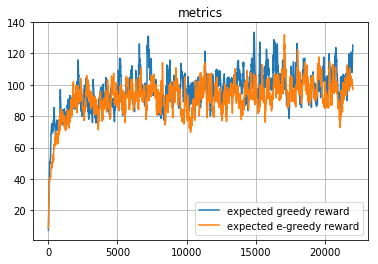

Random session examples


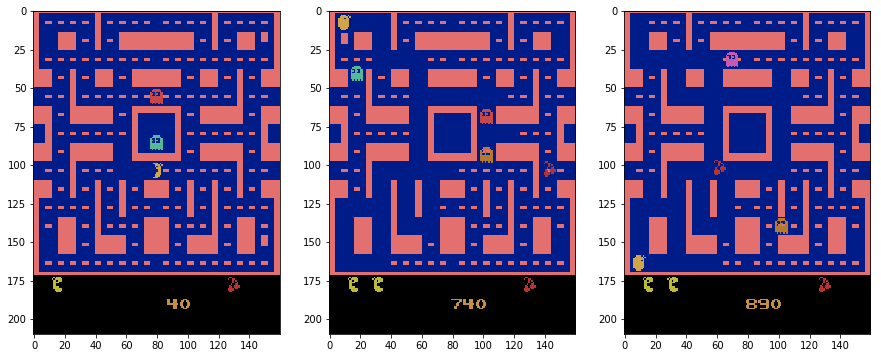

[2017-05-25 01:28:13,237] Making new env: MsPacman-v0
[2017-05-25 01:28:13,403] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 01:28:13,413] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.29.19270.video000000.mp4
[2017-05-25 01:28:14,923] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.29.19270.video000001.mp4


Episode finished after 562 timesteps with reward=240.0
Episode finished after 559 timesteps with reward=140.0
Episode finished after 774 timesteps with reward=240.0
Episode finished after 806 timesteps with reward=240.0
Episode finished after 777 timesteps with reward=290.0
Episode finished after 713 timesteps with reward=240.0
Episode finished after 665 timesteps with reward=300.0


[2017-05-25 01:28:24,051] Starting new video recorder writing to /home/vishimtsev/folder/lstm/openaigym.video.29.19270.video000008.mp4


Episode finished after 648 timesteps with reward=190.0
Episode finished after 665 timesteps with reward=170.0
Episode finished after 680 timesteps with reward=240.0
Episode finished after 589 timesteps with reward=220.0
Episode finished after 562 timesteps with reward=240.0
Episode finished after 676 timesteps with reward=200.0
Episode finished after 640 timesteps with reward=170.0
Episode finished after 633 timesteps with reward=240.0
Episode finished after 575 timesteps with reward=160.0
Episode finished after 663 timesteps with reward=280.0
Episode finished after 630 timesteps with reward=260.0
Episode finished after 1297 timesteps with reward=240.0


[2017-05-25 01:28:38,789] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm')


Episode finished after 497 timesteps with reward=190.0
Mean 224.5, Var 1824.75
epoch 22010,loss 902.75476, epsilon 0.05000, rewards: ( e-greedy 98.88950, greedy 120.22742) 
rec 902.586 reg 0.169
epoch 22020,loss 1630.79488, epsilon 0.05000, rewards: ( e-greedy 101.43805, greedy 117.07968) 
rec 1630.626 reg 0.169
epoch 22030,loss 1692.53781, epsilon 0.05000, rewards: ( e-greedy 103.35675, greedy 119.68421) 
rec 1692.369 reg 0.169
epoch 22040,loss 1329.21924, epsilon 0.05000, rewards: ( e-greedy 104.20857, greedy 125.77829) 
rec 1329.050 reg 0.169
epoch 22050,loss 692.37922, epsilon 0.05000, rewards: ( e-greedy 101.35022, greedy 123.51296) 
rec 692.210 reg 0.169
epoch 22060,loss 2070.53534, epsilon 0.05000, rewards: ( e-greedy 101.52769, greedy 122.16166) 
rec 2070.366 reg 0.169
epoch 22070,loss 1296.76747, epsilon 0.05000, rewards: ( e-greedy 102.62492, greedy 116.75800) 
rec 1296.598 reg 0.169
epoch 22080,loss 769.50290, epsilon 0.05000, rewards: ( e-greedy 99.04993, greedy 116.89470) 

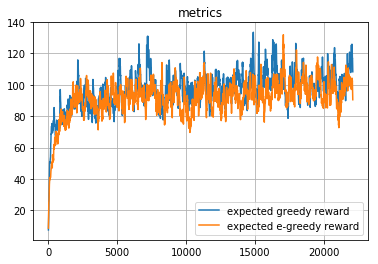

Random session examples


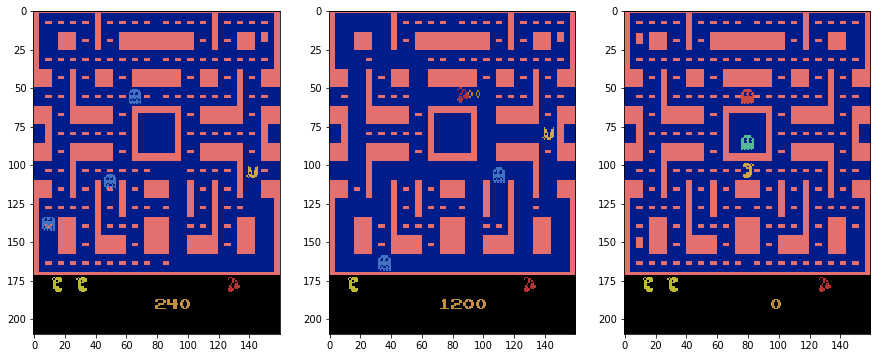

epoch 22110,loss 1004.81738, epsilon 0.05000, rewards: ( e-greedy 89.63740, greedy 109.28623) 
rec 1004.648 reg 0.169
epoch 22120,loss 575.35020, epsilon 0.05000, rewards: ( e-greedy 87.48616, greedy 107.98261) 
rec 575.181 reg 0.169
epoch 22130,loss 6526.80225, epsilon 0.05000, rewards: ( e-greedy 91.92504, greedy 109.18435) 
rec 6526.633 reg 0.169
epoch 22140,loss 466.48727, epsilon 0.05000, rewards: ( e-greedy 88.85754, greedy 105.64091) 
rec 466.318 reg 0.170
epoch 22150,loss 1194.31129, epsilon 0.05000, rewards: ( e-greedy 90.40929, greedy 111.07682) 
rec 1194.142 reg 0.170
epoch 22160,loss 3541.82047, epsilon 0.05000, rewards: ( e-greedy 96.55586, greedy 114.15664) 
rec 3541.651 reg 0.170


In [ ]:
%%time

n_epochs = 30000

for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        rws = np.array(pool.evaluate(n_games=20,save_path="lstm",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
    epoch_counter  +=1

    
# Time to drink some coffee!

## Record videos

In [55]:
rws = np.array(pool.evaluate(n_games=220,save_path="lstm1",record_video=True))
print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
np.savez(open('rws5hist_lstm_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)

[2017-05-25 01:55:51,892] Making new env: MsPacman-v0
[2017-05-25 01:55:52,147] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-25 01:55:52,156] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000000.mp4
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()
[2017-05-25 01:55:53,834] Starting new video recorder writing to /home/vishimts

Episode finished after 623 timesteps with reward=260.0
Episode finished after 585 timesteps with reward=260.0
Episode finished after 789 timesteps with reward=360.0
Episode finished after 677 timesteps with reward=280.0
Episode finished after 715 timesteps with reward=310.0
Episode finished after 653 timesteps with reward=240.0
Episode finished after 660 timesteps with reward=190.0


[2017-05-25 01:56:02,868] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000008.mp4


Episode finished after 612 timesteps with reward=240.0
Episode finished after 1041 timesteps with reward=300.0
Episode finished after 536 timesteps with reward=240.0
Episode finished after 541 timesteps with reward=240.0
Episode finished after 668 timesteps with reward=230.0
Episode finished after 711 timesteps with reward=240.0
Episode finished after 719 timesteps with reward=160.0
Episode finished after 671 timesteps with reward=250.0
Episode finished after 504 timesteps with reward=220.0
Episode finished after 786 timesteps with reward=220.0
Episode finished after 823 timesteps with reward=210.0
Episode finished after 940 timesteps with reward=300.0
Episode finished after 676 timesteps with reward=180.0
Episode finished after 763 timesteps with reward=240.0
Episode finished after 694 timesteps with reward=270.0
Episode finished after 771 timesteps with reward=240.0
Episode finished after 635 timesteps with reward=240.0
Episode finished after 933 timesteps with reward=300.0
Episode f

[2017-05-25 01:56:28,909] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000027.mp4


Episode finished after 788 timesteps with reward=240.0
Episode finished after 803 timesteps with reward=260.0
Episode finished after 700 timesteps with reward=300.0
Episode finished after 766 timesteps with reward=270.0
Episode finished after 703 timesteps with reward=300.0
Episode finished after 660 timesteps with reward=230.0
Episode finished after 692 timesteps with reward=300.0
Episode finished after 670 timesteps with reward=270.0
Episode finished after 547 timesteps with reward=240.0
Episode finished after 647 timesteps with reward=190.0
Episode finished after 504 timesteps with reward=170.0
Episode finished after 571 timesteps with reward=150.0
Episode finished after 689 timesteps with reward=300.0
Episode finished after 593 timesteps with reward=250.0
Episode finished after 560 timesteps with reward=190.0
Episode finished after 579 timesteps with reward=150.0
Episode finished after 646 timesteps with reward=300.0
Episode finished after 836 timesteps with reward=240.0
Episode fi

[2017-05-25 01:57:14,933] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000064.mp4


Episode finished after 753 timesteps with reward=240.0
Episode finished after 559 timesteps with reward=300.0
Episode finished after 713 timesteps with reward=300.0
Episode finished after 774 timesteps with reward=200.0
Episode finished after 777 timesteps with reward=240.0
Episode finished after 678 timesteps with reward=240.0
Episode finished after 537 timesteps with reward=240.0
Episode finished after 558 timesteps with reward=240.0
Episode finished after 579 timesteps with reward=180.0
Episode finished after 683 timesteps with reward=240.0
Episode finished after 678 timesteps with reward=210.0
Episode finished after 589 timesteps with reward=240.0
Episode finished after 629 timesteps with reward=240.0
Episode finished after 721 timesteps with reward=240.0
Episode finished after 725 timesteps with reward=240.0
Episode finished after 782 timesteps with reward=240.0
Episode finished after 729 timesteps with reward=300.0
Episode finished after 980 timesteps with reward=240.0
Episode fi

[2017-05-25 01:58:32,827] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000125.mp4


Episode finished after 629 timesteps with reward=180.0
Episode finished after 689 timesteps with reward=240.0
Episode finished after 647 timesteps with reward=170.0
Episode finished after 630 timesteps with reward=250.0
Episode finished after 559 timesteps with reward=190.0
Episode finished after 700 timesteps with reward=190.0
Episode finished after 695 timesteps with reward=210.0
Episode finished after 642 timesteps with reward=300.0
Episode finished after 568 timesteps with reward=240.0
Episode finished after 617 timesteps with reward=200.0
Episode finished after 927 timesteps with reward=240.0
Episode finished after 573 timesteps with reward=300.0
Episode finished after 582 timesteps with reward=300.0
Episode finished after 663 timesteps with reward=190.0
Episode finished after 727 timesteps with reward=280.0
Episode finished after 609 timesteps with reward=260.0
Episode finished after 721 timesteps with reward=300.0
Episode finished after 930 timesteps with reward=340.0
Episode fi

[2017-05-25 02:00:27,237] Starting new video recorder writing to /home/vishimtsev/folder/lstm1/openaigym.video.31.19270.video000216.mp4


Episode finished after 623 timesteps with reward=190.0
Episode finished after 691 timesteps with reward=300.0
Episode finished after 641 timesteps with reward=220.0
Episode finished after 647 timesteps with reward=300.0


[2017-05-25 02:00:32,829] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/lstm1')


Episode finished after 824 timesteps with reward=300.0
Mean 250.181818182, Var 4169.05785124


In [58]:
np.save(open('greedy_lstm_log.pcl', 'wb'), score_log['expected greedy reward'])
np.save(open('egreedy_lstm_log.pcl', 'wb'), score_log['expected e-greedy reward'])

###### Patially used code: Aleksey Grinchuk (AlexGrinch), Mariya Popova (Mariewelt) ... and some hedgehog